In [ ]:
#Steps to follow when working with real world data
#1. Load data
#2. Look at data to remove irrelevant data
#3. Finding missing values 
#4. Understand categories
#5. Pick a model

# Lets look at a real world problem such as home price prediction

In [27]:
##Load data
import pandas as pd

# Load the data
df = pd.read_csv('train.csv')

# Lets look at the data
df.head()

,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0_1,0,1,-0.300875,0.932573,0.113691,-0.402206,0.378386,-0.203938,-0.413469,...,0.366028,-1.095620,0.200075,0.819155,0.941183,-0.086764,-1.087009,-1.044826,-0.287605,0.321566
1,0_2,0,2,-0.231040,0.810802,-0.514115,0.742368,-0.616673,-0.194255,1.771210,...,-0.154193,0.912726,-0.734579,0.819155,0.941183,-0.387617,-1.087009,-0.929529,-0.974060,-0.343624
2,0_6,0,6,0.568807,0.393974,0.615937,0.567806,-0.607963,0.068883,-1.083155,...,-0.138020,0.912726,-0.551904,-1.220772,-1.060166,-0.219097,-1.087009,-0.612428,-0.113944,0.243608
3,0_7,0,7,-1.064780,-2.343535,-0.011870,1.874606,-0.606346,-0.586827,-0.815737,...,0.382201,0.912726,-0.266359,-1.220772,0.941183,-0.609113,0.104928,-0.783423,1.151730,-0.773309
4,0_8,0,8,-0.531940,0.842057,-0.262993,2.330030,-0.583422,-0.618392,-0.742814,...,-0.170365,0.912726,-0.741355,-1.220772,0.941183,-0.588445,0.104928,0.753279,1.345611,-0.737624


In [6]:
df.dtypes

row_id            object
time_id            int64
investment_id      int64
target           float64
f_0              float64
                  ...   
f_295            float64
f_296            float64
f_297            float64
f_298            float64
f_299            float64
Length: 304, dtype: object

In [2]:
object_cols = [col for col in df.columns if df[col].dtype == "object"]
object_cols

['row_id']

In [3]:
cols_with_missing = [col for col in df.columns
                     if df[col].isnull().any()]
cols_with_missing

[]

In [28]:
y = df.target
x = df
x = x.drop(['target'], axis=1)


In [29]:
x = x.drop(['row_id'], axis=1)


In [15]:
print(x.shape)
print(y.shape)

(3141410, 302)
(3141410,)


In [6]:
from sklearn.model_selection import train_test_split
# Divide data into training and validation subsets
x_train, x_valid, y_train, y_valid = train_test_split(x, y, train_size=0.6, test_size=0.2,
                                                      random_state=0)

In [ ]:
#--------PIPELINING BEGIN---------------#

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

NameError: name 'numerical_cols' is not defined

In [ ]:
from sklearn.metrics import mean_absolute_error

# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

# Preprocessing of training data, fit model 
my_pipeline.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)

# Evaluate the model
score = mean_absolute_error(y_valid, preds)
print('MAE:', score)

In [ ]:
#--------XG BOOST BEGIN---------------#

In [7]:
from xgboost import XGBRegressor
my_model = XGBRegressor(n_estimators=100, learning_rate=0.05, n_jobs=4)
my_model.fit(x_train, y_train, 
             early_stopping_rounds=5, 
             eval_set=[(x_valid, y_valid)], 
             verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [9]:
from sklearn.metrics import mean_absolute_error

predictions = my_model.predict(x_valid)
print("Mean Absolute Error: " + str(mean_absolute_error(predictions, y_valid)))

Mean Absolute Error: 0.6238369580644012


In [14]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_valid, predictions))
print(" RMSE: %f" % (rmse) + "R2 SCore = " + str(r2_score(y_valid,predictions)))

 RMSE: 0.911719R2 SCore = 0.021951742161738563


In [ ]:
#--------XG BOOST END---------------#

In [ ]:
#--------CAT BOOST BEGIN---------------#

In [20]:
import catboost as cb

train_dataset = cb.Pool(x_train, y_train) 
test_dataset = cb.Pool(x_valid, y_valid)

model = cb.CatBoostRegressor(loss_function="RMSE")
grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.05, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
model.grid_search(grid, train_dataset)

0:	learn: 0.9177664	test: 0.9228473	best: 0.9228473 (0)	total: 267ms	remaining: 26.4s
1:	learn: 0.9175696	test: 0.9226439	best: 0.9226439 (1)	total: 422ms	remaining: 20.7s
2:	learn: 0.9173776	test: 0.9224488	best: 0.9224488 (2)	total: 633ms	remaining: 20.5s
3:	learn: 0.9172080	test: 0.9222763	best: 0.9222763 (3)	total: 799ms	remaining: 19.2s
4:	learn: 0.9170523	test: 0.9221208	best: 0.9221208 (4)	total: 972ms	remaining: 18.5s
5:	learn: 0.9169085	test: 0.9219775	best: 0.9219775 (5)	total: 1.13s	remaining: 17.8s
6:	learn: 0.9167658	test: 0.9218385	best: 0.9218385 (6)	total: 1.3s	remaining: 17.3s
7:	learn: 0.9166339	test: 0.9217058	best: 0.9217058 (7)	total: 1.45s	remaining: 16.7s
8:	learn: 0.9165118	test: 0.9215859	best: 0.9215859 (8)	total: 1.62s	remaining: 16.4s
9:	learn: 0.9163963	test: 0.9214645	best: 0.9214645 (9)	total: 1.78s	remaining: 16.1s
10:	learn: 0.9162944	test: 0.9213674	best: 0.9213674 (10)	total: 1.95s	remaining: 15.8s
11:	learn: 0.9161908	test: 0.9212711	best: 0.9212711 

94:	learn: 0.9129432	test: 0.9181084	best: 0.9181084 (94)	total: 20.4s	remaining: 1.07s
95:	learn: 0.9129253	test: 0.9180915	best: 0.9180915 (95)	total: 20.6s	remaining: 860ms
96:	learn: 0.9129100	test: 0.9180760	best: 0.9180760 (96)	total: 20.9s	remaining: 645ms
97:	learn: 0.9128948	test: 0.9180575	best: 0.9180575 (97)	total: 21.1s	remaining: 430ms
98:	learn: 0.9128790	test: 0.9180428	best: 0.9180428 (98)	total: 21.3s	remaining: 216ms
99:	learn: 0.9128645	test: 0.9180281	best: 0.9180281 (99)	total: 21.5s	remaining: 0us

bestTest = 0.9180281105
bestIteration = 99

0:	loss: 0.9180281	best: 0.9180281 (0)	total: 47.5s	remaining: 1h 15m 9s
0:	learn: 0.9175538	test: 0.9226215	best: 0.9226215 (0)	total: 240ms	remaining: 23.7s
1:	learn: 0.9172017	test: 0.9222601	best: 0.9222601 (1)	total: 516ms	remaining: 25.3s
2:	learn: 0.9168853	test: 0.9219380	best: 0.9219380 (2)	total: 774ms	remaining: 25s
3:	learn: 0.9166114	test: 0.9216689	best: 0.9216689 (3)	total: 1.05s	remaining: 25.2s
4:	learn: 0.91

87:	learn: 0.9119632	test: 0.9171998	best: 0.9171998 (87)	total: 19s	remaining: 2.59s
88:	learn: 0.9119442	test: 0.9171782	best: 0.9171782 (88)	total: 19.2s	remaining: 2.38s
89:	learn: 0.9119294	test: 0.9171657	best: 0.9171657 (89)	total: 19.4s	remaining: 2.16s
90:	learn: 0.9119126	test: 0.9171458	best: 0.9171458 (90)	total: 19.6s	remaining: 1.94s
91:	learn: 0.9118928	test: 0.9171343	best: 0.9171343 (91)	total: 19.8s	remaining: 1.72s
92:	learn: 0.9118757	test: 0.9171174	best: 0.9171174 (92)	total: 20.1s	remaining: 1.51s
93:	learn: 0.9118570	test: 0.9171019	best: 0.9171019 (93)	total: 20.3s	remaining: 1.29s
94:	learn: 0.9118435	test: 0.9170912	best: 0.9170912 (94)	total: 20.5s	remaining: 1.08s
95:	learn: 0.9118280	test: 0.9170730	best: 0.9170730 (95)	total: 20.7s	remaining: 862ms
96:	learn: 0.9118124	test: 0.9170578	best: 0.9170578 (96)	total: 20.9s	remaining: 647ms
97:	learn: 0.9117926	test: 0.9170398	best: 0.9170398 (97)	total: 21.2s	remaining: 432ms
98:	learn: 0.9117712	test: 0.91701

80:	learn: 0.9132012	test: 0.9183600	best: 0.9183600 (80)	total: 20.9s	remaining: 4.91s
81:	learn: 0.9131776	test: 0.9183391	best: 0.9183391 (81)	total: 21.4s	remaining: 4.69s
82:	learn: 0.9131580	test: 0.9183234	best: 0.9183234 (82)	total: 21.7s	remaining: 4.45s
83:	learn: 0.9131395	test: 0.9183066	best: 0.9183066 (83)	total: 22s	remaining: 4.2s
84:	learn: 0.9131217	test: 0.9182896	best: 0.9182896 (84)	total: 22.4s	remaining: 3.96s
85:	learn: 0.9130992	test: 0.9182627	best: 0.9182627 (85)	total: 22.8s	remaining: 3.71s
86:	learn: 0.9130826	test: 0.9182490	best: 0.9182490 (86)	total: 23.1s	remaining: 3.46s
87:	learn: 0.9130645	test: 0.9182285	best: 0.9182285 (87)	total: 23.6s	remaining: 3.22s
88:	learn: 0.9130468	test: 0.9182097	best: 0.9182097 (88)	total: 24.1s	remaining: 2.98s
89:	learn: 0.9130265	test: 0.9181933	best: 0.9181933 (89)	total: 24.4s	remaining: 2.71s
90:	learn: 0.9130098	test: 0.9181749	best: 0.9181749 (90)	total: 24.8s	remaining: 2.45s
91:	learn: 0.9129925	test: 0.918156

73:	learn: 0.9122493	test: 0.9174462	best: 0.9174462 (73)	total: 17.2s	remaining: 6.05s
74:	learn: 0.9122310	test: 0.9174250	best: 0.9174250 (74)	total: 17.6s	remaining: 5.86s
75:	learn: 0.9122119	test: 0.9174119	best: 0.9174119 (75)	total: 17.9s	remaining: 5.64s
76:	learn: 0.9121920	test: 0.9174002	best: 0.9174002 (76)	total: 18.1s	remaining: 5.42s
77:	learn: 0.9121726	test: 0.9173847	best: 0.9173847 (77)	total: 18.4s	remaining: 5.2s
78:	learn: 0.9121435	test: 0.9173594	best: 0.9173594 (78)	total: 18.7s	remaining: 4.97s
79:	learn: 0.9121240	test: 0.9173409	best: 0.9173409 (79)	total: 18.9s	remaining: 4.73s
80:	learn: 0.9121030	test: 0.9173202	best: 0.9173202 (80)	total: 19.2s	remaining: 4.51s
81:	learn: 0.9120788	test: 0.9172934	best: 0.9172934 (81)	total: 19.5s	remaining: 4.29s
82:	learn: 0.9120597	test: 0.9172749	best: 0.9172749 (82)	total: 19.8s	remaining: 4.06s
83:	learn: 0.9120414	test: 0.9172685	best: 0.9172685 (83)	total: 20.2s	remaining: 3.85s
84:	learn: 0.9120223	test: 0.9172

66:	learn: 0.9135144	test: 0.9186462	best: 0.9186462 (66)	total: 15s	remaining: 7.39s
67:	learn: 0.9134921	test: 0.9186229	best: 0.9186229 (67)	total: 15.2s	remaining: 7.15s
68:	learn: 0.9134685	test: 0.9186008	best: 0.9186008 (68)	total: 15.4s	remaining: 6.92s
69:	learn: 0.9134422	test: 0.9185779	best: 0.9185779 (69)	total: 15.7s	remaining: 6.72s
70:	learn: 0.9134156	test: 0.9185499	best: 0.9185499 (70)	total: 16s	remaining: 6.53s
71:	learn: 0.9133930	test: 0.9185316	best: 0.9185316 (71)	total: 16.2s	remaining: 6.3s
72:	learn: 0.9133734	test: 0.9185123	best: 0.9185123 (72)	total: 16.5s	remaining: 6.11s
73:	learn: 0.9133497	test: 0.9184921	best: 0.9184921 (73)	total: 16.8s	remaining: 5.89s
74:	learn: 0.9133301	test: 0.9184754	best: 0.9184754 (74)	total: 17s	remaining: 5.66s
75:	learn: 0.9133062	test: 0.9184543	best: 0.9184543 (75)	total: 17.2s	remaining: 5.43s
76:	learn: 0.9132844	test: 0.9184349	best: 0.9184349 (76)	total: 17.4s	remaining: 5.21s
77:	learn: 0.9132620	test: 0.9184142	be

59:	learn: 0.9125873	test: 0.9177651	best: 0.9177651 (59)	total: 12.5s	remaining: 8.35s
60:	learn: 0.9125552	test: 0.9177349	best: 0.9177349 (60)	total: 12.8s	remaining: 8.19s
61:	learn: 0.9125312	test: 0.9177096	best: 0.9177096 (61)	total: 13.1s	remaining: 8.03s
62:	learn: 0.9125010	test: 0.9176823	best: 0.9176823 (62)	total: 13.4s	remaining: 7.86s
63:	learn: 0.9124767	test: 0.9176634	best: 0.9176634 (63)	total: 13.6s	remaining: 7.64s
64:	learn: 0.9124583	test: 0.9176468	best: 0.9176468 (64)	total: 13.9s	remaining: 7.46s
65:	learn: 0.9124343	test: 0.9176196	best: 0.9176196 (65)	total: 14s	remaining: 7.23s
66:	learn: 0.9124093	test: 0.9176009	best: 0.9176009 (66)	total: 14.3s	remaining: 7.02s
67:	learn: 0.9123853	test: 0.9175827	best: 0.9175827 (67)	total: 14.5s	remaining: 6.82s
68:	learn: 0.9123624	test: 0.9175587	best: 0.9175587 (68)	total: 14.7s	remaining: 6.61s
69:	learn: 0.9123437	test: 0.9175437	best: 0.9175437 (69)	total: 15s	remaining: 6.43s
70:	learn: 0.9123098	test: 0.9175102

53:	learn: 0.9138662	test: 0.9189918	best: 0.9189918 (53)	total: 11.1s	remaining: 9.48s
54:	learn: 0.9138371	test: 0.9189637	best: 0.9189637 (54)	total: 11.4s	remaining: 9.36s
55:	learn: 0.9138116	test: 0.9189388	best: 0.9189388 (55)	total: 11.7s	remaining: 9.22s
56:	learn: 0.9137789	test: 0.9189106	best: 0.9189106 (56)	total: 12s	remaining: 9.02s
57:	learn: 0.9137486	test: 0.9188817	best: 0.9188817 (57)	total: 12.2s	remaining: 8.83s
58:	learn: 0.9137215	test: 0.9188562	best: 0.9188562 (58)	total: 12.4s	remaining: 8.61s
59:	learn: 0.9136943	test: 0.9188276	best: 0.9188276 (59)	total: 12.6s	remaining: 8.38s
60:	learn: 0.9136685	test: 0.9188016	best: 0.9188016 (60)	total: 12.8s	remaining: 8.19s
61:	learn: 0.9136402	test: 0.9187718	best: 0.9187718 (61)	total: 13.1s	remaining: 8.03s
62:	learn: 0.9136156	test: 0.9187475	best: 0.9187475 (62)	total: 13.4s	remaining: 7.86s
63:	learn: 0.9135907	test: 0.9187265	best: 0.9187265 (63)	total: 13.6s	remaining: 7.65s
64:	learn: 0.9135655	test: 0.91870

47:	learn: 0.9129353	test: 0.9180932	best: 0.9180932 (47)	total: 9.26s	remaining: 10s
48:	learn: 0.9128964	test: 0.9180590	best: 0.9180590 (48)	total: 9.53s	remaining: 9.92s
49:	learn: 0.9128664	test: 0.9180312	best: 0.9180312 (49)	total: 9.69s	remaining: 9.69s
50:	learn: 0.9128415	test: 0.9180039	best: 0.9180039 (50)	total: 9.94s	remaining: 9.55s
51:	learn: 0.9128120	test: 0.9179800	best: 0.9179800 (51)	total: 10.1s	remaining: 9.36s
52:	learn: 0.9127831	test: 0.9179521	best: 0.9179521 (52)	total: 10.4s	remaining: 9.22s
53:	learn: 0.9127532	test: 0.9179255	best: 0.9179255 (53)	total: 10.6s	remaining: 9.02s
54:	learn: 0.9127259	test: 0.9178974	best: 0.9178974 (54)	total: 10.8s	remaining: 8.85s
55:	learn: 0.9126988	test: 0.9178751	best: 0.9178751 (55)	total: 11.1s	remaining: 8.69s
56:	learn: 0.9126729	test: 0.9178508	best: 0.9178508 (56)	total: 11.2s	remaining: 8.47s
57:	learn: 0.9126454	test: 0.9178266	best: 0.9178266 (57)	total: 11.5s	remaining: 8.29s
58:	learn: 0.9126210	test: 0.91779

40:	learn: 0.9143322	test: 0.9194306	best: 0.9194306 (40)	total: 7.62s	remaining: 20.3s
41:	learn: 0.9142931	test: 0.9193915	best: 0.9193915 (41)	total: 7.89s	remaining: 20.3s
42:	learn: 0.9142539	test: 0.9193509	best: 0.9193509 (42)	total: 8.1s	remaining: 20.2s
43:	learn: 0.9142164	test: 0.9193139	best: 0.9193139 (43)	total: 8.36s	remaining: 20.1s
44:	learn: 0.9141795	test: 0.9192792	best: 0.9192792 (44)	total: 8.64s	remaining: 20.2s
45:	learn: 0.9141411	test: 0.9192414	best: 0.9192414 (45)	total: 8.86s	remaining: 20s
46:	learn: 0.9141003	test: 0.9192039	best: 0.9192039 (46)	total: 9.05s	remaining: 19.8s
47:	learn: 0.9140603	test: 0.9191645	best: 0.9191645 (47)	total: 9.27s	remaining: 19.7s
48:	learn: 0.9140215	test: 0.9191297	best: 0.9191297 (48)	total: 9.46s	remaining: 19.5s
49:	learn: 0.9139857	test: 0.9190990	best: 0.9190990 (49)	total: 9.71s	remaining: 19.4s
50:	learn: 0.9139537	test: 0.9190668	best: 0.9190668 (50)	total: 9.9s	remaining: 19.2s
51:	learn: 0.9139232	test: 0.9190355

133:	learn: 0.9123865	test: 0.9175852	best: 0.9175852 (133)	total: 28.4s	remaining: 3.4s
134:	learn: 0.9123761	test: 0.9175746	best: 0.9175746 (134)	total: 28.7s	remaining: 3.18s
135:	learn: 0.9123649	test: 0.9175644	best: 0.9175644 (135)	total: 28.9s	remaining: 2.97s
136:	learn: 0.9123529	test: 0.9175547	best: 0.9175547 (136)	total: 29.1s	remaining: 2.76s
137:	learn: 0.9123421	test: 0.9175435	best: 0.9175435 (137)	total: 29.3s	remaining: 2.55s
138:	learn: 0.9123301	test: 0.9175295	best: 0.9175295 (138)	total: 29.6s	remaining: 2.34s
139:	learn: 0.9123189	test: 0.9175200	best: 0.9175200 (139)	total: 29.8s	remaining: 2.13s
140:	learn: 0.9123094	test: 0.9175108	best: 0.9175108 (140)	total: 30s	remaining: 1.92s
141:	learn: 0.9122997	test: 0.9175020	best: 0.9175020 (141)	total: 30.2s	remaining: 1.7s
142:	learn: 0.9122886	test: 0.9174929	best: 0.9174929 (142)	total: 30.5s	remaining: 1.49s
143:	learn: 0.9122759	test: 0.9174804	best: 0.9174804 (143)	total: 30.7s	remaining: 1.28s
144:	learn: 0.

75:	learn: 0.9122119	test: 0.9174118	best: 0.9174118 (75)	total: 18.6s	remaining: 18.1s
76:	learn: 0.9121920	test: 0.9174002	best: 0.9174002 (76)	total: 18.9s	remaining: 17.9s
77:	learn: 0.9121725	test: 0.9173847	best: 0.9173847 (77)	total: 19.2s	remaining: 17.7s
78:	learn: 0.9121435	test: 0.9173594	best: 0.9173594 (78)	total: 19.5s	remaining: 17.5s
79:	learn: 0.9121240	test: 0.9173409	best: 0.9173409 (79)	total: 19.9s	remaining: 17.4s
80:	learn: 0.9121030	test: 0.9173201	best: 0.9173201 (80)	total: 20.2s	remaining: 17.2s
81:	learn: 0.9120788	test: 0.9172934	best: 0.9172934 (81)	total: 20.6s	remaining: 17.1s
82:	learn: 0.9120597	test: 0.9172749	best: 0.9172749 (82)	total: 20.8s	remaining: 16.8s
83:	learn: 0.9120414	test: 0.9172685	best: 0.9172685 (83)	total: 21s	remaining: 16.5s
84:	learn: 0.9120223	test: 0.9172572	best: 0.9172572 (84)	total: 21.2s	remaining: 16.2s
85:	learn: 0.9120021	test: 0.9172396	best: 0.9172396 (85)	total: 21.4s	remaining: 15.9s
86:	learn: 0.9119840	test: 0.91722

18:	learn: 0.9155734	test: 0.9206575	best: 0.9206575 (18)	total: 3.39s	remaining: 23.4s
19:	learn: 0.9155004	test: 0.9205784	best: 0.9205784 (19)	total: 3.69s	remaining: 24s
20:	learn: 0.9154264	test: 0.9205032	best: 0.9205032 (20)	total: 3.86s	remaining: 23.7s
21:	learn: 0.9153519	test: 0.9204340	best: 0.9204340 (21)	total: 4.03s	remaining: 23.5s
22:	learn: 0.9152897	test: 0.9203721	best: 0.9203721 (22)	total: 4.2s	remaining: 23.2s
23:	learn: 0.9152191	test: 0.9203008	best: 0.9203008 (23)	total: 4.38s	remaining: 23s
24:	learn: 0.9151489	test: 0.9202341	best: 0.9202341 (24)	total: 4.55s	remaining: 22.8s
25:	learn: 0.9150866	test: 0.9201771	best: 0.9201771 (25)	total: 4.79s	remaining: 22.8s
26:	learn: 0.9150235	test: 0.9201229	best: 0.9201229 (26)	total: 4.96s	remaining: 22.6s
27:	learn: 0.9149656	test: 0.9200659	best: 0.9200659 (27)	total: 5.15s	remaining: 22.4s
28:	learn: 0.9149077	test: 0.9199995	best: 0.9199995 (28)	total: 5.33s	remaining: 22.2s
29:	learn: 0.9148541	test: 0.9199461	

112:	learn: 0.9126618	test: 0.9178469	best: 0.9178469 (112)	total: 24.2s	remaining: 7.93s
113:	learn: 0.9126477	test: 0.9178320	best: 0.9178320 (113)	total: 24.4s	remaining: 7.72s
114:	learn: 0.9126353	test: 0.9178181	best: 0.9178181 (114)	total: 24.6s	remaining: 7.5s
115:	learn: 0.9126224	test: 0.9178083	best: 0.9178083 (115)	total: 24.9s	remaining: 7.28s
116:	learn: 0.9126099	test: 0.9177952	best: 0.9177952 (116)	total: 25.1s	remaining: 7.09s
117:	learn: 0.9125952	test: 0.9177826	best: 0.9177826 (117)	total: 25.3s	remaining: 6.87s
118:	learn: 0.9125820	test: 0.9177699	best: 0.9177699 (118)	total: 25.5s	remaining: 6.65s
119:	learn: 0.9125688	test: 0.9177571	best: 0.9177571 (119)	total: 25.8s	remaining: 6.44s
120:	learn: 0.9125549	test: 0.9177434	best: 0.9177434 (120)	total: 26s	remaining: 6.23s
121:	learn: 0.9125429	test: 0.9177344	best: 0.9177344 (121)	total: 26.2s	remaining: 6s
122:	learn: 0.9125230	test: 0.9177169	best: 0.9177169 (122)	total: 26.4s	remaining: 5.79s
123:	learn: 0.91

54:	learn: 0.9127256	test: 0.9178971	best: 0.9178971 (54)	total: 13.2s	remaining: 22.8s
55:	learn: 0.9126985	test: 0.9178748	best: 0.9178748 (55)	total: 13.5s	remaining: 22.6s
56:	learn: 0.9126726	test: 0.9178505	best: 0.9178505 (56)	total: 13.7s	remaining: 22.4s
57:	learn: 0.9126451	test: 0.9178264	best: 0.9178264 (57)	total: 14s	remaining: 22.2s
58:	learn: 0.9126207	test: 0.9177984	best: 0.9177984 (58)	total: 14.3s	remaining: 22.1s
59:	learn: 0.9125873	test: 0.9177650	best: 0.9177650 (59)	total: 14.7s	remaining: 22.1s
60:	learn: 0.9125551	test: 0.9177349	best: 0.9177349 (60)	total: 15s	remaining: 21.9s
61:	learn: 0.9125312	test: 0.9177095	best: 0.9177095 (61)	total: 15.3s	remaining: 21.7s
62:	learn: 0.9125009	test: 0.9176823	best: 0.9176823 (62)	total: 15.5s	remaining: 21.4s
63:	learn: 0.9124767	test: 0.9176633	best: 0.9176633 (63)	total: 15.7s	remaining: 21.1s
64:	learn: 0.9124583	test: 0.9176468	best: 0.9176468 (64)	total: 15.9s	remaining: 20.8s
65:	learn: 0.9124343	test: 0.9176196

147:	learn: 0.9109925	test: 0.9162982	best: 0.9162982 (147)	total: 33.8s	remaining: 457ms
148:	learn: 0.9109760	test: 0.9162808	best: 0.9162808 (148)	total: 34.1s	remaining: 229ms
149:	learn: 0.9109628	test: 0.9162676	best: 0.9162676 (149)	total: 34.3s	remaining: 0us

bestTest = 0.9162676346
bestIteration = 149

11:	loss: 0.9162676	best: 0.9162676 (9)	total: 5m 54s	remaining: 41m 19s
0:	learn: 0.9177665	test: 0.9228473	best: 0.9228473 (0)	total: 209ms	remaining: 31.2s
1:	learn: 0.9175696	test: 0.9226439	best: 0.9226439 (1)	total: 420ms	remaining: 31.1s
2:	learn: 0.9173776	test: 0.9224488	best: 0.9224488 (2)	total: 650ms	remaining: 31.8s
3:	learn: 0.9172080	test: 0.9222764	best: 0.9222764 (3)	total: 874ms	remaining: 31.9s
4:	learn: 0.9170523	test: 0.9221208	best: 0.9221208 (4)	total: 1.1s	remaining: 31.9s
5:	learn: 0.9169085	test: 0.9219776	best: 0.9219776 (5)	total: 1.38s	remaining: 33.1s
6:	learn: 0.9167659	test: 0.9218385	best: 0.9218385 (6)	total: 1.61s	remaining: 33s
7:	learn: 0.91

90:	learn: 0.9130098	test: 0.9181749	best: 0.9181749 (90)	total: 23.3s	remaining: 15.1s
91:	learn: 0.9129926	test: 0.9181561	best: 0.9181561 (91)	total: 23.5s	remaining: 14.8s
92:	learn: 0.9129748	test: 0.9181401	best: 0.9181401 (92)	total: 23.7s	remaining: 14.5s
93:	learn: 0.9129581	test: 0.9181239	best: 0.9181239 (93)	total: 23.9s	remaining: 14.2s
94:	learn: 0.9129433	test: 0.9181085	best: 0.9181085 (94)	total: 24.1s	remaining: 13.9s
95:	learn: 0.9129254	test: 0.9180916	best: 0.9180916 (95)	total: 24.3s	remaining: 13.7s
96:	learn: 0.9129101	test: 0.9180760	best: 0.9180760 (96)	total: 24.5s	remaining: 13.4s
97:	learn: 0.9128949	test: 0.9180576	best: 0.9180576 (97)	total: 24.7s	remaining: 13.1s
98:	learn: 0.9128790	test: 0.9180429	best: 0.9180429 (98)	total: 24.9s	remaining: 12.8s
99:	learn: 0.9128646	test: 0.9180282	best: 0.9180282 (99)	total: 25.1s	remaining: 12.6s
100:	learn: 0.9128494	test: 0.9180153	best: 0.9180153 (100)	total: 25.3s	remaining: 12.3s
101:	learn: 0.9128349	test: 0.

32:	learn: 0.9135229	test: 0.9186361	best: 0.9186361 (32)	total: 5.57s	remaining: 19.8s
33:	learn: 0.9134725	test: 0.9185928	best: 0.9185928 (33)	total: 5.72s	remaining: 19.5s
34:	learn: 0.9134314	test: 0.9185582	best: 0.9185582 (34)	total: 5.88s	remaining: 19.3s
35:	learn: 0.9133842	test: 0.9184992	best: 0.9184992 (35)	total: 6.08s	remaining: 19.2s
36:	learn: 0.9133373	test: 0.9184576	best: 0.9184576 (36)	total: 6.25s	remaining: 19.1s
37:	learn: 0.9132967	test: 0.9184216	best: 0.9184216 (37)	total: 6.5s	remaining: 19.2s
38:	learn: 0.9132579	test: 0.9183856	best: 0.9183856 (38)	total: 6.68s	remaining: 19s
39:	learn: 0.9132159	test: 0.9183509	best: 0.9183509 (39)	total: 6.86s	remaining: 18.9s
40:	learn: 0.9131800	test: 0.9183154	best: 0.9183154 (40)	total: 7.02s	remaining: 18.7s
41:	learn: 0.9131460	test: 0.9182825	best: 0.9182825 (41)	total: 7.29s	remaining: 18.8s
42:	learn: 0.9131109	test: 0.9182484	best: 0.9182484 (42)	total: 7.46s	remaining: 18.6s
43:	learn: 0.9130769	test: 0.918216

126:	learn: 0.9113029	test: 0.9165922	best: 0.9165922 (126)	total: 22.5s	remaining: 4.07s
127:	learn: 0.9112882	test: 0.9165785	best: 0.9165785 (127)	total: 22.7s	remaining: 3.9s
128:	learn: 0.9112737	test: 0.9165669	best: 0.9165669 (128)	total: 22.8s	remaining: 3.72s
129:	learn: 0.9112531	test: 0.9165480	best: 0.9165480 (129)	total: 23.1s	remaining: 3.55s
130:	learn: 0.9112378	test: 0.9165346	best: 0.9165346 (130)	total: 23.3s	remaining: 3.37s
131:	learn: 0.9112209	test: 0.9165153	best: 0.9165153 (131)	total: 23.4s	remaining: 3.19s
132:	learn: 0.9112054	test: 0.9165026	best: 0.9165026 (132)	total: 23.6s	remaining: 3.01s
133:	learn: 0.9111933	test: 0.9164884	best: 0.9164884 (133)	total: 23.8s	remaining: 2.84s
134:	learn: 0.9111805	test: 0.9164773	best: 0.9164773 (134)	total: 23.9s	remaining: 2.66s
135:	learn: 0.9111691	test: 0.9164664	best: 0.9164664 (135)	total: 24.1s	remaining: 2.48s
136:	learn: 0.9111525	test: 0.9164491	best: 0.9164491 (136)	total: 24.3s	remaining: 2.31s
137:	learn:

68:	learn: 0.9134625	test: 0.9186063	best: 0.9186063 (68)	total: 12.6s	remaining: 14.7s
69:	learn: 0.9134369	test: 0.9185824	best: 0.9185824 (69)	total: 12.7s	remaining: 14.6s
70:	learn: 0.9134148	test: 0.9185621	best: 0.9185621 (70)	total: 12.9s	remaining: 14.4s
71:	learn: 0.9133944	test: 0.9185451	best: 0.9185451 (71)	total: 13.1s	remaining: 14.2s
72:	learn: 0.9133745	test: 0.9185255	best: 0.9185255 (72)	total: 13.3s	remaining: 14s
73:	learn: 0.9133508	test: 0.9185053	best: 0.9185053 (73)	total: 13.5s	remaining: 13.8s
74:	learn: 0.9133303	test: 0.9184858	best: 0.9184858 (74)	total: 13.7s	remaining: 13.7s
75:	learn: 0.9133065	test: 0.9184649	best: 0.9184649 (75)	total: 13.8s	remaining: 13.4s
76:	learn: 0.9132842	test: 0.9184450	best: 0.9184450 (76)	total: 14s	remaining: 13.3s
77:	learn: 0.9132616	test: 0.9184242	best: 0.9184242 (77)	total: 14.1s	remaining: 13.1s
78:	learn: 0.9132401	test: 0.9184060	best: 0.9184060 (78)	total: 14.3s	remaining: 12.9s
79:	learn: 0.9132198	test: 0.9183873

10:	learn: 0.9153145	test: 0.9203760	best: 0.9203760 (10)	total: 1.72s	remaining: 21.7s
11:	learn: 0.9151798	test: 0.9202479	best: 0.9202479 (11)	total: 1.86s	remaining: 21.4s
12:	learn: 0.9150443	test: 0.9201118	best: 0.9201118 (12)	total: 2.06s	remaining: 21.7s
13:	learn: 0.9149226	test: 0.9199998	best: 0.9199998 (13)	total: 2.21s	remaining: 21.5s
14:	learn: 0.9148132	test: 0.9198935	best: 0.9198935 (14)	total: 2.37s	remaining: 21.3s
15:	learn: 0.9147178	test: 0.9197877	best: 0.9197877 (15)	total: 2.52s	remaining: 21.1s
16:	learn: 0.9146110	test: 0.9196841	best: 0.9196841 (16)	total: 2.72s	remaining: 21.3s
17:	learn: 0.9145200	test: 0.9195943	best: 0.9195943 (17)	total: 2.88s	remaining: 21.1s
18:	learn: 0.9144288	test: 0.9195093	best: 0.9195093 (18)	total: 3.11s	remaining: 21.4s
19:	learn: 0.9143502	test: 0.9194366	best: 0.9194366 (19)	total: 3.29s	remaining: 21.4s
20:	learn: 0.9142615	test: 0.9193481	best: 0.9193481 (20)	total: 3.51s	remaining: 21.6s
21:	learn: 0.9141686	test: 0.919

104:	learn: 0.9116623	test: 0.9169196	best: 0.9169196 (104)	total: 18.4s	remaining: 7.9s
105:	learn: 0.9116438	test: 0.9168983	best: 0.9168983 (105)	total: 18.6s	remaining: 7.72s
106:	learn: 0.9116256	test: 0.9168831	best: 0.9168831 (106)	total: 18.8s	remaining: 7.54s
107:	learn: 0.9116116	test: 0.9168679	best: 0.9168679 (107)	total: 18.9s	remaining: 7.36s
108:	learn: 0.9115936	test: 0.9168523	best: 0.9168523 (108)	total: 19.1s	remaining: 7.19s
109:	learn: 0.9115705	test: 0.9168365	best: 0.9168365 (109)	total: 19.3s	remaining: 7s
110:	learn: 0.9115530	test: 0.9168228	best: 0.9168228 (110)	total: 19.4s	remaining: 6.83s
111:	learn: 0.9115382	test: 0.9168110	best: 0.9168110 (111)	total: 19.6s	remaining: 6.65s
112:	learn: 0.9115246	test: 0.9167978	best: 0.9167978 (112)	total: 19.8s	remaining: 6.49s
113:	learn: 0.9115095	test: 0.9167834	best: 0.9167834 (113)	total: 20s	remaining: 6.31s
114:	learn: 0.9114951	test: 0.9167714	best: 0.9167714 (114)	total: 20.1s	remaining: 6.13s
115:	learn: 0.91

46:	learn: 0.9141003	test: 0.9192039	best: 0.9192039 (46)	total: 8.06s	remaining: 26.2s
47:	learn: 0.9140603	test: 0.9191645	best: 0.9191645 (47)	total: 8.24s	remaining: 26.1s
48:	learn: 0.9140215	test: 0.9191297	best: 0.9191297 (48)	total: 8.42s	remaining: 25.9s
49:	learn: 0.9139857	test: 0.9190990	best: 0.9190990 (49)	total: 8.58s	remaining: 25.8s
50:	learn: 0.9139537	test: 0.9190668	best: 0.9190668 (50)	total: 8.75s	remaining: 25.6s
51:	learn: 0.9139232	test: 0.9190355	best: 0.9190355 (51)	total: 8.96s	remaining: 25.5s
52:	learn: 0.9138923	test: 0.9190107	best: 0.9190107 (52)	total: 9.1s	remaining: 25.2s
53:	learn: 0.9138562	test: 0.9189792	best: 0.9189792 (53)	total: 9.27s	remaining: 25.1s
54:	learn: 0.9138272	test: 0.9189512	best: 0.9189512 (54)	total: 9.42s	remaining: 24.8s
55:	learn: 0.9137988	test: 0.9189229	best: 0.9189229 (55)	total: 9.65s	remaining: 24.8s
56:	learn: 0.9137719	test: 0.9188964	best: 0.9188964 (56)	total: 9.81s	remaining: 24.6s
57:	learn: 0.9137425	test: 0.9188

139:	learn: 0.9123189	test: 0.9175200	best: 0.9175200 (139)	total: 25.1s	remaining: 10.8s
140:	learn: 0.9123094	test: 0.9175108	best: 0.9175108 (140)	total: 25.3s	remaining: 10.6s
141:	learn: 0.9122997	test: 0.9175020	best: 0.9175020 (141)	total: 25.5s	remaining: 10.4s
142:	learn: 0.9122886	test: 0.9174929	best: 0.9174929 (142)	total: 25.6s	remaining: 10.2s
143:	learn: 0.9122759	test: 0.9174804	best: 0.9174804 (143)	total: 25.8s	remaining: 10s
144:	learn: 0.9122646	test: 0.9174675	best: 0.9174675 (144)	total: 26s	remaining: 9.86s
145:	learn: 0.9122551	test: 0.9174597	best: 0.9174597 (145)	total: 26.2s	remaining: 9.69s
146:	learn: 0.9122388	test: 0.9174441	best: 0.9174441 (146)	total: 26.4s	remaining: 9.52s
147:	learn: 0.9122277	test: 0.9174342	best: 0.9174342 (147)	total: 26.7s	remaining: 9.36s
148:	learn: 0.9122177	test: 0.9174229	best: 0.9174229 (148)	total: 26.9s	remaining: 9.19s
149:	learn: 0.9122073	test: 0.9174124	best: 0.9174124 (149)	total: 27s	remaining: 9.01s
150:	learn: 0.91

30:	learn: 0.9136131	test: 0.9187280	best: 0.9187280 (30)	total: 5.39s	remaining: 29.4s
31:	learn: 0.9135607	test: 0.9186796	best: 0.9186796 (31)	total: 5.59s	remaining: 29.3s
32:	learn: 0.9135228	test: 0.9186361	best: 0.9186361 (32)	total: 5.79s	remaining: 29.3s
33:	learn: 0.9134724	test: 0.9185927	best: 0.9185927 (33)	total: 5.95s	remaining: 29.1s
34:	learn: 0.9134313	test: 0.9185581	best: 0.9185581 (34)	total: 6.11s	remaining: 28.8s
35:	learn: 0.9133841	test: 0.9184991	best: 0.9184991 (35)	total: 6.31s	remaining: 28.8s
36:	learn: 0.9133372	test: 0.9184576	best: 0.9184576 (36)	total: 6.47s	remaining: 28.5s
37:	learn: 0.9132966	test: 0.9184215	best: 0.9184215 (37)	total: 6.68s	remaining: 28.5s
38:	learn: 0.9132578	test: 0.9183855	best: 0.9183855 (38)	total: 6.83s	remaining: 28.2s
39:	learn: 0.9132159	test: 0.9183508	best: 0.9183508 (39)	total: 7.01s	remaining: 28s
40:	learn: 0.9131799	test: 0.9183153	best: 0.9183153 (40)	total: 7.16s	remaining: 27.8s
41:	learn: 0.9131459	test: 0.91828

123:	learn: 0.9113474	test: 0.9166289	best: 0.9166289 (123)	total: 21.9s	remaining: 13.4s
124:	learn: 0.9113342	test: 0.9166164	best: 0.9166164 (124)	total: 22.1s	remaining: 13.2s
125:	learn: 0.9113214	test: 0.9166085	best: 0.9166085 (125)	total: 22.3s	remaining: 13.1s
126:	learn: 0.9113028	test: 0.9165921	best: 0.9165921 (126)	total: 22.5s	remaining: 12.9s
127:	learn: 0.9112882	test: 0.9165784	best: 0.9165784 (127)	total: 22.7s	remaining: 12.8s
128:	learn: 0.9112736	test: 0.9165668	best: 0.9165668 (128)	total: 22.9s	remaining: 12.6s
129:	learn: 0.9112530	test: 0.9165479	best: 0.9165479 (129)	total: 23.1s	remaining: 12.5s
130:	learn: 0.9112377	test: 0.9165345	best: 0.9165345 (130)	total: 23.4s	remaining: 12.3s
131:	learn: 0.9112208	test: 0.9165152	best: 0.9165152 (131)	total: 23.6s	remaining: 12.2s
132:	learn: 0.9112053	test: 0.9165025	best: 0.9165025 (132)	total: 23.8s	remaining: 12s
133:	learn: 0.9111932	test: 0.9164883	best: 0.9164883 (133)	total: 24.1s	remaining: 11.9s
134:	learn: 

14:	learn: 0.9159117	test: 0.9209811	best: 0.9209811 (14)	total: 2.52s	remaining: 31.1s
15:	learn: 0.9158216	test: 0.9208920	best: 0.9208920 (15)	total: 2.68s	remaining: 30.9s
16:	learn: 0.9157290	test: 0.9208067	best: 0.9208067 (16)	total: 2.85s	remaining: 30.7s
17:	learn: 0.9156478	test: 0.9207328	best: 0.9207328 (17)	total: 3.01s	remaining: 30.5s
18:	learn: 0.9155734	test: 0.9206575	best: 0.9206575 (18)	total: 3.19s	remaining: 30.4s
19:	learn: 0.9155004	test: 0.9205784	best: 0.9205784 (19)	total: 3.36s	remaining: 30.3s
20:	learn: 0.9154264	test: 0.9205032	best: 0.9205032 (20)	total: 3.56s	remaining: 30.4s
21:	learn: 0.9153519	test: 0.9204340	best: 0.9204340 (21)	total: 3.73s	remaining: 30.2s
22:	learn: 0.9152897	test: 0.9203721	best: 0.9203721 (22)	total: 3.9s	remaining: 30s
23:	learn: 0.9152191	test: 0.9203008	best: 0.9203008 (23)	total: 4.08s	remaining: 29.9s
24:	learn: 0.9151489	test: 0.9202341	best: 0.9202341 (24)	total: 4.25s	remaining: 29.8s
25:	learn: 0.9150866	test: 0.920177

108:	learn: 0.9127309	test: 0.9179083	best: 0.9179083 (108)	total: 20.2s	remaining: 16.8s
109:	learn: 0.9127068	test: 0.9178898	best: 0.9178898 (109)	total: 20.4s	remaining: 16.7s
110:	learn: 0.9126935	test: 0.9178765	best: 0.9178765 (110)	total: 20.6s	remaining: 16.5s
111:	learn: 0.9126800	test: 0.9178625	best: 0.9178625 (111)	total: 20.8s	remaining: 16.3s
112:	learn: 0.9126618	test: 0.9178469	best: 0.9178469 (112)	total: 21s	remaining: 16.2s
113:	learn: 0.9126477	test: 0.9178320	best: 0.9178320 (113)	total: 21.2s	remaining: 16s
114:	learn: 0.9126353	test: 0.9178181	best: 0.9178181 (114)	total: 21.4s	remaining: 15.8s
115:	learn: 0.9126224	test: 0.9178083	best: 0.9178083 (115)	total: 21.6s	remaining: 15.7s
116:	learn: 0.9126099	test: 0.9177952	best: 0.9177952 (116)	total: 21.9s	remaining: 15.5s
117:	learn: 0.9125952	test: 0.9177826	best: 0.9177826 (117)	total: 22.1s	remaining: 15.3s
118:	learn: 0.9125820	test: 0.9177699	best: 0.9177699 (118)	total: 22.3s	remaining: 15.2s
119:	learn: 0.

0:	learn: 0.9175538	test: 0.9226215	best: 0.9226215 (0)	total: 166ms	remaining: 33.1s
1:	learn: 0.9172017	test: 0.9222601	best: 0.9222601 (1)	total: 311ms	remaining: 30.8s
2:	learn: 0.9168853	test: 0.9219380	best: 0.9219380 (2)	total: 462ms	remaining: 30.4s
3:	learn: 0.9166114	test: 0.9216689	best: 0.9216689 (3)	total: 608ms	remaining: 29.8s
4:	learn: 0.9163695	test: 0.9214273	best: 0.9214273 (4)	total: 763ms	remaining: 29.8s
5:	learn: 0.9161659	test: 0.9212263	best: 0.9212263 (5)	total: 910ms	remaining: 29.4s
6:	learn: 0.9159793	test: 0.9210369	best: 0.9210369 (6)	total: 1.06s	remaining: 29.3s
7:	learn: 0.9157997	test: 0.9208509	best: 0.9208509 (7)	total: 1.22s	remaining: 29.2s
8:	learn: 0.9156217	test: 0.9206725	best: 0.9206725 (8)	total: 1.42s	remaining: 30.2s
9:	learn: 0.9154591	test: 0.9205099	best: 0.9205099 (9)	total: 1.57s	remaining: 29.8s
10:	learn: 0.9153142	test: 0.9203757	best: 0.9203757 (10)	total: 1.73s	remaining: 29.7s
11:	learn: 0.9151795	test: 0.9202476	best: 0.9202476

94:	learn: 0.9118436	test: 0.9170913	best: 0.9170913 (94)	total: 17.8s	remaining: 19.7s
95:	learn: 0.9118280	test: 0.9170731	best: 0.9170731 (95)	total: 18s	remaining: 19.5s
96:	learn: 0.9118124	test: 0.9170579	best: 0.9170579 (96)	total: 18.1s	remaining: 19.3s
97:	learn: 0.9117926	test: 0.9170398	best: 0.9170398 (97)	total: 18.3s	remaining: 19.1s
98:	learn: 0.9117712	test: 0.9170190	best: 0.9170190 (98)	total: 18.5s	remaining: 18.9s
99:	learn: 0.9117525	test: 0.9170007	best: 0.9170007 (99)	total: 18.7s	remaining: 18.7s
100:	learn: 0.9117362	test: 0.9169832	best: 0.9169832 (100)	total: 18.9s	remaining: 18.5s
101:	learn: 0.9117201	test: 0.9169698	best: 0.9169698 (101)	total: 19s	remaining: 18.3s
102:	learn: 0.9116978	test: 0.9169513	best: 0.9169513 (102)	total: 19.2s	remaining: 18.1s
103:	learn: 0.9116769	test: 0.9169342	best: 0.9169342 (103)	total: 19.4s	remaining: 17.9s
104:	learn: 0.9116621	test: 0.9169194	best: 0.9169194 (104)	total: 19.6s	remaining: 17.7s
105:	learn: 0.9116472	test

187:	learn: 0.9104212	test: 0.9157986	best: 0.9157986 (187)	total: 34.3s	remaining: 2.19s
188:	learn: 0.9104106	test: 0.9157911	best: 0.9157911 (188)	total: 34.5s	remaining: 2.01s
189:	learn: 0.9103987	test: 0.9157804	best: 0.9157804 (189)	total: 34.7s	remaining: 1.83s
190:	learn: 0.9103855	test: 0.9157685	best: 0.9157685 (190)	total: 34.9s	remaining: 1.64s
191:	learn: 0.9103735	test: 0.9157597	best: 0.9157597 (191)	total: 35.1s	remaining: 1.46s
192:	learn: 0.9103584	test: 0.9157456	best: 0.9157456 (192)	total: 35.3s	remaining: 1.28s
193:	learn: 0.9103440	test: 0.9157356	best: 0.9157356 (193)	total: 35.4s	remaining: 1.1s
194:	learn: 0.9103325	test: 0.9157263	best: 0.9157263 (194)	total: 35.6s	remaining: 913ms
195:	learn: 0.9103223	test: 0.9157177	best: 0.9157177 (195)	total: 35.8s	remaining: 730ms
196:	learn: 0.9103096	test: 0.9157076	best: 0.9157076 (196)	total: 36s	remaining: 548ms
197:	learn: 0.9102958	test: 0.9156933	best: 0.9156933 (197)	total: 36.2s	remaining: 365ms
198:	learn: 0

80:	learn: 0.9132012	test: 0.9183600	best: 0.9183600 (80)	total: 16.1s	remaining: 23.7s
81:	learn: 0.9131776	test: 0.9183391	best: 0.9183391 (81)	total: 16.4s	remaining: 23.5s
82:	learn: 0.9131580	test: 0.9183234	best: 0.9183234 (82)	total: 16.5s	remaining: 23.3s
83:	learn: 0.9131396	test: 0.9183067	best: 0.9183067 (83)	total: 16.7s	remaining: 23.1s
84:	learn: 0.9131217	test: 0.9182896	best: 0.9182896 (84)	total: 17s	remaining: 23s
85:	learn: 0.9130993	test: 0.9182627	best: 0.9182627 (85)	total: 17.2s	remaining: 22.8s
86:	learn: 0.9130827	test: 0.9182490	best: 0.9182490 (86)	total: 17.4s	remaining: 22.6s
87:	learn: 0.9130645	test: 0.9182286	best: 0.9182286 (87)	total: 17.7s	remaining: 22.5s
88:	learn: 0.9130468	test: 0.9182097	best: 0.9182097 (88)	total: 18s	remaining: 22.4s
89:	learn: 0.9130265	test: 0.9181933	best: 0.9181933 (89)	total: 18.2s	remaining: 22.2s
90:	learn: 0.9130098	test: 0.9181749	best: 0.9181749 (90)	total: 18.4s	remaining: 22.1s
91:	learn: 0.9129926	test: 0.9181561	b

172:	learn: 0.9119861	test: 0.9172064	best: 0.9172064 (172)	total: 34s	remaining: 5.3s
173:	learn: 0.9119786	test: 0.9171999	best: 0.9171999 (173)	total: 34.1s	remaining: 5.1s
174:	learn: 0.9119703	test: 0.9171934	best: 0.9171934 (174)	total: 34.3s	remaining: 4.9s
175:	learn: 0.9119600	test: 0.9171827	best: 0.9171827 (175)	total: 34.5s	remaining: 4.7s
176:	learn: 0.9119466	test: 0.9171754	best: 0.9171754 (176)	total: 34.7s	remaining: 4.5s
177:	learn: 0.9119375	test: 0.9171670	best: 0.9171670 (177)	total: 34.8s	remaining: 4.3s
178:	learn: 0.9119296	test: 0.9171591	best: 0.9171591 (178)	total: 35s	remaining: 4.1s
179:	learn: 0.9119215	test: 0.9171494	best: 0.9171494 (179)	total: 35.1s	remaining: 3.9s
180:	learn: 0.9119134	test: 0.9171413	best: 0.9171413 (180)	total: 35.3s	remaining: 3.71s
181:	learn: 0.9119055	test: 0.9171339	best: 0.9171339 (181)	total: 35.5s	remaining: 3.51s
182:	learn: 0.9118974	test: 0.9171269	best: 0.9171269 (182)	total: 35.7s	remaining: 3.31s
183:	learn: 0.9118896	

64:	learn: 0.9124583	test: 0.9176468	best: 0.9176468 (64)	total: 12.1s	remaining: 25.2s
65:	learn: 0.9124343	test: 0.9176196	best: 0.9176196 (65)	total: 12.3s	remaining: 24.9s
66:	learn: 0.9124093	test: 0.9176009	best: 0.9176009 (66)	total: 12.4s	remaining: 24.7s
67:	learn: 0.9123853	test: 0.9175827	best: 0.9175827 (67)	total: 12.6s	remaining: 24.5s
68:	learn: 0.9123624	test: 0.9175587	best: 0.9175587 (68)	total: 12.8s	remaining: 24.3s
69:	learn: 0.9123437	test: 0.9175437	best: 0.9175437 (69)	total: 13s	remaining: 24.2s
70:	learn: 0.9123098	test: 0.9175102	best: 0.9175102 (70)	total: 13.2s	remaining: 23.9s
71:	learn: 0.9122857	test: 0.9174839	best: 0.9174839 (71)	total: 13.3s	remaining: 23.7s
72:	learn: 0.9122645	test: 0.9174607	best: 0.9174607 (72)	total: 13.5s	remaining: 23.5s
73:	learn: 0.9122493	test: 0.9174462	best: 0.9174462 (73)	total: 13.7s	remaining: 23.3s
74:	learn: 0.9122311	test: 0.9174250	best: 0.9174250 (74)	total: 13.9s	remaining: 23.2s
75:	learn: 0.9122119	test: 0.91741

158:	learn: 0.9108243	test: 0.9161382	best: 0.9161382 (158)	total: 28.9s	remaining: 7.46s
159:	learn: 0.9108122	test: 0.9161283	best: 0.9161283 (159)	total: 29.1s	remaining: 7.28s
160:	learn: 0.9107933	test: 0.9161150	best: 0.9161150 (160)	total: 29.4s	remaining: 7.12s
161:	learn: 0.9107765	test: 0.9161028	best: 0.9161028 (161)	total: 29.5s	remaining: 6.93s
162:	learn: 0.9107609	test: 0.9160941	best: 0.9160941 (162)	total: 29.7s	remaining: 6.74s
163:	learn: 0.9107476	test: 0.9160805	best: 0.9160805 (163)	total: 29.9s	remaining: 6.56s
164:	learn: 0.9107323	test: 0.9160678	best: 0.9160678 (164)	total: 30.1s	remaining: 6.38s
165:	learn: 0.9107198	test: 0.9160587	best: 0.9160587 (165)	total: 30.2s	remaining: 6.19s
166:	learn: 0.9107051	test: 0.9160514	best: 0.9160514 (166)	total: 30.4s	remaining: 6s
167:	learn: 0.9106899	test: 0.9160446	best: 0.9160446 (167)	total: 30.5s	remaining: 5.82s
168:	learn: 0.9106752	test: 0.9160323	best: 0.9160323 (168)	total: 30.7s	remaining: 5.63s
169:	learn: 0

50:	learn: 0.9139583	test: 0.9190737	best: 0.9190737 (50)	total: 8.65s	remaining: 25.3s
51:	learn: 0.9139270	test: 0.9190466	best: 0.9190466 (51)	total: 8.82s	remaining: 25.1s
52:	learn: 0.9138959	test: 0.9190216	best: 0.9190216 (52)	total: 8.97s	remaining: 24.9s
53:	learn: 0.9138662	test: 0.9189918	best: 0.9189918 (53)	total: 9.16s	remaining: 24.8s
54:	learn: 0.9138371	test: 0.9189637	best: 0.9189637 (54)	total: 9.32s	remaining: 24.6s
55:	learn: 0.9138116	test: 0.9189388	best: 0.9189388 (55)	total: 9.53s	remaining: 24.5s
56:	learn: 0.9137789	test: 0.9189106	best: 0.9189106 (56)	total: 9.7s	remaining: 24.3s
57:	learn: 0.9137486	test: 0.9188817	best: 0.9188817 (57)	total: 9.87s	remaining: 24.2s
58:	learn: 0.9137215	test: 0.9188562	best: 0.9188562 (58)	total: 10s	remaining: 23.9s
59:	learn: 0.9136943	test: 0.9188276	best: 0.9188276 (59)	total: 10.2s	remaining: 23.8s
60:	learn: 0.9136685	test: 0.9188016	best: 0.9188016 (60)	total: 10.4s	remaining: 23.6s
61:	learn: 0.9136402	test: 0.918771

143:	learn: 0.9122947	test: 0.9175104	best: 0.9175104 (143)	total: 25s	remaining: 9.71s
144:	learn: 0.9122822	test: 0.9174988	best: 0.9174988 (144)	total: 25.2s	remaining: 9.55s
145:	learn: 0.9122637	test: 0.9174851	best: 0.9174851 (145)	total: 25.3s	remaining: 9.37s
146:	learn: 0.9122538	test: 0.9174779	best: 0.9174779 (146)	total: 25.5s	remaining: 9.2s
147:	learn: 0.9122445	test: 0.9174671	best: 0.9174671 (147)	total: 25.7s	remaining: 9.01s
148:	learn: 0.9122351	test: 0.9174578	best: 0.9174578 (148)	total: 25.8s	remaining: 8.84s
149:	learn: 0.9122247	test: 0.9174455	best: 0.9174455 (149)	total: 26s	remaining: 8.66s
150:	learn: 0.9122140	test: 0.9174353	best: 0.9174353 (150)	total: 26.1s	remaining: 8.48s
151:	learn: 0.9122033	test: 0.9174265	best: 0.9174265 (151)	total: 26.3s	remaining: 8.31s
152:	learn: 0.9121910	test: 0.9174154	best: 0.9174154 (152)	total: 26.5s	remaining: 8.13s
153:	learn: 0.9121724	test: 0.9173982	best: 0.9173982 (153)	total: 26.7s	remaining: 7.96s
154:	learn: 0.9

36:	learn: 0.9133375	test: 0.9184579	best: 0.9184579 (36)	total: 6.41s	remaining: 28.2s
37:	learn: 0.9132968	test: 0.9184218	best: 0.9184218 (37)	total: 6.62s	remaining: 28.2s
38:	learn: 0.9132581	test: 0.9183858	best: 0.9183858 (38)	total: 6.77s	remaining: 28s
39:	learn: 0.9132161	test: 0.9183511	best: 0.9183511 (39)	total: 6.95s	remaining: 27.8s
40:	learn: 0.9131802	test: 0.9183156	best: 0.9183156 (40)	total: 7.11s	remaining: 27.6s
41:	learn: 0.9131461	test: 0.9182827	best: 0.9182827 (41)	total: 7.34s	remaining: 27.6s
42:	learn: 0.9131111	test: 0.9182486	best: 0.9182486 (42)	total: 7.5s	remaining: 27.4s
43:	learn: 0.9130771	test: 0.9182168	best: 0.9182168 (43)	total: 7.66s	remaining: 27.2s
44:	learn: 0.9130241	test: 0.9181761	best: 0.9181761 (44)	total: 7.81s	remaining: 26.9s
45:	learn: 0.9129949	test: 0.9181528	best: 0.9181528 (45)	total: 7.98s	remaining: 26.7s
46:	learn: 0.9129642	test: 0.9181226	best: 0.9181226 (46)	total: 8.15s	remaining: 26.5s
47:	learn: 0.9129353	test: 0.918093

129:	learn: 0.9112510	test: 0.9165513	best: 0.9165513 (129)	total: 22.7s	remaining: 12.2s
130:	learn: 0.9112349	test: 0.9165370	best: 0.9165370 (130)	total: 22.9s	remaining: 12.1s
131:	learn: 0.9112219	test: 0.9165235	best: 0.9165235 (131)	total: 23.1s	remaining: 11.9s
132:	learn: 0.9112080	test: 0.9165115	best: 0.9165115 (132)	total: 23.3s	remaining: 11.7s
133:	learn: 0.9111971	test: 0.9164997	best: 0.9164997 (133)	total: 23.4s	remaining: 11.5s
134:	learn: 0.9111829	test: 0.9164876	best: 0.9164876 (134)	total: 23.7s	remaining: 11.4s
135:	learn: 0.9111716	test: 0.9164755	best: 0.9164755 (135)	total: 23.9s	remaining: 11.2s
136:	learn: 0.9111579	test: 0.9164598	best: 0.9164598 (136)	total: 24s	remaining: 11.1s
137:	learn: 0.9111431	test: 0.9164466	best: 0.9164466 (137)	total: 24.2s	remaining: 10.9s
138:	learn: 0.9111280	test: 0.9164288	best: 0.9164288 (138)	total: 24.4s	remaining: 10.7s
139:	learn: 0.9111157	test: 0.9164158	best: 0.9164158 (139)	total: 24.6s	remaining: 10.5s
140:	learn: 

20:	learn: 0.9144018	test: 0.9195299	best: 0.9195299 (20)	total: 5.32s	remaining: 20s
21:	learn: 0.9143160	test: 0.9194461	best: 0.9194461 (21)	total: 5.57s	remaining: 19.8s
22:	learn: 0.9142286	test: 0.9193623	best: 0.9193623 (22)	total: 5.82s	remaining: 19.5s
23:	learn: 0.9141538	test: 0.9192885	best: 0.9192885 (23)	total: 6.03s	remaining: 19.1s
24:	learn: 0.9140821	test: 0.9192161	best: 0.9192161 (24)	total: 6.32s	remaining: 19s
25:	learn: 0.9140113	test: 0.9191467	best: 0.9191467 (25)	total: 6.57s	remaining: 18.7s
26:	learn: 0.9139417	test: 0.9190789	best: 0.9190789 (26)	total: 6.88s	remaining: 18.6s
27:	learn: 0.9138702	test: 0.9190072	best: 0.9190072 (27)	total: 7.17s	remaining: 18.4s
28:	learn: 0.9137983	test: 0.9189442	best: 0.9189442 (28)	total: 7.44s	remaining: 18.2s
29:	learn: 0.9137333	test: 0.9188812	best: 0.9188812 (29)	total: 7.76s	remaining: 18.1s
30:	learn: 0.9136697	test: 0.9188196	best: 0.9188196 (30)	total: 8.06s	remaining: 17.9s
31:	learn: 0.9135913	test: 0.9187501

13:	learn: 0.9138413	test: 0.9189786	best: 0.9189786 (13)	total: 3.5s	remaining: 21.5s
14:	learn: 0.9136915	test: 0.9188517	best: 0.9188517 (14)	total: 3.78s	remaining: 21.4s
15:	learn: 0.9135665	test: 0.9187207	best: 0.9187207 (15)	total: 4.07s	remaining: 21.4s
16:	learn: 0.9134599	test: 0.9186202	best: 0.9186202 (16)	total: 4.33s	remaining: 21.2s
17:	learn: 0.9133533	test: 0.9185313	best: 0.9185313 (17)	total: 4.6s	remaining: 21s
18:	learn: 0.9132589	test: 0.9184422	best: 0.9184422 (18)	total: 4.83s	remaining: 20.6s
19:	learn: 0.9131666	test: 0.9183594	best: 0.9183594 (19)	total: 5.18s	remaining: 20.7s
20:	learn: 0.9130312	test: 0.9182271	best: 0.9182271 (20)	total: 5.51s	remaining: 20.7s
21:	learn: 0.9129512	test: 0.9181544	best: 0.9181544 (21)	total: 5.8s	remaining: 20.6s
22:	learn: 0.9128746	test: 0.9180805	best: 0.9180805 (22)	total: 6.11s	remaining: 20.5s
23:	learn: 0.9127921	test: 0.9179997	best: 0.9179997 (23)	total: 6.5s	remaining: 20.6s
24:	learn: 0.9127258	test: 0.9179399	b

6:	learn: 0.9162310	test: 0.9213279	best: 0.9213279 (6)	total: 1.6s	remaining: 21.2s
7:	learn: 0.9160398	test: 0.9211348	best: 0.9211348 (7)	total: 1.8s	remaining: 20.7s
8:	learn: 0.9158717	test: 0.9209669	best: 0.9209669 (8)	total: 2.07s	remaining: 21s
9:	learn: 0.9157053	test: 0.9208026	best: 0.9208026 (9)	total: 2.27s	remaining: 20.5s
10:	learn: 0.9155540	test: 0.9206465	best: 0.9206465 (10)	total: 2.48s	remaining: 20s
11:	learn: 0.9154111	test: 0.9205102	best: 0.9205102 (11)	total: 2.69s	remaining: 19.7s
12:	learn: 0.9152750	test: 0.9203812	best: 0.9203812 (12)	total: 2.97s	remaining: 19.9s
13:	learn: 0.9151446	test: 0.9202501	best: 0.9202501 (13)	total: 3.18s	remaining: 19.5s
14:	learn: 0.9150241	test: 0.9201305	best: 0.9201305 (14)	total: 3.44s	remaining: 19.5s
15:	learn: 0.9149117	test: 0.9200164	best: 0.9200164 (15)	total: 3.71s	remaining: 19.5s
16:	learn: 0.9147964	test: 0.9199096	best: 0.9199096 (16)	total: 3.95s	remaining: 19.3s
17:	learn: 0.9146911	test: 0.9198075	best: 0.9

0:	learn: 0.9173809	test: 0.9224472	best: 0.9224472 (0)	total: 250ms	remaining: 24.8s
1:	learn: 0.9168873	test: 0.9219530	best: 0.9219530 (1)	total: 486ms	remaining: 23.8s
2:	learn: 0.9164329	test: 0.9215003	best: 0.9215003 (2)	total: 692ms	remaining: 22.4s
3:	learn: 0.9160368	test: 0.9211156	best: 0.9211156 (3)	total: 902ms	remaining: 21.7s
4:	learn: 0.9157248	test: 0.9208146	best: 0.9208146 (4)	total: 1.15s	remaining: 21.8s
5:	learn: 0.9154224	test: 0.9205166	best: 0.9205166 (5)	total: 1.39s	remaining: 21.8s
6:	learn: 0.9151622	test: 0.9202610	best: 0.9202610 (6)	total: 1.65s	remaining: 22s
7:	learn: 0.9149298	test: 0.9200349	best: 0.9200349 (7)	total: 1.84s	remaining: 21.2s
8:	learn: 0.9147095	test: 0.9198246	best: 0.9198246 (8)	total: 2.1s	remaining: 21.3s
9:	learn: 0.9144973	test: 0.9196220	best: 0.9196220 (9)	total: 2.35s	remaining: 21.2s
10:	learn: 0.9143192	test: 0.9194401	best: 0.9194401 (10)	total: 2.63s	remaining: 21.3s
11:	learn: 0.9141424	test: 0.9192666	best: 0.9192666 (1

94:	learn: 0.9098069	test: 0.9153352	best: 0.9153352 (94)	total: 27.2s	remaining: 1.43s
95:	learn: 0.9097527	test: 0.9152929	best: 0.9152929 (95)	total: 27.4s	remaining: 1.14s
96:	learn: 0.9097224	test: 0.9152685	best: 0.9152685 (96)	total: 27.7s	remaining: 856ms
97:	learn: 0.9096997	test: 0.9152516	best: 0.9152516 (97)	total: 28s	remaining: 571ms
98:	learn: 0.9096649	test: 0.9152266	best: 0.9152266 (98)	total: 28.2s	remaining: 285ms
99:	learn: 0.9096451	test: 0.9152032	best: 0.9152032 (99)	total: 28.4s	remaining: 0us

bestTest = 0.9152032224
bestIteration = 99

27:	loss: 0.9152032	best: 0.9152030 (25)	total: 14m 41s	remaining: 35m 39s
0:	learn: 0.9176778	test: 0.9227580	best: 0.9227580 (0)	total: 273ms	remaining: 27s
1:	learn: 0.9174037	test: 0.9224834	best: 0.9224834 (1)	total: 519ms	remaining: 25.4s
2:	learn: 0.9171270	test: 0.9222093	best: 0.9222093 (2)	total: 725ms	remaining: 23.4s
3:	learn: 0.9168766	test: 0.9219630	best: 0.9219630 (3)	total: 935ms	remaining: 22.4s
4:	learn: 0.91

87:	learn: 0.9115751	test: 0.9168980	best: 0.9168980 (87)	total: 23.6s	remaining: 3.22s
88:	learn: 0.9115494	test: 0.9168687	best: 0.9168687 (88)	total: 24s	remaining: 2.96s
89:	learn: 0.9115303	test: 0.9168526	best: 0.9168526 (89)	total: 24.2s	remaining: 2.69s
90:	learn: 0.9115082	test: 0.9168374	best: 0.9168374 (90)	total: 24.5s	remaining: 2.43s
91:	learn: 0.9114858	test: 0.9168178	best: 0.9168178 (91)	total: 24.9s	remaining: 2.17s
92:	learn: 0.9114665	test: 0.9167997	best: 0.9167997 (92)	total: 25.2s	remaining: 1.9s
93:	learn: 0.9114278	test: 0.9167716	best: 0.9167716 (93)	total: 25.4s	remaining: 1.62s
94:	learn: 0.9114067	test: 0.9167522	best: 0.9167522 (94)	total: 25.6s	remaining: 1.35s
95:	learn: 0.9113851	test: 0.9167325	best: 0.9167325 (95)	total: 25.9s	remaining: 1.08s
96:	learn: 0.9113637	test: 0.9167126	best: 0.9167126 (96)	total: 26.2s	remaining: 809ms
97:	learn: 0.9113305	test: 0.9166750	best: 0.9166750 (97)	total: 26.4s	remaining: 539ms
98:	learn: 0.9113113	test: 0.916659

80:	learn: 0.9102489	test: 0.9156968	best: 0.9156968 (80)	total: 21.8s	remaining: 5.12s
81:	learn: 0.9102249	test: 0.9156800	best: 0.9156800 (81)	total: 22s	remaining: 4.83s
82:	learn: 0.9101938	test: 0.9156543	best: 0.9156543 (82)	total: 22.3s	remaining: 4.57s
83:	learn: 0.9101590	test: 0.9156238	best: 0.9156238 (83)	total: 22.7s	remaining: 4.32s
84:	learn: 0.9101295	test: 0.9155983	best: 0.9155983 (84)	total: 22.8s	remaining: 4.03s
85:	learn: 0.9100963	test: 0.9155640	best: 0.9155640 (85)	total: 23.2s	remaining: 3.77s
86:	learn: 0.9100260	test: 0.9155205	best: 0.9155205 (86)	total: 23.5s	remaining: 3.52s
87:	learn: 0.9099737	test: 0.9154761	best: 0.9154761 (87)	total: 23.8s	remaining: 3.25s
88:	learn: 0.9099380	test: 0.9154485	best: 0.9154485 (88)	total: 24.1s	remaining: 2.98s
89:	learn: 0.9099079	test: 0.9154243	best: 0.9154243 (89)	total: 24.4s	remaining: 2.71s
90:	learn: 0.9098804	test: 0.9153987	best: 0.9153987 (90)	total: 24.7s	remaining: 2.44s
91:	learn: 0.9098534	test: 0.91538

73:	learn: 0.9119233	test: 0.9172204	best: 0.9172204 (73)	total: 21.1s	remaining: 7.42s
74:	learn: 0.9118935	test: 0.9171892	best: 0.9171892 (74)	total: 21.4s	remaining: 7.14s
75:	learn: 0.9118698	test: 0.9171703	best: 0.9171703 (75)	total: 21.7s	remaining: 6.87s
76:	learn: 0.9118456	test: 0.9171487	best: 0.9171487 (76)	total: 22s	remaining: 6.57s
77:	learn: 0.9118217	test: 0.9171282	best: 0.9171282 (77)	total: 22.3s	remaining: 6.29s
78:	learn: 0.9117969	test: 0.9171085	best: 0.9171085 (78)	total: 22.5s	remaining: 5.99s
79:	learn: 0.9117725	test: 0.9170870	best: 0.9170870 (79)	total: 22.8s	remaining: 5.7s
80:	learn: 0.9117475	test: 0.9170628	best: 0.9170628 (80)	total: 23.2s	remaining: 5.43s
81:	learn: 0.9117227	test: 0.9170399	best: 0.9170399 (81)	total: 23.6s	remaining: 5.17s
82:	learn: 0.9117018	test: 0.9170162	best: 0.9170162 (82)	total: 23.8s	remaining: 4.88s
83:	learn: 0.9116788	test: 0.9170014	best: 0.9170014 (83)	total: 24.1s	remaining: 4.6s
84:	learn: 0.9116564	test: 0.9169790

66:	learn: 0.9107361	test: 0.9161634	best: 0.9161634 (66)	total: 19.6s	remaining: 9.66s
67:	learn: 0.9107002	test: 0.9161296	best: 0.9161296 (67)	total: 19.9s	remaining: 9.36s
68:	learn: 0.9106621	test: 0.9160927	best: 0.9160927 (68)	total: 20.2s	remaining: 9.07s
69:	learn: 0.9106205	test: 0.9160464	best: 0.9160464 (69)	total: 20.5s	remaining: 8.78s
70:	learn: 0.9105765	test: 0.9160020	best: 0.9160020 (70)	total: 20.8s	remaining: 8.48s
71:	learn: 0.9105341	test: 0.9159595	best: 0.9159595 (71)	total: 21.1s	remaining: 8.22s
72:	learn: 0.9105008	test: 0.9159371	best: 0.9159371 (72)	total: 21.4s	remaining: 7.9s
73:	learn: 0.9104692	test: 0.9159118	best: 0.9159118 (73)	total: 21.6s	remaining: 7.59s
74:	learn: 0.9104306	test: 0.9158701	best: 0.9158701 (74)	total: 21.8s	remaining: 7.28s
75:	learn: 0.9103743	test: 0.9158130	best: 0.9158130 (75)	total: 22.1s	remaining: 6.98s
76:	learn: 0.9103458	test: 0.9157916	best: 0.9157916 (76)	total: 22.4s	remaining: 6.7s
77:	learn: 0.9103122	test: 0.91576

59:	learn: 0.9123702	test: 0.9176339	best: 0.9176339 (59)	total: 18.2s	remaining: 27.3s
60:	learn: 0.9123358	test: 0.9175977	best: 0.9175977 (60)	total: 18.7s	remaining: 27.3s
61:	learn: 0.9123017	test: 0.9175617	best: 0.9175617 (61)	total: 19.2s	remaining: 27.2s
62:	learn: 0.9122672	test: 0.9175272	best: 0.9175272 (62)	total: 19.6s	remaining: 27.1s
63:	learn: 0.9122389	test: 0.9175028	best: 0.9175028 (63)	total: 19.9s	remaining: 26.7s
64:	learn: 0.9122119	test: 0.9174768	best: 0.9174768 (64)	total: 20.2s	remaining: 26.4s
65:	learn: 0.9121849	test: 0.9174537	best: 0.9174537 (65)	total: 20.6s	remaining: 26.2s
66:	learn: 0.9121536	test: 0.9174279	best: 0.9174279 (66)	total: 20.9s	remaining: 25.9s
67:	learn: 0.9121272	test: 0.9174081	best: 0.9174081 (67)	total: 21.2s	remaining: 25.5s
68:	learn: 0.9120971	test: 0.9173811	best: 0.9173811 (68)	total: 21.5s	remaining: 25.2s
69:	learn: 0.9120665	test: 0.9173473	best: 0.9173473 (69)	total: 21.8s	remaining: 24.9s
70:	learn: 0.9120361	test: 0.917

0:	learn: 0.9173808	test: 0.9224471	best: 0.9224471 (0)	total: 286ms	remaining: 42.7s
1:	learn: 0.9168872	test: 0.9219529	best: 0.9219529 (1)	total: 533ms	remaining: 39.4s
2:	learn: 0.9164328	test: 0.9215001	best: 0.9215001 (2)	total: 744ms	remaining: 36.5s
3:	learn: 0.9160367	test: 0.9211154	best: 0.9211154 (3)	total: 969ms	remaining: 35.4s
4:	learn: 0.9157246	test: 0.9208144	best: 0.9208144 (4)	total: 1.24s	remaining: 36s
5:	learn: 0.9154222	test: 0.9205165	best: 0.9205165 (5)	total: 1.48s	remaining: 35.6s
6:	learn: 0.9151621	test: 0.9202609	best: 0.9202609 (6)	total: 1.75s	remaining: 35.7s
7:	learn: 0.9149296	test: 0.9200347	best: 0.9200347 (7)	total: 1.94s	remaining: 34.4s
8:	learn: 0.9147094	test: 0.9198244	best: 0.9198244 (8)	total: 2.2s	remaining: 34.5s
9:	learn: 0.9144972	test: 0.9196219	best: 0.9196219 (9)	total: 2.45s	remaining: 34.3s
10:	learn: 0.9143190	test: 0.9194400	best: 0.9194400 (10)	total: 2.74s	remaining: 34.7s
11:	learn: 0.9141423	test: 0.9192664	best: 0.9192664 (1

94:	learn: 0.9098064	test: 0.9153350	best: 0.9153350 (94)	total: 28s	remaining: 16.2s
95:	learn: 0.9097522	test: 0.9152926	best: 0.9152926 (95)	total: 28.2s	remaining: 15.9s
96:	learn: 0.9097220	test: 0.9152683	best: 0.9152683 (96)	total: 28.5s	remaining: 15.6s
97:	learn: 0.9096993	test: 0.9152514	best: 0.9152514 (97)	total: 28.9s	remaining: 15.3s
98:	learn: 0.9096644	test: 0.9152264	best: 0.9152264 (98)	total: 29.2s	remaining: 15s
99:	learn: 0.9096447	test: 0.9152030	best: 0.9152030 (99)	total: 29.5s	remaining: 14.8s
100:	learn: 0.9096154	test: 0.9151773	best: 0.9151773 (100)	total: 29.9s	remaining: 14.5s
101:	learn: 0.9095868	test: 0.9151508	best: 0.9151508 (101)	total: 30.3s	remaining: 14.2s
102:	learn: 0.9095639	test: 0.9151437	best: 0.9151437 (102)	total: 30.6s	remaining: 13.9s
103:	learn: 0.9095417	test: 0.9151374	best: 0.9151374 (103)	total: 30.8s	remaining: 13.6s
104:	learn: 0.9095151	test: 0.9151111	best: 0.9151111 (104)	total: 31.2s	remaining: 13.4s
105:	learn: 0.9094836	test

36:	learn: 0.9132901	test: 0.9184591	best: 0.9184591 (36)	total: 9.56s	remaining: 29.2s
37:	learn: 0.9132479	test: 0.9184238	best: 0.9184238 (37)	total: 9.84s	remaining: 29s
38:	learn: 0.9132032	test: 0.9183789	best: 0.9183789 (38)	total: 10.2s	remaining: 29.1s
39:	learn: 0.9131528	test: 0.9183333	best: 0.9183333 (39)	total: 10.6s	remaining: 29s
40:	learn: 0.9131079	test: 0.9182972	best: 0.9182972 (40)	total: 10.8s	remaining: 28.8s
41:	learn: 0.9130618	test: 0.9182547	best: 0.9182547 (41)	total: 11.2s	remaining: 28.7s
42:	learn: 0.9130203	test: 0.9182167	best: 0.9182167 (42)	total: 11.5s	remaining: 28.6s
43:	learn: 0.9129625	test: 0.9181601	best: 0.9181601 (43)	total: 11.8s	remaining: 28.4s
44:	learn: 0.9129185	test: 0.9181200	best: 0.9181200 (44)	total: 12s	remaining: 28.1s
45:	learn: 0.9128809	test: 0.9180860	best: 0.9180860 (45)	total: 12.3s	remaining: 27.9s
46:	learn: 0.9128353	test: 0.9180441	best: 0.9180441 (46)	total: 12.8s	remaining: 28s
47:	learn: 0.9127869	test: 0.9180063	bes

129:	learn: 0.9107061	test: 0.9161340	best: 0.9161340 (129)	total: 36s	remaining: 5.54s
130:	learn: 0.9106909	test: 0.9161197	best: 0.9161197 (130)	total: 36.2s	remaining: 5.26s
131:	learn: 0.9106762	test: 0.9161088	best: 0.9161088 (131)	total: 36.5s	remaining: 4.98s
132:	learn: 0.9106606	test: 0.9160942	best: 0.9160942 (132)	total: 36.8s	remaining: 4.7s
133:	learn: 0.9106435	test: 0.9160785	best: 0.9160785 (133)	total: 37s	remaining: 4.42s
134:	learn: 0.9106255	test: 0.9160636	best: 0.9160636 (134)	total: 37.3s	remaining: 4.14s
135:	learn: 0.9106047	test: 0.9160432	best: 0.9160432 (135)	total: 37.6s	remaining: 3.87s
136:	learn: 0.9105890	test: 0.9160261	best: 0.9160261 (136)	total: 37.9s	remaining: 3.59s
137:	learn: 0.9105747	test: 0.9160137	best: 0.9160137 (137)	total: 38.2s	remaining: 3.32s
138:	learn: 0.9105590	test: 0.9160007	best: 0.9160007 (138)	total: 38.5s	remaining: 3.04s
139:	learn: 0.9105447	test: 0.9159900	best: 0.9159900 (139)	total: 38.7s	remaining: 2.76s
140:	learn: 0.9

71:	learn: 0.9105284	test: 0.9159337	best: 0.9159337 (71)	total: 20.7s	remaining: 22.4s
72:	learn: 0.9104956	test: 0.9159128	best: 0.9159128 (72)	total: 20.9s	remaining: 22.1s
73:	learn: 0.9104625	test: 0.9158819	best: 0.9158819 (73)	total: 21.2s	remaining: 21.7s
74:	learn: 0.9104233	test: 0.9158420	best: 0.9158420 (74)	total: 21.4s	remaining: 21.4s
75:	learn: 0.9103939	test: 0.9158234	best: 0.9158234 (75)	total: 21.7s	remaining: 21.2s
76:	learn: 0.9103595	test: 0.9157967	best: 0.9157967 (76)	total: 21.9s	remaining: 20.8s
77:	learn: 0.9103289	test: 0.9157718	best: 0.9157718 (77)	total: 22.2s	remaining: 20.5s
78:	learn: 0.9102906	test: 0.9157348	best: 0.9157348 (78)	total: 22.5s	remaining: 20.2s
79:	learn: 0.9102677	test: 0.9157149	best: 0.9157149 (79)	total: 22.8s	remaining: 19.9s
80:	learn: 0.9102344	test: 0.9156888	best: 0.9156888 (80)	total: 23.1s	remaining: 19.7s
81:	learn: 0.9101712	test: 0.9156355	best: 0.9156355 (81)	total: 23.3s	remaining: 19.3s
82:	learn: 0.9101451	test: 0.915

13:	learn: 0.9151448	test: 0.9202503	best: 0.9202503 (13)	total: 3.35s	remaining: 32.6s
14:	learn: 0.9150243	test: 0.9201307	best: 0.9201307 (14)	total: 3.64s	remaining: 32.7s
15:	learn: 0.9149119	test: 0.9200166	best: 0.9200166 (15)	total: 3.91s	remaining: 32.7s
16:	learn: 0.9147966	test: 0.9199098	best: 0.9199098 (16)	total: 4.16s	remaining: 32.5s
17:	learn: 0.9146914	test: 0.9198077	best: 0.9198077 (17)	total: 4.47s	remaining: 32.8s
18:	learn: 0.9145934	test: 0.9197104	best: 0.9197104 (18)	total: 4.74s	remaining: 32.7s
19:	learn: 0.9145033	test: 0.9196298	best: 0.9196298 (19)	total: 5.01s	remaining: 32.6s
20:	learn: 0.9144022	test: 0.9195302	best: 0.9195302 (20)	total: 5.29s	remaining: 32.5s
21:	learn: 0.9143164	test: 0.9194464	best: 0.9194464 (21)	total: 5.54s	remaining: 32.2s
22:	learn: 0.9142290	test: 0.9193626	best: 0.9193626 (22)	total: 5.79s	remaining: 32s
23:	learn: 0.9141542	test: 0.9192888	best: 0.9192888 (23)	total: 6s	remaining: 31.5s
24:	learn: 0.9140825	test: 0.9192164	

107:	learn: 0.9110972	test: 0.9164696	best: 0.9164696 (107)	total: 29s	remaining: 11.3s
108:	learn: 0.9110767	test: 0.9164491	best: 0.9164491 (108)	total: 29.3s	remaining: 11s
109:	learn: 0.9110596	test: 0.9164385	best: 0.9164385 (109)	total: 29.6s	remaining: 10.8s
110:	learn: 0.9110344	test: 0.9164230	best: 0.9164230 (110)	total: 29.8s	remaining: 10.5s
111:	learn: 0.9110174	test: 0.9164066	best: 0.9164066 (111)	total: 30s	remaining: 10.2s
112:	learn: 0.9109916	test: 0.9163793	best: 0.9163793 (112)	total: 30.4s	remaining: 9.95s
113:	learn: 0.9109639	test: 0.9163492	best: 0.9163492 (113)	total: 30.7s	remaining: 9.7s
114:	learn: 0.9109434	test: 0.9163317	best: 0.9163317 (114)	total: 31.1s	remaining: 9.45s
115:	learn: 0.9109279	test: 0.9163169	best: 0.9163169 (115)	total: 31.3s	remaining: 9.18s
116:	learn: 0.9109110	test: 0.9163029	best: 0.9163029 (116)	total: 31.6s	remaining: 8.91s
117:	learn: 0.9108944	test: 0.9162876	best: 0.9162876 (117)	total: 31.9s	remaining: 8.64s
118:	learn: 0.910

49:	learn: 0.9113414	test: 0.9166571	best: 0.9166571 (49)	total: 13.7s	remaining: 27.5s
50:	learn: 0.9113015	test: 0.9166238	best: 0.9166238 (50)	total: 14s	remaining: 27.3s
51:	learn: 0.9112544	test: 0.9165904	best: 0.9165904 (51)	total: 14.3s	remaining: 27s
52:	learn: 0.9112154	test: 0.9165680	best: 0.9165680 (52)	total: 14.5s	remaining: 26.5s
53:	learn: 0.9111658	test: 0.9165221	best: 0.9165221 (53)	total: 14.8s	remaining: 26.3s
54:	learn: 0.9111297	test: 0.9164876	best: 0.9164876 (54)	total: 15.1s	remaining: 26s
55:	learn: 0.9110951	test: 0.9164595	best: 0.9164595 (55)	total: 15.4s	remaining: 25.8s
56:	learn: 0.9110689	test: 0.9164347	best: 0.9164347 (56)	total: 15.7s	remaining: 25.6s
57:	learn: 0.9110334	test: 0.9163935	best: 0.9163935 (57)	total: 16s	remaining: 25.4s
58:	learn: 0.9109989	test: 0.9163658	best: 0.9163658 (58)	total: 16.3s	remaining: 25.2s
59:	learn: 0.9109670	test: 0.9163427	best: 0.9163427 (59)	total: 16.6s	remaining: 24.9s
60:	learn: 0.9109341	test: 0.9163156	bes

142:	learn: 0.9084769	test: 0.9142511	best: 0.9142511 (142)	total: 39s	remaining: 1.91s
143:	learn: 0.9084437	test: 0.9142295	best: 0.9142295 (143)	total: 39.3s	remaining: 1.64s
144:	learn: 0.9084268	test: 0.9142118	best: 0.9142118 (144)	total: 39.6s	remaining: 1.36s
145:	learn: 0.9084001	test: 0.9141841	best: 0.9141841 (145)	total: 39.9s	remaining: 1.09s
146:	learn: 0.9083743	test: 0.9141593	best: 0.9141593 (146)	total: 40.1s	remaining: 819ms
147:	learn: 0.9083519	test: 0.9141436	best: 0.9141436 (147)	total: 40.4s	remaining: 546ms
148:	learn: 0.9083254	test: 0.9141232	best: 0.9141232 (148)	total: 40.7s	remaining: 273ms
149:	learn: 0.9083052	test: 0.9141098	best: 0.9141098 (149)	total: 41s	remaining: 0us

bestTest = 0.9141098063
bestIteration = 149

37:	loss: 0.9141098	best: 0.9141098 (37)	total: 21m	remaining: 32m 4s
0:	learn: 0.9176781	test: 0.9227583	best: 0.9227583 (0)	total: 258ms	remaining: 38.4s
1:	learn: 0.9174041	test: 0.9224838	best: 0.9224838 (1)	total: 514ms	remaining: 38s


85:	learn: 0.9116301	test: 0.9169555	best: 0.9169555 (85)	total: 25.6s	remaining: 19s
86:	learn: 0.9116041	test: 0.9169287	best: 0.9169287 (86)	total: 25.9s	remaining: 18.7s
87:	learn: 0.9115777	test: 0.9169061	best: 0.9169061 (87)	total: 26.2s	remaining: 18.4s
88:	learn: 0.9115523	test: 0.9168793	best: 0.9168793 (88)	total: 26.5s	remaining: 18.1s
89:	learn: 0.9115289	test: 0.9168573	best: 0.9168573 (89)	total: 26.8s	remaining: 17.8s
90:	learn: 0.9115069	test: 0.9168366	best: 0.9168366 (90)	total: 27.1s	remaining: 17.6s
91:	learn: 0.9114873	test: 0.9168207	best: 0.9168207 (91)	total: 27.3s	remaining: 17.2s
92:	learn: 0.9114674	test: 0.9168029	best: 0.9168029 (92)	total: 27.6s	remaining: 16.9s
93:	learn: 0.9114294	test: 0.9167754	best: 0.9167754 (93)	total: 27.8s	remaining: 16.5s
94:	learn: 0.9114073	test: 0.9167542	best: 0.9167542 (94)	total: 28s	remaining: 16.2s
95:	learn: 0.9113893	test: 0.9167419	best: 0.9167419 (95)	total: 28.2s	remaining: 15.9s
96:	learn: 0.9113686	test: 0.9167226

27:	learn: 0.9125156	test: 0.9177515	best: 0.9177515 (27)	total: 7.22s	remaining: 31.5s
28:	learn: 0.9124478	test: 0.9176904	best: 0.9176904 (28)	total: 7.49s	remaining: 31.3s
29:	learn: 0.9123779	test: 0.9176177	best: 0.9176177 (29)	total: 7.76s	remaining: 31s
30:	learn: 0.9123170	test: 0.9175550	best: 0.9175550 (30)	total: 8.06s	remaining: 30.9s
31:	learn: 0.9122560	test: 0.9174956	best: 0.9174956 (31)	total: 8.31s	remaining: 30.6s
32:	learn: 0.9121884	test: 0.9174345	best: 0.9174345 (32)	total: 8.52s	remaining: 30.2s
33:	learn: 0.9121328	test: 0.9173876	best: 0.9173876 (33)	total: 8.81s	remaining: 30.1s
34:	learn: 0.9120752	test: 0.9173262	best: 0.9173262 (34)	total: 9.16s	remaining: 30.1s
35:	learn: 0.9120194	test: 0.9172776	best: 0.9172776 (35)	total: 9.4s	remaining: 29.8s
36:	learn: 0.9119579	test: 0.9172283	best: 0.9172283 (36)	total: 9.61s	remaining: 29.4s
37:	learn: 0.9119134	test: 0.9171885	best: 0.9171885 (37)	total: 9.84s	remaining: 29s
38:	learn: 0.9118611	test: 0.9171389	

121:	learn: 0.9090331	test: 0.9146870	best: 0.9146870 (121)	total: 33.4s	remaining: 7.67s
122:	learn: 0.9090030	test: 0.9146604	best: 0.9146604 (122)	total: 33.6s	remaining: 7.39s
123:	learn: 0.9089805	test: 0.9146391	best: 0.9146391 (123)	total: 34s	remaining: 7.12s
124:	learn: 0.9089566	test: 0.9146229	best: 0.9146229 (124)	total: 34.2s	remaining: 6.84s
125:	learn: 0.9089369	test: 0.9146073	best: 0.9146073 (125)	total: 34.4s	remaining: 6.56s
126:	learn: 0.9088948	test: 0.9145723	best: 0.9145723 (126)	total: 34.7s	remaining: 6.28s
127:	learn: 0.9088724	test: 0.9145543	best: 0.9145543 (127)	total: 35s	remaining: 6.01s
128:	learn: 0.9088512	test: 0.9145396	best: 0.9145396 (128)	total: 35.2s	remaining: 5.74s
129:	learn: 0.9088330	test: 0.9145227	best: 0.9145227 (129)	total: 35.5s	remaining: 5.46s
130:	learn: 0.9088128	test: 0.9145052	best: 0.9145052 (130)	total: 35.8s	remaining: 5.18s
131:	learn: 0.9087963	test: 0.9144923	best: 0.9144923 (131)	total: 36s	remaining: 4.9s
132:	learn: 0.908

63:	learn: 0.9122389	test: 0.9175028	best: 0.9175028 (63)	total: 17.1s	remaining: 36.3s
64:	learn: 0.9122119	test: 0.9174768	best: 0.9174768 (64)	total: 17.3s	remaining: 36s
65:	learn: 0.9121849	test: 0.9174537	best: 0.9174537 (65)	total: 17.7s	remaining: 35.9s
66:	learn: 0.9121536	test: 0.9174279	best: 0.9174279 (66)	total: 17.9s	remaining: 35.5s
67:	learn: 0.9121272	test: 0.9174081	best: 0.9174081 (67)	total: 18.2s	remaining: 35.2s
68:	learn: 0.9120971	test: 0.9173811	best: 0.9173811 (68)	total: 18.5s	remaining: 35s
69:	learn: 0.9120665	test: 0.9173473	best: 0.9173473 (69)	total: 18.8s	remaining: 34.9s
70:	learn: 0.9120361	test: 0.9173198	best: 0.9173198 (70)	total: 19s	remaining: 34.6s
71:	learn: 0.9120133	test: 0.9172991	best: 0.9172991 (71)	total: 19.3s	remaining: 34.2s
72:	learn: 0.9119810	test: 0.9172688	best: 0.9172688 (72)	total: 19.6s	remaining: 34.1s
73:	learn: 0.9119535	test: 0.9172454	best: 0.9172454 (73)	total: 19.8s	remaining: 33.7s
74:	learn: 0.9119240	test: 0.9172145	b

156:	learn: 0.9102619	test: 0.9157373	best: 0.9157373 (156)	total: 43.7s	remaining: 12s
157:	learn: 0.9102396	test: 0.9157175	best: 0.9157175 (157)	total: 44.1s	remaining: 11.7s
158:	learn: 0.9102275	test: 0.9157093	best: 0.9157093 (158)	total: 44.4s	remaining: 11.4s
159:	learn: 0.9102099	test: 0.9156940	best: 0.9156940 (159)	total: 44.7s	remaining: 11.2s
160:	learn: 0.9101937	test: 0.9156797	best: 0.9156797 (160)	total: 45s	remaining: 10.9s
161:	learn: 0.9101774	test: 0.9156633	best: 0.9156633 (161)	total: 45.3s	remaining: 10.6s
162:	learn: 0.9101651	test: 0.9156525	best: 0.9156525 (162)	total: 45.5s	remaining: 10.3s
163:	learn: 0.9101437	test: 0.9156322	best: 0.9156322 (163)	total: 45.8s	remaining: 10.1s
164:	learn: 0.9101283	test: 0.9156176	best: 0.9156176 (164)	total: 46.1s	remaining: 9.79s
165:	learn: 0.9100940	test: 0.9155845	best: 0.9155845 (165)	total: 46.4s	remaining: 9.51s
166:	learn: 0.9100782	test: 0.9155732	best: 0.9155732 (166)	total: 46.7s	remaining: 9.22s
167:	learn: 0.

48:	learn: 0.9113917	test: 0.9167070	best: 0.9167070 (48)	total: 14s	remaining: 43s
49:	learn: 0.9113407	test: 0.9166567	best: 0.9166567 (49)	total: 14.2s	remaining: 42.7s
50:	learn: 0.9113008	test: 0.9166234	best: 0.9166234 (50)	total: 14.5s	remaining: 42.4s
51:	learn: 0.9112537	test: 0.9165900	best: 0.9165900 (51)	total: 14.8s	remaining: 42.1s
52:	learn: 0.9112145	test: 0.9165675	best: 0.9165675 (52)	total: 15s	remaining: 41.5s
53:	learn: 0.9111649	test: 0.9165216	best: 0.9165216 (53)	total: 15.3s	remaining: 41.3s
54:	learn: 0.9111288	test: 0.9164871	best: 0.9164871 (54)	total: 15.5s	remaining: 41s
55:	learn: 0.9110941	test: 0.9164590	best: 0.9164590 (55)	total: 15.8s	remaining: 40.6s
56:	learn: 0.9110669	test: 0.9164380	best: 0.9164380 (56)	total: 16.1s	remaining: 40.3s
57:	learn: 0.9110316	test: 0.9163971	best: 0.9163971 (57)	total: 16.4s	remaining: 40.1s
58:	learn: 0.9109971	test: 0.9163693	best: 0.9163693 (58)	total: 16.6s	remaining: 39.8s
59:	learn: 0.9109485	test: 0.9163180	bes

141:	learn: 0.9085645	test: 0.9143280	best: 0.9143280 (141)	total: 39.1s	remaining: 16s
142:	learn: 0.9085452	test: 0.9143078	best: 0.9143078 (142)	total: 39.3s	remaining: 15.7s
143:	learn: 0.9085223	test: 0.9142872	best: 0.9142872 (143)	total: 39.5s	remaining: 15.4s
144:	learn: 0.9084912	test: 0.9142705	best: 0.9142705 (144)	total: 39.8s	remaining: 15.1s
145:	learn: 0.9084642	test: 0.9142424	best: 0.9142424 (145)	total: 40.1s	remaining: 14.8s
146:	learn: 0.9084373	test: 0.9142166	best: 0.9142166 (146)	total: 40.4s	remaining: 14.6s
147:	learn: 0.9084128	test: 0.9141945	best: 0.9141945 (147)	total: 40.7s	remaining: 14.3s
148:	learn: 0.9083872	test: 0.9141728	best: 0.9141728 (148)	total: 41s	remaining: 14s
149:	learn: 0.9083531	test: 0.9141426	best: 0.9141426 (149)	total: 41.3s	remaining: 13.8s
150:	learn: 0.9083286	test: 0.9141226	best: 0.9141226 (150)	total: 41.6s	remaining: 13.5s
151:	learn: 0.9082980	test: 0.9140914	best: 0.9140914 (151)	total: 41.9s	remaining: 13.2s
152:	learn: 0.90

32:	learn: 0.9135330	test: 0.9186907	best: 0.9186907 (32)	total: 9.83s	remaining: 49.7s
33:	learn: 0.9134587	test: 0.9186147	best: 0.9186147 (33)	total: 10.2s	remaining: 49.6s
34:	learn: 0.9134020	test: 0.9185607	best: 0.9185607 (34)	total: 10.5s	remaining: 49.4s
35:	learn: 0.9133419	test: 0.9185056	best: 0.9185056 (35)	total: 10.8s	remaining: 49.3s
36:	learn: 0.9132901	test: 0.9184591	best: 0.9184591 (36)	total: 11.2s	remaining: 49.1s
37:	learn: 0.9132479	test: 0.9184238	best: 0.9184238 (37)	total: 11.4s	remaining: 48.8s
38:	learn: 0.9132032	test: 0.9183789	best: 0.9183789 (38)	total: 11.7s	remaining: 48.5s
39:	learn: 0.9131528	test: 0.9183333	best: 0.9183333 (39)	total: 12s	remaining: 48.2s
40:	learn: 0.9131079	test: 0.9182972	best: 0.9182972 (40)	total: 12.3s	remaining: 47.9s
41:	learn: 0.9130618	test: 0.9182547	best: 0.9182547 (41)	total: 12.6s	remaining: 47.6s
42:	learn: 0.9130203	test: 0.9182167	best: 0.9182167 (42)	total: 12.9s	remaining: 47.3s
43:	learn: 0.9129625	test: 0.91816

125:	learn: 0.9107690	test: 0.9161983	best: 0.9161983 (125)	total: 35.7s	remaining: 21s
126:	learn: 0.9107510	test: 0.9161783	best: 0.9161783 (126)	total: 36.1s	remaining: 20.7s
127:	learn: 0.9107360	test: 0.9161637	best: 0.9161637 (127)	total: 36.3s	remaining: 20.4s
128:	learn: 0.9107214	test: 0.9161500	best: 0.9161500 (128)	total: 36.5s	remaining: 20.1s
129:	learn: 0.9107061	test: 0.9161340	best: 0.9161340 (129)	total: 36.8s	remaining: 19.8s
130:	learn: 0.9106909	test: 0.9161197	best: 0.9161197 (130)	total: 37s	remaining: 19.5s
131:	learn: 0.9106762	test: 0.9161088	best: 0.9161088 (131)	total: 37.3s	remaining: 19.2s
132:	learn: 0.9106606	test: 0.9160942	best: 0.9160942 (132)	total: 37.5s	remaining: 18.9s
133:	learn: 0.9106435	test: 0.9160785	best: 0.9160785 (133)	total: 37.8s	remaining: 18.6s
134:	learn: 0.9106255	test: 0.9160636	best: 0.9160636 (134)	total: 38.1s	remaining: 18.3s
135:	learn: 0.9106047	test: 0.9160432	best: 0.9160432 (135)	total: 38.4s	remaining: 18.1s
136:	learn: 0.

16:	learn: 0.9134601	test: 0.9186203	best: 0.9186203 (16)	total: 4.46s	remaining: 48.1s
17:	learn: 0.9133535	test: 0.9185314	best: 0.9185314 (17)	total: 4.71s	remaining: 47.6s
18:	learn: 0.9132591	test: 0.9184423	best: 0.9184423 (18)	total: 4.91s	remaining: 46.7s
19:	learn: 0.9131668	test: 0.9183596	best: 0.9183596 (19)	total: 5.24s	remaining: 47.2s
20:	learn: 0.9130314	test: 0.9182273	best: 0.9182273 (20)	total: 5.51s	remaining: 47s
21:	learn: 0.9129514	test: 0.9181545	best: 0.9181545 (21)	total: 5.77s	remaining: 46.7s
22:	learn: 0.9128748	test: 0.9180807	best: 0.9180807 (22)	total: 6.04s	remaining: 46.5s
23:	learn: 0.9127923	test: 0.9179998	best: 0.9179998 (23)	total: 6.33s	remaining: 46.5s
24:	learn: 0.9127260	test: 0.9179401	best: 0.9179401 (24)	total: 6.58s	remaining: 46.1s
25:	learn: 0.9126461	test: 0.9178783	best: 0.9178783 (25)	total: 6.81s	remaining: 45.5s
26:	learn: 0.9125712	test: 0.9178090	best: 0.9178090 (26)	total: 7.04s	remaining: 45.1s
27:	learn: 0.9125136	test: 0.91775

110:	learn: 0.9093661	test: 0.9149840	best: 0.9149840 (110)	total: 34.3s	remaining: 27.5s
111:	learn: 0.9093360	test: 0.9149531	best: 0.9149531 (111)	total: 34.6s	remaining: 27.2s
112:	learn: 0.9093073	test: 0.9149279	best: 0.9149279 (112)	total: 34.9s	remaining: 26.9s
113:	learn: 0.9092776	test: 0.9149003	best: 0.9149003 (113)	total: 35.2s	remaining: 26.5s
114:	learn: 0.9092559	test: 0.9148767	best: 0.9148767 (114)	total: 35.5s	remaining: 26.2s
115:	learn: 0.9092331	test: 0.9148551	best: 0.9148551 (115)	total: 35.8s	remaining: 25.9s
116:	learn: 0.9092075	test: 0.9148364	best: 0.9148364 (116)	total: 36.1s	remaining: 25.6s
117:	learn: 0.9091849	test: 0.9148202	best: 0.9148202 (117)	total: 36.3s	remaining: 25.3s
118:	learn: 0.9091566	test: 0.9147979	best: 0.9147979 (118)	total: 36.6s	remaining: 24.9s
119:	learn: 0.9091357	test: 0.9147878	best: 0.9147878 (119)	total: 36.8s	remaining: 24.6s
120:	learn: 0.9091189	test: 0.9147732	best: 0.9147732 (120)	total: 37.1s	remaining: 24.3s
121:	learn

0:	learn: 0.9176778	test: 0.9227580	best: 0.9227580 (0)	total: 242ms	remaining: 48.1s
1:	learn: 0.9174037	test: 0.9224834	best: 0.9224834 (1)	total: 478ms	remaining: 47.4s
2:	learn: 0.9171270	test: 0.9222093	best: 0.9222093 (2)	total: 681ms	remaining: 44.7s
3:	learn: 0.9168766	test: 0.9219630	best: 0.9219630 (3)	total: 891ms	remaining: 43.7s
4:	learn: 0.9166494	test: 0.9217337	best: 0.9217337 (4)	total: 1.14s	remaining: 44.6s
5:	learn: 0.9164266	test: 0.9215177	best: 0.9215177 (5)	total: 1.36s	remaining: 44s
6:	learn: 0.9162312	test: 0.9213281	best: 0.9213281 (6)	total: 1.6s	remaining: 44.2s
7:	learn: 0.9160399	test: 0.9211350	best: 0.9211350 (7)	total: 1.8s	remaining: 43.3s
8:	learn: 0.9158719	test: 0.9209671	best: 0.9209671 (8)	total: 2.07s	remaining: 44s
9:	learn: 0.9157055	test: 0.9208028	best: 0.9208028 (9)	total: 2.28s	remaining: 43.3s
10:	learn: 0.9155542	test: 0.9206467	best: 0.9206467 (10)	total: 2.48s	remaining: 42.7s
11:	learn: 0.9154113	test: 0.9205104	best: 0.9205104 (11)	

94:	learn: 0.9114067	test: 0.9167522	best: 0.9167522 (94)	total: 27.7s	remaining: 30.6s
95:	learn: 0.9113851	test: 0.9167325	best: 0.9167325 (95)	total: 27.9s	remaining: 30.2s
96:	learn: 0.9113637	test: 0.9167126	best: 0.9167126 (96)	total: 28.2s	remaining: 29.9s
97:	learn: 0.9113305	test: 0.9166750	best: 0.9166750 (97)	total: 28.5s	remaining: 29.6s
98:	learn: 0.9113113	test: 0.9166599	best: 0.9166599 (98)	total: 28.7s	remaining: 29.3s
99:	learn: 0.9112922	test: 0.9166420	best: 0.9166420 (99)	total: 29s	remaining: 29s
100:	learn: 0.9112621	test: 0.9166167	best: 0.9166167 (100)	total: 29.3s	remaining: 28.7s
101:	learn: 0.9112435	test: 0.9165982	best: 0.9165982 (101)	total: 29.6s	remaining: 28.5s
102:	learn: 0.9112214	test: 0.9165779	best: 0.9165779 (102)	total: 29.9s	remaining: 28.2s
103:	learn: 0.9111989	test: 0.9165595	best: 0.9165595 (103)	total: 30.1s	remaining: 27.8s
104:	learn: 0.9111737	test: 0.9165337	best: 0.9165337 (104)	total: 30.4s	remaining: 27.5s
105:	learn: 0.9111528	test

186:	learn: 0.9097591	test: 0.9152726	best: 0.9152726 (186)	total: 53.7s	remaining: 3.73s
187:	learn: 0.9097464	test: 0.9152621	best: 0.9152621 (187)	total: 54s	remaining: 3.44s
188:	learn: 0.9097327	test: 0.9152527	best: 0.9152527 (188)	total: 54.2s	remaining: 3.16s
189:	learn: 0.9097159	test: 0.9152380	best: 0.9152380 (189)	total: 54.5s	remaining: 2.87s
190:	learn: 0.9096891	test: 0.9152166	best: 0.9152166 (190)	total: 54.8s	remaining: 2.58s
191:	learn: 0.9096712	test: 0.9152011	best: 0.9152011 (191)	total: 55.1s	remaining: 2.3s
192:	learn: 0.9096555	test: 0.9151877	best: 0.9151877 (192)	total: 55.4s	remaining: 2.01s
193:	learn: 0.9096256	test: 0.9151638	best: 0.9151638 (193)	total: 55.7s	remaining: 1.72s
194:	learn: 0.9096083	test: 0.9151530	best: 0.9151530 (194)	total: 55.9s	remaining: 1.43s
195:	learn: 0.9095965	test: 0.9151410	best: 0.9151410 (195)	total: 56.3s	remaining: 1.15s
196:	learn: 0.9095861	test: 0.9151327	best: 0.9151327 (196)	total: 56.5s	remaining: 861ms
197:	learn: 0

79:	learn: 0.9102738	test: 0.9157246	best: 0.9157246 (79)	total: 21.9s	remaining: 32.9s
80:	learn: 0.9102489	test: 0.9156968	best: 0.9156968 (80)	total: 22.3s	remaining: 32.7s
81:	learn: 0.9102249	test: 0.9156800	best: 0.9156800 (81)	total: 22.5s	remaining: 32.4s
82:	learn: 0.9101938	test: 0.9156543	best: 0.9156543 (82)	total: 22.8s	remaining: 32.1s
83:	learn: 0.9101590	test: 0.9156238	best: 0.9156238 (83)	total: 23.1s	remaining: 32s
84:	learn: 0.9101295	test: 0.9155983	best: 0.9155983 (84)	total: 23.3s	remaining: 31.5s
85:	learn: 0.9100963	test: 0.9155640	best: 0.9155640 (85)	total: 23.6s	remaining: 31.3s
86:	learn: 0.9100260	test: 0.9155205	best: 0.9155205 (86)	total: 23.9s	remaining: 31.1s
87:	learn: 0.9099737	test: 0.9154761	best: 0.9154761 (87)	total: 24.2s	remaining: 30.8s
88:	learn: 0.9099380	test: 0.9154485	best: 0.9154485 (88)	total: 24.5s	remaining: 30.5s
89:	learn: 0.9099079	test: 0.9154243	best: 0.9154243 (89)	total: 24.7s	remaining: 30.2s
90:	learn: 0.9098804	test: 0.91539

172:	learn: 0.9076814	test: 0.9136656	best: 0.9136656 (172)	total: 46.8s	remaining: 7.3s
173:	learn: 0.9076567	test: 0.9136432	best: 0.9136432 (173)	total: 47s	remaining: 7.03s
174:	learn: 0.9076311	test: 0.9136250	best: 0.9136250 (174)	total: 47.3s	remaining: 6.76s
175:	learn: 0.9076092	test: 0.9136073	best: 0.9136073 (175)	total: 47.5s	remaining: 6.48s
176:	learn: 0.9075888	test: 0.9136044	best: 0.9136044 (176)	total: 47.7s	remaining: 6.2s
177:	learn: 0.9075662	test: 0.9135892	best: 0.9135892 (177)	total: 48s	remaining: 5.93s
178:	learn: 0.9075423	test: 0.9135689	best: 0.9135689 (178)	total: 48.2s	remaining: 5.66s
179:	learn: 0.9075207	test: 0.9135562	best: 0.9135562 (179)	total: 48.4s	remaining: 5.38s
180:	learn: 0.9074907	test: 0.9135250	best: 0.9135250 (180)	total: 48.8s	remaining: 5.12s
181:	learn: 0.9074667	test: 0.9135043	best: 0.9135043 (181)	total: 49s	remaining: 4.85s
182:	learn: 0.9074432	test: 0.9134930	best: 0.9134930 (182)	total: 49.3s	remaining: 4.58s
183:	learn: 0.9074

64:	learn: 0.9121905	test: 0.9174614	best: 0.9174614 (64)	total: 17.2s	remaining: 35.7s
65:	learn: 0.9121586	test: 0.9174299	best: 0.9174299 (65)	total: 17.5s	remaining: 35.6s
66:	learn: 0.9121266	test: 0.9174033	best: 0.9174033 (66)	total: 17.7s	remaining: 35.2s
67:	learn: 0.9120913	test: 0.9173727	best: 0.9173727 (67)	total: 18.1s	remaining: 35s
68:	learn: 0.9120643	test: 0.9173478	best: 0.9173478 (68)	total: 18.3s	remaining: 34.8s
69:	learn: 0.9120372	test: 0.9173230	best: 0.9173230 (69)	total: 18.6s	remaining: 34.5s
70:	learn: 0.9120086	test: 0.9172958	best: 0.9172958 (70)	total: 18.8s	remaining: 34.2s
71:	learn: 0.9119849	test: 0.9172745	best: 0.9172745 (71)	total: 19.1s	remaining: 33.9s
72:	learn: 0.9119494	test: 0.9172432	best: 0.9172432 (72)	total: 19.4s	remaining: 33.7s
73:	learn: 0.9119233	test: 0.9172204	best: 0.9172204 (73)	total: 19.6s	remaining: 33.4s
74:	learn: 0.9118935	test: 0.9171892	best: 0.9171892 (74)	total: 19.9s	remaining: 33.2s
75:	learn: 0.9118698	test: 0.91717

157:	learn: 0.9102435	test: 0.9157097	best: 0.9157097 (157)	total: 42.8s	remaining: 11.4s
158:	learn: 0.9102304	test: 0.9156993	best: 0.9156993 (158)	total: 43.1s	remaining: 11.1s
159:	learn: 0.9102148	test: 0.9156864	best: 0.9156864 (159)	total: 43.5s	remaining: 10.9s
160:	learn: 0.9101986	test: 0.9156731	best: 0.9156731 (160)	total: 43.8s	remaining: 10.6s
161:	learn: 0.9101789	test: 0.9156528	best: 0.9156528 (161)	total: 44.1s	remaining: 10.3s
162:	learn: 0.9101675	test: 0.9156430	best: 0.9156430 (162)	total: 44.3s	remaining: 10.1s
163:	learn: 0.9101514	test: 0.9156270	best: 0.9156270 (163)	total: 44.6s	remaining: 9.79s
164:	learn: 0.9101369	test: 0.9156139	best: 0.9156139 (164)	total: 44.9s	remaining: 9.53s
165:	learn: 0.9101236	test: 0.9156026	best: 0.9156026 (165)	total: 45.2s	remaining: 9.26s
166:	learn: 0.9101093	test: 0.9155884	best: 0.9155884 (166)	total: 45.4s	remaining: 8.97s
167:	learn: 0.9100949	test: 0.9155727	best: 0.9155727 (167)	total: 45.8s	remaining: 8.73s
168:	learn

49:	learn: 0.9113431	test: 0.9166582	best: 0.9166582 (49)	total: 13.7s	remaining: 41s
50:	learn: 0.9113031	test: 0.9166249	best: 0.9166249 (50)	total: 14s	remaining: 40.8s
51:	learn: 0.9112561	test: 0.9165915	best: 0.9165915 (51)	total: 14.2s	remaining: 40.4s
52:	learn: 0.9112175	test: 0.9165691	best: 0.9165691 (52)	total: 14.4s	remaining: 39.9s
53:	learn: 0.9111679	test: 0.9165232	best: 0.9165232 (53)	total: 14.7s	remaining: 39.7s
54:	learn: 0.9111318	test: 0.9164887	best: 0.9164887 (54)	total: 15s	remaining: 39.5s
55:	learn: 0.9110972	test: 0.9164606	best: 0.9164606 (55)	total: 15.2s	remaining: 39.1s
56:	learn: 0.9110710	test: 0.9164359	best: 0.9164359 (56)	total: 15.5s	remaining: 38.9s
57:	learn: 0.9110355	test: 0.9163946	best: 0.9163946 (57)	total: 15.8s	remaining: 38.7s
58:	learn: 0.9110010	test: 0.9163669	best: 0.9163669 (58)	total: 16.1s	remaining: 38.4s
59:	learn: 0.9109691	test: 0.9163438	best: 0.9163438 (59)	total: 16.3s	remaining: 38.1s
60:	learn: 0.9109363	test: 0.9163167	b

142:	learn: 0.9085523	test: 0.9142945	best: 0.9142945 (142)	total: 40.6s	remaining: 16.2s
143:	learn: 0.9085319	test: 0.9142798	best: 0.9142798 (143)	total: 40.9s	remaining: 15.9s
144:	learn: 0.9085146	test: 0.9142652	best: 0.9142652 (144)	total: 41.2s	remaining: 15.6s
145:	learn: 0.9084893	test: 0.9142500	best: 0.9142500 (145)	total: 41.4s	remaining: 15.3s
146:	learn: 0.9084569	test: 0.9142154	best: 0.9142154 (146)	total: 41.7s	remaining: 15s
147:	learn: 0.9084227	test: 0.9141838	best: 0.9141838 (147)	total: 41.9s	remaining: 14.7s
148:	learn: 0.9083905	test: 0.9141510	best: 0.9141510 (148)	total: 42.2s	remaining: 14.4s
149:	learn: 0.9083635	test: 0.9141268	best: 0.9141268 (149)	total: 42.5s	remaining: 14.2s
150:	learn: 0.9083325	test: 0.9141072	best: 0.9141072 (150)	total: 42.8s	remaining: 13.9s
151:	learn: 0.9083059	test: 0.9140814	best: 0.9140814 (151)	total: 43.1s	remaining: 13.6s
152:	learn: 0.9082820	test: 0.9140628	best: 0.9140628 (152)	total: 43.4s	remaining: 13.3s
153:	learn: 

34:	learn: 0.9124572	test: 0.9177831	best: 0.9177831 (34)	total: 13s	remaining: 24.2s
35:	learn: 0.9123908	test: 0.9177216	best: 0.9177216 (35)	total: 13.4s	remaining: 23.9s
36:	learn: 0.9123196	test: 0.9176699	best: 0.9176699 (36)	total: 13.8s	remaining: 23.5s
37:	learn: 0.9122605	test: 0.9176168	best: 0.9176168 (37)	total: 14.1s	remaining: 23s
38:	learn: 0.9122006	test: 0.9175626	best: 0.9175626 (38)	total: 14.5s	remaining: 22.7s
39:	learn: 0.9121447	test: 0.9175111	best: 0.9175111 (39)	total: 14.9s	remaining: 22.4s
40:	learn: 0.9120855	test: 0.9174633	best: 0.9174633 (40)	total: 15.4s	remaining: 22.1s
41:	learn: 0.9120315	test: 0.9174201	best: 0.9174201 (41)	total: 15.7s	remaining: 21.7s
42:	learn: 0.9119713	test: 0.9173675	best: 0.9173675 (42)	total: 16.2s	remaining: 21.4s
43:	learn: 0.9119156	test: 0.9173161	best: 0.9173161 (43)	total: 16.5s	remaining: 21.1s
44:	learn: 0.9118632	test: 0.9172700	best: 0.9172700 (44)	total: 17s	remaining: 20.7s
45:	learn: 0.9118172	test: 0.9172318	b

27:	learn: 0.9113258	test: 0.9168151	best: 0.9168151 (27)	total: 10.6s	remaining: 27.4s
28:	learn: 0.9112487	test: 0.9167555	best: 0.9167555 (28)	total: 11s	remaining: 27s
29:	learn: 0.9111438	test: 0.9166615	best: 0.9166615 (29)	total: 11.4s	remaining: 26.5s
30:	learn: 0.9110710	test: 0.9165919	best: 0.9165919 (30)	total: 11.8s	remaining: 26.2s
31:	learn: 0.9109948	test: 0.9165275	best: 0.9165275 (31)	total: 12.2s	remaining: 25.8s
32:	learn: 0.9109166	test: 0.9164695	best: 0.9164695 (32)	total: 12.5s	remaining: 25.4s
33:	learn: 0.9108355	test: 0.9164042	best: 0.9164042 (33)	total: 12.8s	remaining: 24.9s
34:	learn: 0.9107517	test: 0.9163205	best: 0.9163205 (34)	total: 13.3s	remaining: 24.6s
35:	learn: 0.9106774	test: 0.9162468	best: 0.9162468 (35)	total: 13.7s	remaining: 24.3s
36:	learn: 0.9106179	test: 0.9162064	best: 0.9162064 (36)	total: 14.1s	remaining: 24s
37:	learn: 0.9105524	test: 0.9161555	best: 0.9161555 (37)	total: 14.5s	remaining: 23.6s
38:	learn: 0.9104647	test: 0.9160905	b

20:	learn: 0.9136605	test: 0.9188959	best: 0.9188959 (20)	total: 8.34s	remaining: 31.4s
21:	learn: 0.9135535	test: 0.9187998	best: 0.9187998 (21)	total: 8.75s	remaining: 31s
22:	learn: 0.9134569	test: 0.9187069	best: 0.9187069 (22)	total: 9.21s	remaining: 30.9s
23:	learn: 0.9133463	test: 0.9186061	best: 0.9186061 (23)	total: 9.68s	remaining: 30.6s
24:	learn: 0.9132564	test: 0.9185231	best: 0.9185231 (24)	total: 10.2s	remaining: 30.6s
25:	learn: 0.9131712	test: 0.9184497	best: 0.9184497 (25)	total: 10.6s	remaining: 30.2s
26:	learn: 0.9130868	test: 0.9183732	best: 0.9183732 (26)	total: 11s	remaining: 29.7s
27:	learn: 0.9130118	test: 0.9183121	best: 0.9183121 (27)	total: 11.5s	remaining: 29.5s
28:	learn: 0.9129281	test: 0.9182493	best: 0.9182493 (28)	total: 11.9s	remaining: 29.1s
29:	learn: 0.9128544	test: 0.9181736	best: 0.9181736 (29)	total: 12.4s	remaining: 28.9s
30:	learn: 0.9127744	test: 0.9181101	best: 0.9181101 (30)	total: 12.8s	remaining: 28.6s
31:	learn: 0.9126969	test: 0.9180407

13:	learn: 0.9129185	test: 0.9181770	best: 0.9181770 (13)	total: 5.27s	remaining: 32.4s
14:	learn: 0.9127674	test: 0.9180373	best: 0.9180373 (14)	total: 5.61s	remaining: 31.8s
15:	learn: 0.9126223	test: 0.9179159	best: 0.9179159 (15)	total: 5.99s	remaining: 31.4s
16:	learn: 0.9124834	test: 0.9177988	best: 0.9177988 (16)	total: 6.32s	remaining: 30.9s
17:	learn: 0.9123531	test: 0.9176888	best: 0.9176888 (17)	total: 6.65s	remaining: 30.3s
18:	learn: 0.9122375	test: 0.9175895	best: 0.9175895 (18)	total: 6.99s	remaining: 29.8s
19:	learn: 0.9121206	test: 0.9175015	best: 0.9175015 (19)	total: 7.3s	remaining: 29.2s
20:	learn: 0.9120060	test: 0.9174035	best: 0.9174035 (20)	total: 7.69s	remaining: 28.9s
21:	learn: 0.9118956	test: 0.9172978	best: 0.9172978 (21)	total: 8.31s	remaining: 29.5s
22:	learn: 0.9118000	test: 0.9172201	best: 0.9172201 (22)	total: 8.64s	remaining: 28.9s
23:	learn: 0.9116932	test: 0.9171311	best: 0.9171311 (23)	total: 9.1s	remaining: 28.8s
24:	learn: 0.9115956	test: 0.91703

6:	learn: 0.9158595	test: 0.9209974	best: 0.9209974 (6)	total: 2.47s	remaining: 32.9s
7:	learn: 0.9156297	test: 0.9207743	best: 0.9207743 (7)	total: 2.76s	remaining: 31.8s
8:	learn: 0.9154269	test: 0.9205790	best: 0.9205790 (8)	total: 3.04s	remaining: 30.7s
9:	learn: 0.9152251	test: 0.9203792	best: 0.9203792 (9)	total: 3.37s	remaining: 30.4s
10:	learn: 0.9150391	test: 0.9202018	best: 0.9202018 (10)	total: 3.65s	remaining: 29.5s
11:	learn: 0.9148549	test: 0.9200266	best: 0.9200266 (11)	total: 4.02s	remaining: 29.5s
12:	learn: 0.9146970	test: 0.9198698	best: 0.9198698 (12)	total: 4.42s	remaining: 29.6s
13:	learn: 0.9145441	test: 0.9197182	best: 0.9197182 (13)	total: 4.76s	remaining: 29.2s
14:	learn: 0.9143951	test: 0.9195809	best: 0.9195809 (14)	total: 5.09s	remaining: 28.8s
15:	learn: 0.9142621	test: 0.9194547	best: 0.9194547 (15)	total: 5.5s	remaining: 28.9s
16:	learn: 0.9141222	test: 0.9193235	best: 0.9193235 (16)	total: 5.86s	remaining: 28.6s
17:	learn: 0.9140005	test: 0.9192152	best

0:	learn: 0.9172235	test: 0.9223169	best: 0.9223169 (0)	total: 396ms	remaining: 39.2s
1:	learn: 0.9165945	test: 0.9216950	best: 0.9216950 (1)	total: 752ms	remaining: 36.9s
2:	learn: 0.9160195	test: 0.9211507	best: 0.9211507 (2)	total: 1.04s	remaining: 33.5s
3:	learn: 0.9155447	test: 0.9206923	best: 0.9206923 (3)	total: 1.37s	remaining: 32.8s
4:	learn: 0.9151413	test: 0.9202898	best: 0.9202898 (4)	total: 1.77s	remaining: 33.6s
5:	learn: 0.9147773	test: 0.9199284	best: 0.9199284 (5)	total: 2.05s	remaining: 32.2s
6:	learn: 0.9144546	test: 0.9196210	best: 0.9196210 (6)	total: 2.36s	remaining: 31.3s
7:	learn: 0.9141748	test: 0.9193503	best: 0.9193503 (7)	total: 2.75s	remaining: 31.6s
8:	learn: 0.9139395	test: 0.9191275	best: 0.9191275 (8)	total: 3.15s	remaining: 31.9s
9:	learn: 0.9136840	test: 0.9188860	best: 0.9188860 (9)	total: 3.5s	remaining: 31.5s
10:	learn: 0.9134746	test: 0.9187053	best: 0.9187053 (10)	total: 3.89s	remaining: 31.5s
11:	learn: 0.9132883	test: 0.9185197	best: 0.9185197 

94:	learn: 0.9074825	test: 0.9138923	best: 0.9138923 (94)	total: 36.5s	remaining: 1.92s
95:	learn: 0.9074221	test: 0.9138455	best: 0.9138455 (95)	total: 36.8s	remaining: 1.53s
96:	learn: 0.9073782	test: 0.9138108	best: 0.9138108 (96)	total: 37.2s	remaining: 1.15s
97:	learn: 0.9073456	test: 0.9137838	best: 0.9137838 (97)	total: 37.5s	remaining: 766ms
98:	learn: 0.9073155	test: 0.9137588	best: 0.9137588 (98)	total: 37.9s	remaining: 383ms
99:	learn: 0.9072754	test: 0.9137364	best: 0.9137364 (99)	total: 38.3s	remaining: 0us

bestTest = 0.9137364365
bestIteration = 99

53:	loss: 0.9137364	best: 0.9130953 (41)	total: 33m 54s	remaining: 26m 22s
0:	learn: 0.9175981	test: 0.9226917	best: 0.9226917 (0)	total: 409ms	remaining: 40.5s
1:	learn: 0.9172486	test: 0.9223550	best: 0.9223550 (1)	total: 778ms	remaining: 38.1s
2:	learn: 0.9169293	test: 0.9220346	best: 0.9220346 (2)	total: 1.09s	remaining: 35.3s
3:	learn: 0.9166329	test: 0.9217471	best: 0.9217471 (3)	total: 1.46s	remaining: 35s
4:	learn: 0.

87:	learn: 0.9102039	test: 0.9158458	best: 0.9158458 (87)	total: 34.8s	remaining: 4.75s
88:	learn: 0.9101586	test: 0.9158023	best: 0.9158023 (88)	total: 35.3s	remaining: 4.37s
89:	learn: 0.9101287	test: 0.9157794	best: 0.9157794 (89)	total: 35.7s	remaining: 3.97s
90:	learn: 0.9100870	test: 0.9157454	best: 0.9157454 (90)	total: 36.1s	remaining: 3.57s
91:	learn: 0.9100576	test: 0.9157260	best: 0.9157260 (91)	total: 36.5s	remaining: 3.17s
92:	learn: 0.9100273	test: 0.9156993	best: 0.9156993 (92)	total: 36.8s	remaining: 2.77s
93:	learn: 0.9100027	test: 0.9156831	best: 0.9156831 (93)	total: 37.1s	remaining: 2.37s
94:	learn: 0.9099692	test: 0.9156648	best: 0.9156648 (94)	total: 37.5s	remaining: 1.97s
95:	learn: 0.9099395	test: 0.9156395	best: 0.9156395 (95)	total: 37.8s	remaining: 1.57s
96:	learn: 0.9099105	test: 0.9156164	best: 0.9156164 (96)	total: 38.2s	remaining: 1.18s
97:	learn: 0.9098838	test: 0.9155959	best: 0.9155959 (97)	total: 38.5s	remaining: 786ms
98:	learn: 0.9098464	test: 0.915

80:	learn: 0.9081343	test: 0.9142399	best: 0.9142399 (80)	total: 31.7s	remaining: 7.44s
81:	learn: 0.9080894	test: 0.9142058	best: 0.9142058 (81)	total: 32.2s	remaining: 7.06s
82:	learn: 0.9080486	test: 0.9141781	best: 0.9141781 (82)	total: 32.6s	remaining: 6.67s
83:	learn: 0.9080117	test: 0.9141678	best: 0.9141678 (83)	total: 33.1s	remaining: 6.31s
84:	learn: 0.9079797	test: 0.9141428	best: 0.9141428 (84)	total: 33.5s	remaining: 5.91s
85:	learn: 0.9079473	test: 0.9141277	best: 0.9141277 (85)	total: 33.8s	remaining: 5.5s
86:	learn: 0.9079156	test: 0.9141013	best: 0.9141013 (86)	total: 34.2s	remaining: 5.11s
87:	learn: 0.9078751	test: 0.9140732	best: 0.9140732 (87)	total: 34.5s	remaining: 4.71s
88:	learn: 0.9078422	test: 0.9140542	best: 0.9140542 (88)	total: 34.9s	remaining: 4.31s
89:	learn: 0.9077939	test: 0.9140208	best: 0.9140208 (89)	total: 35.2s	remaining: 3.91s
90:	learn: 0.9077324	test: 0.9139590	best: 0.9139590 (90)	total: 35.6s	remaining: 3.52s
91:	learn: 0.9076966	test: 0.9139

73:	learn: 0.9106221	test: 0.9162664	best: 0.9162664 (73)	total: 29.4s	remaining: 30.2s
74:	learn: 0.9105641	test: 0.9162113	best: 0.9162113 (74)	total: 29.8s	remaining: 29.8s
75:	learn: 0.9105323	test: 0.9161901	best: 0.9161901 (75)	total: 30.1s	remaining: 29.3s
76:	learn: 0.9105024	test: 0.9161652	best: 0.9161652 (76)	total: 30.5s	remaining: 28.9s
77:	learn: 0.9104730	test: 0.9161410	best: 0.9161410 (77)	total: 30.8s	remaining: 28.5s
78:	learn: 0.9104417	test: 0.9161202	best: 0.9161202 (78)	total: 31.2s	remaining: 28s
79:	learn: 0.9104085	test: 0.9160890	best: 0.9160890 (79)	total: 31.6s	remaining: 27.7s
80:	learn: 0.9103797	test: 0.9160670	best: 0.9160670 (80)	total: 32s	remaining: 27.2s
81:	learn: 0.9103427	test: 0.9160306	best: 0.9160306 (81)	total: 32.4s	remaining: 26.9s
82:	learn: 0.9103142	test: 0.9160037	best: 0.9160037 (82)	total: 32.8s	remaining: 26.5s
83:	learn: 0.9102825	test: 0.9159791	best: 0.9159791 (83)	total: 33.3s	remaining: 26.2s
84:	learn: 0.9102476	test: 0.9159476

15:	learn: 0.9126208	test: 0.9179152	best: 0.9179152 (15)	total: 6.13s	remaining: 51.4s
16:	learn: 0.9124816	test: 0.9177983	best: 0.9177983 (16)	total: 6.55s	remaining: 51.3s
17:	learn: 0.9123513	test: 0.9176883	best: 0.9176883 (17)	total: 6.88s	remaining: 50.4s
18:	learn: 0.9122357	test: 0.9175890	best: 0.9175890 (18)	total: 7.25s	remaining: 50s
19:	learn: 0.9121186	test: 0.9175010	best: 0.9175010 (19)	total: 7.63s	remaining: 49.6s
20:	learn: 0.9120040	test: 0.9174031	best: 0.9174031 (20)	total: 7.94s	remaining: 48.7s
21:	learn: 0.9118936	test: 0.9172974	best: 0.9172974 (21)	total: 8.51s	remaining: 49.5s
22:	learn: 0.9117979	test: 0.9172197	best: 0.9172197 (22)	total: 8.83s	remaining: 48.8s
23:	learn: 0.9116911	test: 0.9171307	best: 0.9171307 (23)	total: 9.27s	remaining: 48.7s
24:	learn: 0.9115936	test: 0.9170360	best: 0.9170360 (24)	total: 9.7s	remaining: 48.5s
25:	learn: 0.9115137	test: 0.9169678	best: 0.9169678 (25)	total: 10s	remaining: 47.9s
26:	learn: 0.9114158	test: 0.9168920	

109:	learn: 0.9069267	test: 0.9135161	best: 0.9135161 (109)	total: 42.9s	remaining: 15.6s
110:	learn: 0.9068935	test: 0.9134886	best: 0.9134886 (110)	total: 43.5s	remaining: 15.3s
111:	learn: 0.9068618	test: 0.9134672	best: 0.9134672 (111)	total: 43.9s	remaining: 14.9s
112:	learn: 0.9068265	test: 0.9134453	best: 0.9134453 (112)	total: 44.4s	remaining: 14.5s
113:	learn: 0.9067921	test: 0.9134242	best: 0.9134242 (113)	total: 44.8s	remaining: 14.1s
114:	learn: 0.9067594	test: 0.9134069	best: 0.9134069 (114)	total: 45.2s	remaining: 13.7s
115:	learn: 0.9067181	test: 0.9133914	best: 0.9133914 (115)	total: 45.5s	remaining: 13.3s
116:	learn: 0.9066919	test: 0.9133747	best: 0.9133747 (116)	total: 46s	remaining: 13s
117:	learn: 0.9066457	test: 0.9133369	best: 0.9133369 (117)	total: 46.5s	remaining: 12.6s
118:	learn: 0.9066031	test: 0.9133170	best: 0.9133170 (118)	total: 46.9s	remaining: 12.2s
119:	learn: 0.9065625	test: 0.9132788	best: 0.9132788 (119)	total: 47.3s	remaining: 11.8s
120:	learn: 0.

51:	learn: 0.9115745	test: 0.9170567	best: 0.9170567 (51)	total: 19.2s	remaining: 36.2s
52:	learn: 0.9115062	test: 0.9170025	best: 0.9170025 (52)	total: 19.7s	remaining: 36.1s
53:	learn: 0.9114523	test: 0.9169712	best: 0.9169712 (53)	total: 20.1s	remaining: 35.7s
54:	learn: 0.9114161	test: 0.9169364	best: 0.9169364 (54)	total: 20.4s	remaining: 35.2s
55:	learn: 0.9113676	test: 0.9168876	best: 0.9168876 (55)	total: 20.9s	remaining: 35s
56:	learn: 0.9113155	test: 0.9168405	best: 0.9168405 (56)	total: 21.2s	remaining: 34.6s
57:	learn: 0.9112708	test: 0.9167999	best: 0.9167999 (57)	total: 21.7s	remaining: 34.4s
58:	learn: 0.9112357	test: 0.9167698	best: 0.9167698 (58)	total: 22s	remaining: 34s
59:	learn: 0.9111994	test: 0.9167405	best: 0.9167405 (59)	total: 22.4s	remaining: 33.6s
60:	learn: 0.9111522	test: 0.9166976	best: 0.9166976 (60)	total: 22.8s	remaining: 33.3s
61:	learn: 0.9111097	test: 0.9166627	best: 0.9166627 (61)	total: 23.3s	remaining: 33.1s
62:	learn: 0.9110733	test: 0.9166294	b

144:	learn: 0.9085177	test: 0.9146102	best: 0.9146102 (144)	total: 55.2s	remaining: 1.9s
145:	learn: 0.9084969	test: 0.9146001	best: 0.9146001 (145)	total: 55.6s	remaining: 1.52s
146:	learn: 0.9084661	test: 0.9145932	best: 0.9145932 (146)	total: 55.9s	remaining: 1.14s
147:	learn: 0.9084316	test: 0.9145654	best: 0.9145654 (147)	total: 56.3s	remaining: 761ms
148:	learn: 0.9084088	test: 0.9145413	best: 0.9145413 (148)	total: 56.7s	remaining: 381ms
149:	learn: 0.9083857	test: 0.9145287	best: 0.9145287 (149)	total: 57s	remaining: 0us

bestTest = 0.9145286534
bestIteration = 149

58:	loss: 0.9145287	best: 0.9125339 (57)	total: 38m 11s	remaining: 23m 56s
0:	learn: 0.9172229	test: 0.9223165	best: 0.9223165 (0)	total: 400ms	remaining: 59.6s
1:	learn: 0.9165937	test: 0.9216945	best: 0.9216945 (1)	total: 756ms	remaining: 56s
2:	learn: 0.9160185	test: 0.9211501	best: 0.9211501 (2)	total: 1.04s	remaining: 50.8s
3:	learn: 0.9155436	test: 0.9206916	best: 0.9206916 (3)	total: 1.38s	remaining: 50.3s
4:

87:	learn: 0.9078594	test: 0.9140714	best: 0.9140714 (87)	total: 34.6s	remaining: 24.4s
88:	learn: 0.9078192	test: 0.9140520	best: 0.9140520 (88)	total: 34.9s	remaining: 23.9s
89:	learn: 0.9077687	test: 0.9140053	best: 0.9140053 (89)	total: 35.3s	remaining: 23.5s
90:	learn: 0.9077247	test: 0.9139857	best: 0.9139857 (90)	total: 35.6s	remaining: 23.1s
91:	learn: 0.9076888	test: 0.9139614	best: 0.9139614 (91)	total: 36s	remaining: 22.7s
92:	learn: 0.9076213	test: 0.9139014	best: 0.9139014 (92)	total: 36.3s	remaining: 22.3s
93:	learn: 0.9075901	test: 0.9138836	best: 0.9138836 (93)	total: 36.6s	remaining: 21.8s
94:	learn: 0.9075529	test: 0.9138637	best: 0.9138637 (94)	total: 36.9s	remaining: 21.4s
95:	learn: 0.9075011	test: 0.9138178	best: 0.9138178 (95)	total: 37.3s	remaining: 21s
96:	learn: 0.9074088	test: 0.9137336	best: 0.9137336 (96)	total: 37.7s	remaining: 20.6s
97:	learn: 0.9073762	test: 0.9137228	best: 0.9137228 (97)	total: 38s	remaining: 20.2s
98:	learn: 0.9073387	test: 0.9137069	b

29:	learn: 0.9128411	test: 0.9181391	best: 0.9181391 (29)	total: 11.3s	remaining: 45.4s
30:	learn: 0.9127580	test: 0.9180660	best: 0.9180660 (30)	total: 11.8s	remaining: 45.3s
31:	learn: 0.9126832	test: 0.9180022	best: 0.9180022 (31)	total: 12.2s	remaining: 45.1s
32:	learn: 0.9126113	test: 0.9179383	best: 0.9179383 (32)	total: 12.7s	remaining: 44.9s
33:	learn: 0.9125382	test: 0.9178729	best: 0.9178729 (33)	total: 13.1s	remaining: 44.6s
34:	learn: 0.9124672	test: 0.9178094	best: 0.9178094 (34)	total: 13.6s	remaining: 44.7s
35:	learn: 0.9124055	test: 0.9177591	best: 0.9177591 (35)	total: 14s	remaining: 44.3s
36:	learn: 0.9123398	test: 0.9177085	best: 0.9177085 (36)	total: 14.4s	remaining: 44s
37:	learn: 0.9122822	test: 0.9176523	best: 0.9176523 (37)	total: 14.8s	remaining: 43.6s
38:	learn: 0.9122230	test: 0.9176022	best: 0.9176022 (38)	total: 15.4s	remaining: 43.7s
39:	learn: 0.9121608	test: 0.9175396	best: 0.9175396 (39)	total: 15.9s	remaining: 43.8s
40:	learn: 0.9121130	test: 0.9174954

123:	learn: 0.9090617	test: 0.9149824	best: 0.9149824 (123)	total: 49.5s	remaining: 10.4s
124:	learn: 0.9090278	test: 0.9149501	best: 0.9149501 (124)	total: 50s	remaining: 9.99s
125:	learn: 0.9090051	test: 0.9149338	best: 0.9149338 (125)	total: 50.4s	remaining: 9.59s
126:	learn: 0.9089802	test: 0.9149164	best: 0.9149164 (126)	total: 50.7s	remaining: 9.19s
127:	learn: 0.9089518	test: 0.9148923	best: 0.9148923 (127)	total: 51.3s	remaining: 8.81s
128:	learn: 0.9089203	test: 0.9148739	best: 0.9148739 (128)	total: 51.6s	remaining: 8.4s
129:	learn: 0.9088982	test: 0.9148566	best: 0.9148566 (129)	total: 52s	remaining: 7.99s
130:	learn: 0.9088725	test: 0.9148376	best: 0.9148376 (130)	total: 52.3s	remaining: 7.58s
131:	learn: 0.9088451	test: 0.9148098	best: 0.9148098 (131)	total: 52.7s	remaining: 7.19s
132:	learn: 0.9088219	test: 0.9147991	best: 0.9147991 (132)	total: 53.1s	remaining: 6.78s
133:	learn: 0.9088000	test: 0.9147819	best: 0.9147819 (133)	total: 53.4s	remaining: 6.37s
134:	learn: 0.9

65:	learn: 0.9088508	test: 0.9148329	best: 0.9148329 (65)	total: 26.7s	remaining: 34s
66:	learn: 0.9088029	test: 0.9147949	best: 0.9147949 (66)	total: 27.3s	remaining: 33.8s
67:	learn: 0.9087584	test: 0.9147638	best: 0.9147638 (67)	total: 27.8s	remaining: 33.5s
68:	learn: 0.9086959	test: 0.9147019	best: 0.9147019 (68)	total: 28.3s	remaining: 33.2s
69:	learn: 0.9086477	test: 0.9146596	best: 0.9146596 (69)	total: 28.8s	remaining: 32.9s
70:	learn: 0.9085915	test: 0.9146451	best: 0.9146451 (70)	total: 29.2s	remaining: 32.5s
71:	learn: 0.9085401	test: 0.9146052	best: 0.9146052 (71)	total: 29.7s	remaining: 32.2s
72:	learn: 0.9084965	test: 0.9145748	best: 0.9145748 (72)	total: 30.2s	remaining: 31.9s
73:	learn: 0.9084461	test: 0.9145336	best: 0.9145336 (73)	total: 30.7s	remaining: 31.5s
74:	learn: 0.9083931	test: 0.9144865	best: 0.9144865 (74)	total: 31.3s	remaining: 31.3s
75:	learn: 0.9083449	test: 0.9144645	best: 0.9144645 (75)	total: 31.6s	remaining: 30.8s
76:	learn: 0.9082980	test: 0.91442

7:	learn: 0.9156424	test: 0.9207801	best: 0.9207801 (7)	total: 3.38s	remaining: 1m
8:	learn: 0.9154403	test: 0.9205850	best: 0.9205850 (8)	total: 3.7s	remaining: 58s
9:	learn: 0.9152396	test: 0.9203862	best: 0.9203862 (9)	total: 4.09s	remaining: 57.3s
10:	learn: 0.9150534	test: 0.9202086	best: 0.9202086 (10)	total: 4.43s	remaining: 56s
11:	learn: 0.9148688	test: 0.9200330	best: 0.9200330 (11)	total: 4.88s	remaining: 56.2s
12:	learn: 0.9147089	test: 0.9198711	best: 0.9198711 (12)	total: 5.32s	remaining: 56.1s
13:	learn: 0.9145406	test: 0.9197041	best: 0.9197041 (13)	total: 5.73s	remaining: 55.6s
14:	learn: 0.9143800	test: 0.9195551	best: 0.9195551 (14)	total: 6.28s	remaining: 56.5s
15:	learn: 0.9142431	test: 0.9194299	best: 0.9194299 (15)	total: 6.78s	remaining: 56.8s
16:	learn: 0.9141094	test: 0.9193055	best: 0.9193055 (16)	total: 7.18s	remaining: 56.2s
17:	learn: 0.9139867	test: 0.9191962	best: 0.9191962 (17)	total: 7.53s	remaining: 55.3s
18:	learn: 0.9138693	test: 0.9190882	best: 0.9

101:	learn: 0.9097528	test: 0.9154982	best: 0.9154982 (101)	total: 39.8s	remaining: 18.7s
102:	learn: 0.9097236	test: 0.9154758	best: 0.9154758 (102)	total: 40.2s	remaining: 18.3s
103:	learn: 0.9096946	test: 0.9154493	best: 0.9154493 (103)	total: 40.6s	remaining: 18s
104:	learn: 0.9096585	test: 0.9154247	best: 0.9154247 (104)	total: 41s	remaining: 17.6s
105:	learn: 0.9096354	test: 0.9154072	best: 0.9154072 (105)	total: 41.5s	remaining: 17.2s
106:	learn: 0.9095944	test: 0.9153792	best: 0.9153792 (106)	total: 41.8s	remaining: 16.8s
107:	learn: 0.9095616	test: 0.9153573	best: 0.9153573 (107)	total: 42.1s	remaining: 16.4s
108:	learn: 0.9095383	test: 0.9153337	best: 0.9153337 (108)	total: 42.5s	remaining: 16s
109:	learn: 0.9095146	test: 0.9153111	best: 0.9153111 (109)	total: 43s	remaining: 15.6s
110:	learn: 0.9094920	test: 0.9152983	best: 0.9152983 (110)	total: 43.4s	remaining: 15.2s
111:	learn: 0.9094554	test: 0.9152608	best: 0.9152608 (111)	total: 43.8s	remaining: 14.9s
112:	learn: 0.9094

43:	learn: 0.9101483	test: 0.9158322	best: 0.9158322 (43)	total: 17.3s	remaining: 41.8s
44:	learn: 0.9100886	test: 0.9157823	best: 0.9157823 (44)	total: 17.7s	remaining: 41.2s
45:	learn: 0.9100308	test: 0.9157422	best: 0.9157422 (45)	total: 18.1s	remaining: 40.9s
46:	learn: 0.9099786	test: 0.9156998	best: 0.9156998 (46)	total: 18.4s	remaining: 40.4s
47:	learn: 0.9098970	test: 0.9156398	best: 0.9156398 (47)	total: 18.8s	remaining: 39.9s
48:	learn: 0.9098469	test: 0.9156147	best: 0.9156147 (48)	total: 19s	remaining: 39.2s
49:	learn: 0.9097833	test: 0.9155502	best: 0.9155502 (49)	total: 19.4s	remaining: 38.7s
50:	learn: 0.9097342	test: 0.9155155	best: 0.9155155 (50)	total: 19.7s	remaining: 38.2s
51:	learn: 0.9096811	test: 0.9154717	best: 0.9154717 (51)	total: 20s	remaining: 37.7s
52:	learn: 0.9096038	test: 0.9153935	best: 0.9153935 (52)	total: 20.5s	remaining: 37.4s
53:	learn: 0.9095426	test: 0.9153639	best: 0.9153639 (53)	total: 20.7s	remaining: 36.8s
54:	learn: 0.9094779	test: 0.9153152

136:	learn: 0.9059634	test: 0.9128036	best: 0.9128036 (136)	total: 56.1s	remaining: 5.33s
137:	learn: 0.9059251	test: 0.9127894	best: 0.9127894 (137)	total: 56.5s	remaining: 4.91s
138:	learn: 0.9058823	test: 0.9127727	best: 0.9127727 (138)	total: 56.8s	remaining: 4.5s
139:	learn: 0.9058462	test: 0.9127553	best: 0.9127553 (139)	total: 57.2s	remaining: 4.08s
140:	learn: 0.9058165	test: 0.9127393	best: 0.9127393 (140)	total: 57.5s	remaining: 3.67s
141:	learn: 0.9057717	test: 0.9126993	best: 0.9126993 (141)	total: 57.8s	remaining: 3.26s
142:	learn: 0.9057402	test: 0.9126743	best: 0.9126743 (142)	total: 58.2s	remaining: 2.85s
143:	learn: 0.9056973	test: 0.9126606	best: 0.9126606 (143)	total: 58.6s	remaining: 2.44s
144:	learn: 0.9056518	test: 0.9126359	best: 0.9126359 (144)	total: 59s	remaining: 2.03s
145:	learn: 0.9056136	test: 0.9126161	best: 0.9126161 (145)	total: 59.4s	remaining: 1.63s
146:	learn: 0.9055680	test: 0.9125894	best: 0.9125894 (146)	total: 59.8s	remaining: 1.22s
147:	learn: 0

78:	learn: 0.9104417	test: 0.9161202	best: 0.9161202 (78)	total: 41.5s	remaining: 1m 3s
79:	learn: 0.9104085	test: 0.9160890	best: 0.9160890 (79)	total: 42s	remaining: 1m 3s
80:	learn: 0.9103797	test: 0.9160670	best: 0.9160670 (80)	total: 42.4s	remaining: 1m 2s
81:	learn: 0.9103427	test: 0.9160306	best: 0.9160306 (81)	total: 42.9s	remaining: 1m 1s
82:	learn: 0.9103142	test: 0.9160037	best: 0.9160037 (82)	total: 43.3s	remaining: 1m 1s
83:	learn: 0.9102825	test: 0.9159791	best: 0.9159791 (83)	total: 43.9s	remaining: 1m
84:	learn: 0.9102476	test: 0.9159476	best: 0.9159476 (84)	total: 44.3s	remaining: 60s
85:	learn: 0.9102172	test: 0.9159231	best: 0.9159231 (85)	total: 44.7s	remaining: 59.2s
86:	learn: 0.9101904	test: 0.9159038	best: 0.9159038 (86)	total: 45s	remaining: 58.5s
87:	learn: 0.9101488	test: 0.9158623	best: 0.9158623 (87)	total: 45.5s	remaining: 57.9s
88:	learn: 0.9100982	test: 0.9158201	best: 0.9158201 (88)	total: 45.9s	remaining: 57.3s
89:	learn: 0.9100651	test: 0.9158036	best

170:	learn: 0.9078759	test: 0.9141772	best: 0.9141772 (170)	total: 1m 18s	remaining: 13.3s
171:	learn: 0.9078527	test: 0.9141589	best: 0.9141589 (171)	total: 1m 18s	remaining: 12.8s
172:	learn: 0.9078318	test: 0.9141433	best: 0.9141433 (172)	total: 1m 19s	remaining: 12.3s
173:	learn: 0.9078110	test: 0.9141269	best: 0.9141269 (173)	total: 1m 19s	remaining: 11.9s
174:	learn: 0.9077784	test: 0.9141033	best: 0.9141033 (174)	total: 1m 19s	remaining: 11.4s
175:	learn: 0.9077549	test: 0.9140938	best: 0.9140938 (175)	total: 1m 20s	remaining: 10.9s
176:	learn: 0.9077400	test: 0.9140838	best: 0.9140838 (176)	total: 1m 20s	remaining: 10.5s
177:	learn: 0.9077146	test: 0.9140609	best: 0.9140609 (177)	total: 1m 20s	remaining: 10s
178:	learn: 0.9076924	test: 0.9140398	best: 0.9140398 (178)	total: 1m 21s	remaining: 9.56s
179:	learn: 0.9076714	test: 0.9140309	best: 0.9140309 (179)	total: 1m 21s	remaining: 9.1s
180:	learn: 0.9076511	test: 0.9140165	best: 0.9140165 (180)	total: 1m 22s	remaining: 8.64s
18

62:	learn: 0.9089941	test: 0.9149167	best: 0.9149167 (62)	total: 24.6s	remaining: 53.5s
63:	learn: 0.9089282	test: 0.9148748	best: 0.9148748 (63)	total: 25s	remaining: 53.1s
64:	learn: 0.9088798	test: 0.9148473	best: 0.9148473 (64)	total: 25.4s	remaining: 52.7s
65:	learn: 0.9088278	test: 0.9148146	best: 0.9148146 (65)	total: 25.8s	remaining: 52.4s
66:	learn: 0.9087730	test: 0.9147717	best: 0.9147717 (66)	total: 26.2s	remaining: 52s
67:	learn: 0.9087313	test: 0.9147515	best: 0.9147515 (67)	total: 26.7s	remaining: 51.8s
68:	learn: 0.9086833	test: 0.9147192	best: 0.9147192 (68)	total: 27.2s	remaining: 51.6s
69:	learn: 0.9086413	test: 0.9147002	best: 0.9147002 (69)	total: 27.4s	remaining: 51s
70:	learn: 0.9085988	test: 0.9146691	best: 0.9146691 (70)	total: 27.8s	remaining: 50.5s
71:	learn: 0.9085451	test: 0.9146368	best: 0.9146368 (71)	total: 28.3s	remaining: 50.2s
72:	learn: 0.9085014	test: 0.9146074	best: 0.9146074 (72)	total: 28.7s	remaining: 49.9s
73:	learn: 0.9084564	test: 0.9145911	b

155:	learn: 0.9049686	test: 0.9123915	best: 0.9123915 (155)	total: 1m	remaining: 17s
156:	learn: 0.9049128	test: 0.9123481	best: 0.9123481 (156)	total: 1m	remaining: 16.6s
157:	learn: 0.9048778	test: 0.9123249	best: 0.9123249 (157)	total: 1m	remaining: 16.2s
158:	learn: 0.9048358	test: 0.9122984	best: 0.9122984 (158)	total: 1m 1s	remaining: 15.8s
159:	learn: 0.9047986	test: 0.9122836	best: 0.9122836 (159)	total: 1m 1s	remaining: 15.4s
160:	learn: 0.9047448	test: 0.9122348	best: 0.9122348 (160)	total: 1m 2s	remaining: 15s
161:	learn: 0.9046997	test: 0.9122412	best: 0.9122348 (160)	total: 1m 2s	remaining: 14.6s
162:	learn: 0.9046553	test: 0.9122236	best: 0.9122236 (162)	total: 1m 2s	remaining: 14.2s
163:	learn: 0.9045976	test: 0.9121745	best: 0.9121745 (163)	total: 1m 3s	remaining: 13.8s
164:	learn: 0.9045473	test: 0.9121489	best: 0.9121489 (164)	total: 1m 3s	remaining: 13.4s
165:	learn: 0.9045070	test: 0.9121332	best: 0.9121332 (165)	total: 1m 3s	remaining: 13.1s
166:	learn: 0.9044638	t

47:	learn: 0.9117564	test: 0.9172302	best: 0.9172302 (47)	total: 17.1s	remaining: 54.1s
48:	learn: 0.9117146	test: 0.9171864	best: 0.9171864 (48)	total: 17.4s	remaining: 53.8s
49:	learn: 0.9116645	test: 0.9171385	best: 0.9171385 (49)	total: 17.9s	remaining: 53.6s
50:	learn: 0.9116164	test: 0.9170936	best: 0.9170936 (50)	total: 18.2s	remaining: 53.3s
51:	learn: 0.9115745	test: 0.9170567	best: 0.9170567 (51)	total: 18.6s	remaining: 52.8s
52:	learn: 0.9115062	test: 0.9170025	best: 0.9170025 (52)	total: 19s	remaining: 52.6s
53:	learn: 0.9114523	test: 0.9169712	best: 0.9169712 (53)	total: 19.3s	remaining: 52.2s
54:	learn: 0.9114161	test: 0.9169364	best: 0.9169364 (54)	total: 19.6s	remaining: 51.8s
55:	learn: 0.9113676	test: 0.9168876	best: 0.9168876 (55)	total: 20.1s	remaining: 51.6s
56:	learn: 0.9113155	test: 0.9168405	best: 0.9168405 (56)	total: 20.5s	remaining: 51.3s
57:	learn: 0.9112708	test: 0.9167999	best: 0.9167999 (57)	total: 20.9s	remaining: 51.2s
58:	learn: 0.9112357	test: 0.91676

140:	learn: 0.9086235	test: 0.9146856	best: 0.9146856 (140)	total: 51.9s	remaining: 21.7s
141:	learn: 0.9086021	test: 0.9146743	best: 0.9146743 (141)	total: 52.2s	remaining: 21.3s
142:	learn: 0.9085790	test: 0.9146534	best: 0.9146534 (142)	total: 52.6s	remaining: 21s
143:	learn: 0.9085498	test: 0.9146303	best: 0.9146303 (143)	total: 53s	remaining: 20.6s
144:	learn: 0.9085177	test: 0.9146102	best: 0.9146102 (144)	total: 53.4s	remaining: 20.3s
145:	learn: 0.9084969	test: 0.9146001	best: 0.9146001 (145)	total: 53.8s	remaining: 19.9s
146:	learn: 0.9084661	test: 0.9145932	best: 0.9145932 (146)	total: 54.1s	remaining: 19.5s
147:	learn: 0.9084316	test: 0.9145654	best: 0.9145654 (147)	total: 54.5s	remaining: 19.1s
148:	learn: 0.9084088	test: 0.9145413	best: 0.9145413 (148)	total: 54.9s	remaining: 18.8s
149:	learn: 0.9083857	test: 0.9145287	best: 0.9145287 (149)	total: 55.2s	remaining: 18.4s
150:	learn: 0.9083639	test: 0.9145153	best: 0.9145153 (150)	total: 55.5s	remaining: 18s
151:	learn: 0.90

31:	learn: 0.9109975	test: 0.9165276	best: 0.9165276 (31)	total: 12.4s	remaining: 1m 5s
32:	learn: 0.9109196	test: 0.9164692	best: 0.9164692 (32)	total: 12.8s	remaining: 1m 4s
33:	learn: 0.9108385	test: 0.9164039	best: 0.9164039 (33)	total: 13.2s	remaining: 1m 4s
34:	learn: 0.9107547	test: 0.9163202	best: 0.9163202 (34)	total: 13.7s	remaining: 1m 4s
35:	learn: 0.9106805	test: 0.9162466	best: 0.9162466 (35)	total: 14.2s	remaining: 1m 4s
36:	learn: 0.9106210	test: 0.9162061	best: 0.9162061 (36)	total: 14.6s	remaining: 1m 4s
37:	learn: 0.9105555	test: 0.9161552	best: 0.9161552 (37)	total: 15.1s	remaining: 1m 4s
38:	learn: 0.9104678	test: 0.9160902	best: 0.9160902 (38)	total: 15.6s	remaining: 1m 4s
39:	learn: 0.9103924	test: 0.9160274	best: 0.9160274 (39)	total: 16s	remaining: 1m 4s
40:	learn: 0.9103324	test: 0.9159862	best: 0.9159862 (40)	total: 16.4s	remaining: 1m 3s
41:	learn: 0.9102642	test: 0.9159336	best: 0.9159336 (41)	total: 16.8s	remaining: 1m 3s
42:	learn: 0.9101918	test: 0.91586

124:	learn: 0.9063292	test: 0.9130761	best: 0.9130761 (124)	total: 47.8s	remaining: 28.7s
125:	learn: 0.9062908	test: 0.9130444	best: 0.9130444 (125)	total: 48.2s	remaining: 28.3s
126:	learn: 0.9062505	test: 0.9130196	best: 0.9130196 (126)	total: 48.6s	remaining: 27.9s
127:	learn: 0.9062143	test: 0.9129952	best: 0.9129952 (127)	total: 48.9s	remaining: 27.5s
128:	learn: 0.9061818	test: 0.9129824	best: 0.9129824 (128)	total: 49.2s	remaining: 27.1s
129:	learn: 0.9061351	test: 0.9129482	best: 0.9129482 (129)	total: 49.5s	remaining: 26.7s
130:	learn: 0.9060992	test: 0.9129261	best: 0.9129261 (130)	total: 49.9s	remaining: 26.3s
131:	learn: 0.9060671	test: 0.9129029	best: 0.9129029 (131)	total: 50.3s	remaining: 25.9s
132:	learn: 0.9060313	test: 0.9128810	best: 0.9128810 (132)	total: 50.7s	remaining: 25.5s
133:	learn: 0.9059624	test: 0.9128304	best: 0.9128304 (133)	total: 51.1s	remaining: 25.2s
134:	learn: 0.9059219	test: 0.9128083	best: 0.9128083 (134)	total: 51.5s	remaining: 24.8s
135:	learn

15:	learn: 0.9142621	test: 0.9194547	best: 0.9194547 (15)	total: 5.3s	remaining: 1m
16:	learn: 0.9141222	test: 0.9193235	best: 0.9193235 (16)	total: 5.65s	remaining: 1m
17:	learn: 0.9140005	test: 0.9192152	best: 0.9192152 (17)	total: 5.97s	remaining: 1m
18:	learn: 0.9138749	test: 0.9191039	best: 0.9191039 (18)	total: 6.4s	remaining: 1m
19:	learn: 0.9137643	test: 0.9189993	best: 0.9189993 (19)	total: 6.78s	remaining: 1m 1s
20:	learn: 0.9136544	test: 0.9188960	best: 0.9188960 (20)	total: 7.12s	remaining: 1m
21:	learn: 0.9135594	test: 0.9188091	best: 0.9188091 (21)	total: 7.47s	remaining: 1m
22:	learn: 0.9134593	test: 0.9187131	best: 0.9187131 (22)	total: 7.89s	remaining: 1m
23:	learn: 0.9133488	test: 0.9186124	best: 0.9186124 (23)	total: 8.27s	remaining: 1m
24:	learn: 0.9132480	test: 0.9185192	best: 0.9185192 (24)	total: 8.65s	remaining: 1m
25:	learn: 0.9131623	test: 0.9184453	best: 0.9184453 (25)	total: 8.99s	remaining: 1m
26:	learn: 0.9130785	test: 0.9183673	best: 0.9183673 (26)	total:

109:	learn: 0.9094579	test: 0.9152916	best: 0.9152916 (109)	total: 41.5s	remaining: 34s
110:	learn: 0.9094316	test: 0.9152788	best: 0.9152788 (110)	total: 41.9s	remaining: 33.6s
111:	learn: 0.9093980	test: 0.9152473	best: 0.9152473 (111)	total: 42.4s	remaining: 33.3s
112:	learn: 0.9093733	test: 0.9152305	best: 0.9152305 (112)	total: 42.8s	remaining: 33s
113:	learn: 0.9093331	test: 0.9152106	best: 0.9152106 (113)	total: 43.1s	remaining: 32.5s
114:	learn: 0.9093052	test: 0.9151895	best: 0.9151895 (114)	total: 43.6s	remaining: 32.2s
115:	learn: 0.9092731	test: 0.9151576	best: 0.9151576 (115)	total: 44s	remaining: 31.9s
116:	learn: 0.9092511	test: 0.9151431	best: 0.9151431 (116)	total: 44.3s	remaining: 31.5s
117:	learn: 0.9092180	test: 0.9151101	best: 0.9151101 (117)	total: 44.8s	remaining: 31.1s
118:	learn: 0.9091864	test: 0.9150804	best: 0.9150804 (118)	total: 45.2s	remaining: 30.7s
119:	learn: 0.9091546	test: 0.9150518	best: 0.9150518 (119)	total: 45.5s	remaining: 30.3s
120:	learn: 0.90

0:	learn: 0.9172235	test: 0.9223169	best: 0.9223169 (0)	total: 393ms	remaining: 1m 18s
1:	learn: 0.9165945	test: 0.9216950	best: 0.9216950 (1)	total: 737ms	remaining: 1m 12s
2:	learn: 0.9160195	test: 0.9211507	best: 0.9211507 (2)	total: 1.01s	remaining: 1m 6s
3:	learn: 0.9155447	test: 0.9206923	best: 0.9206923 (3)	total: 1.34s	remaining: 1m 5s
4:	learn: 0.9151413	test: 0.9202898	best: 0.9202898 (4)	total: 1.76s	remaining: 1m 8s
5:	learn: 0.9147773	test: 0.9199284	best: 0.9199284 (5)	total: 2.04s	remaining: 1m 5s
6:	learn: 0.9144546	test: 0.9196210	best: 0.9196210 (6)	total: 2.34s	remaining: 1m 4s
7:	learn: 0.9141748	test: 0.9193503	best: 0.9193503 (7)	total: 2.71s	remaining: 1m 5s
8:	learn: 0.9139395	test: 0.9191275	best: 0.9191275 (8)	total: 3.12s	remaining: 1m 6s
9:	learn: 0.9136840	test: 0.9188860	best: 0.9188860 (9)	total: 3.46s	remaining: 1m 5s
10:	learn: 0.9134746	test: 0.9187053	best: 0.9187053 (10)	total: 3.83s	remaining: 1m 5s
11:	learn: 0.9132883	test: 0.9185197	best: 0.91851

95:	learn: 0.9074221	test: 0.9138455	best: 0.9138455 (95)	total: 36.4s	remaining: 39.4s
96:	learn: 0.9073782	test: 0.9138108	best: 0.9138108 (96)	total: 36.8s	remaining: 39.1s
97:	learn: 0.9073456	test: 0.9137838	best: 0.9137838 (97)	total: 37.1s	remaining: 38.6s
98:	learn: 0.9073155	test: 0.9137588	best: 0.9137588 (98)	total: 37.5s	remaining: 38.2s
99:	learn: 0.9072754	test: 0.9137364	best: 0.9137364 (99)	total: 37.9s	remaining: 37.9s
100:	learn: 0.9072429	test: 0.9137174	best: 0.9137174 (100)	total: 38.2s	remaining: 37.5s
101:	learn: 0.9072099	test: 0.9136965	best: 0.9136965 (101)	total: 38.6s	remaining: 37.1s
102:	learn: 0.9071800	test: 0.9136779	best: 0.9136779 (102)	total: 38.9s	remaining: 36.7s
103:	learn: 0.9071416	test: 0.9136497	best: 0.9136497 (103)	total: 39.4s	remaining: 36.3s
104:	learn: 0.9071011	test: 0.9136169	best: 0.9136169 (104)	total: 39.8s	remaining: 36s
105:	learn: 0.9070707	test: 0.9136027	best: 0.9136027 (105)	total: 40.2s	remaining: 35.6s
106:	learn: 0.9070308	

187:	learn: 0.9036147	test: 0.9116597	best: 0.9116597 (187)	total: 1m 8s	remaining: 4.36s
188:	learn: 0.9035730	test: 0.9116488	best: 0.9116488 (188)	total: 1m 8s	remaining: 4s
189:	learn: 0.9035407	test: 0.9116244	best: 0.9116244 (189)	total: 1m 9s	remaining: 3.63s
190:	learn: 0.9034997	test: 0.9116176	best: 0.9116176 (190)	total: 1m 9s	remaining: 3.27s
191:	learn: 0.9034565	test: 0.9116201	best: 0.9116176 (190)	total: 1m 9s	remaining: 2.91s
192:	learn: 0.9034182	test: 0.9116161	best: 0.9116161 (192)	total: 1m 10s	remaining: 2.54s
193:	learn: 0.9033544	test: 0.9115471	best: 0.9115471 (193)	total: 1m 10s	remaining: 2.18s
194:	learn: 0.9033082	test: 0.9115106	best: 0.9115106 (194)	total: 1m 10s	remaining: 1.81s
195:	learn: 0.9032693	test: 0.9114820	best: 0.9114820 (195)	total: 1m 11s	remaining: 1.45s
196:	learn: 0.9032259	test: 0.9114614	best: 0.9114614 (196)	total: 1m 11s	remaining: 1.09s
197:	learn: 0.9031798	test: 0.9114457	best: 0.9114457 (197)	total: 1m 11s	remaining: 726ms
198:	le

79:	learn: 0.9104533	test: 0.9160413	best: 0.9160413 (79)	total: 29.8s	remaining: 44.7s
80:	learn: 0.9104233	test: 0.9160170	best: 0.9160170 (80)	total: 30.2s	remaining: 44.4s
81:	learn: 0.9103905	test: 0.9159869	best: 0.9159869 (81)	total: 30.6s	remaining: 44s
82:	learn: 0.9103600	test: 0.9159657	best: 0.9159657 (82)	total: 30.8s	remaining: 43.5s
83:	learn: 0.9103284	test: 0.9159402	best: 0.9159402 (83)	total: 31.3s	remaining: 43.3s
84:	learn: 0.9102974	test: 0.9159147	best: 0.9159147 (84)	total: 31.9s	remaining: 43.1s
85:	learn: 0.9102635	test: 0.9158876	best: 0.9158876 (85)	total: 32.4s	remaining: 43s
86:	learn: 0.9102342	test: 0.9158701	best: 0.9158701 (86)	total: 32.8s	remaining: 42.6s
87:	learn: 0.9102039	test: 0.9158458	best: 0.9158458 (87)	total: 33.3s	remaining: 42.3s
88:	learn: 0.9101586	test: 0.9158023	best: 0.9158023 (88)	total: 33.7s	remaining: 42.1s
89:	learn: 0.9101287	test: 0.9157794	best: 0.9157794 (89)	total: 34.1s	remaining: 41.7s
90:	learn: 0.9100870	test: 0.9157454

171:	learn: 0.9079601	test: 0.9141481	best: 0.9141481 (171)	total: 1m 3s	remaining: 10.4s
172:	learn: 0.9079391	test: 0.9141321	best: 0.9141321 (172)	total: 1m 4s	remaining: 10s
173:	learn: 0.9079151	test: 0.9141131	best: 0.9141131 (173)	total: 1m 4s	remaining: 9.67s
174:	learn: 0.9078922	test: 0.9140921	best: 0.9140921 (174)	total: 1m 5s	remaining: 9.3s
175:	learn: 0.9078686	test: 0.9140808	best: 0.9140808 (175)	total: 1m 5s	remaining: 8.92s
176:	learn: 0.9078487	test: 0.9140660	best: 0.9140660 (176)	total: 1m 5s	remaining: 8.54s
177:	learn: 0.9078279	test: 0.9140486	best: 0.9140486 (177)	total: 1m 6s	remaining: 8.17s
178:	learn: 0.9078066	test: 0.9140276	best: 0.9140276 (178)	total: 1m 6s	remaining: 7.82s
179:	learn: 0.9077866	test: 0.9140187	best: 0.9140187 (179)	total: 1m 7s	remaining: 7.45s
180:	learn: 0.9077514	test: 0.9139970	best: 0.9139970 (180)	total: 1m 7s	remaining: 7.06s
181:	learn: 0.9077294	test: 0.9139850	best: 0.9139850 (181)	total: 1m 7s	remaining: 6.69s
182:	learn: 0

63:	learn: 0.9089721	test: 0.9149086	best: 0.9149086 (63)	total: 23.8s	remaining: 50.7s
64:	learn: 0.9089158	test: 0.9148671	best: 0.9148671 (64)	total: 24.3s	remaining: 50.4s
65:	learn: 0.9088576	test: 0.9148111	best: 0.9148111 (65)	total: 24.7s	remaining: 50.2s
66:	learn: 0.9088096	test: 0.9147736	best: 0.9147736 (66)	total: 25.3s	remaining: 50.2s
67:	learn: 0.9087668	test: 0.9147450	best: 0.9147450 (67)	total: 25.7s	remaining: 50s
68:	learn: 0.9087001	test: 0.9146769	best: 0.9146769 (68)	total: 26.2s	remaining: 49.8s
69:	learn: 0.9086576	test: 0.9146367	best: 0.9146367 (69)	total: 26.7s	remaining: 49.5s
70:	learn: 0.9086101	test: 0.9145976	best: 0.9145976 (70)	total: 27.1s	remaining: 49.3s
71:	learn: 0.9085614	test: 0.9145538	best: 0.9145538 (71)	total: 27.6s	remaining: 49.1s
72:	learn: 0.9085186	test: 0.9145240	best: 0.9145240 (72)	total: 28.1s	remaining: 48.9s
73:	learn: 0.9084688	test: 0.9144882	best: 0.9144882 (73)	total: 28.6s	remaining: 48.7s
74:	learn: 0.9084227	test: 0.91444

156:	learn: 0.9051014	test: 0.9123135	best: 0.9123135 (156)	total: 59.7s	remaining: 16.3s
157:	learn: 0.9050642	test: 0.9122988	best: 0.9122988 (157)	total: 60s	remaining: 15.9s
158:	learn: 0.9050259	test: 0.9122771	best: 0.9122771 (158)	total: 1m	remaining: 15.6s
159:	learn: 0.9049803	test: 0.9122480	best: 0.9122480 (159)	total: 1m	remaining: 15.2s
160:	learn: 0.9049398	test: 0.9122250	best: 0.9122250 (160)	total: 1m 1s	remaining: 14.8s
161:	learn: 0.9048955	test: 0.9121935	best: 0.9121935 (161)	total: 1m 1s	remaining: 14.4s
162:	learn: 0.9048612	test: 0.9121808	best: 0.9121808 (162)	total: 1m 1s	remaining: 14s
163:	learn: 0.9048033	test: 0.9121303	best: 0.9121303 (163)	total: 1m 2s	remaining: 13.6s
164:	learn: 0.9047561	test: 0.9120892	best: 0.9120892 (164)	total: 1m 2s	remaining: 13.3s
165:	learn: 0.9047252	test: 0.9120793	best: 0.9120793 (165)	total: 1m 2s	remaining: 12.9s
166:	learn: 0.9046934	test: 0.9120749	best: 0.9120749 (166)	total: 1m 3s	remaining: 12.5s
167:	learn: 0.904648

48:	learn: 0.9101447	test: 0.9163738	best: 0.9163738 (48)	total: 28.3s	remaining: 29.4s
49:	learn: 0.9100802	test: 0.9163446	best: 0.9163446 (49)	total: 28.8s	remaining: 28.8s
50:	learn: 0.9100188	test: 0.9163065	best: 0.9163065 (50)	total: 29.4s	remaining: 28.2s
51:	learn: 0.9099483	test: 0.9162637	best: 0.9162637 (51)	total: 29.9s	remaining: 27.6s
52:	learn: 0.9098926	test: 0.9162317	best: 0.9162317 (52)	total: 30.3s	remaining: 26.9s
53:	learn: 0.9098323	test: 0.9161946	best: 0.9161946 (53)	total: 30.8s	remaining: 26.2s
54:	learn: 0.9097761	test: 0.9161437	best: 0.9161437 (54)	total: 31.5s	remaining: 25.8s
55:	learn: 0.9096948	test: 0.9160883	best: 0.9160883 (55)	total: 31.9s	remaining: 25.1s
56:	learn: 0.9096373	test: 0.9160564	best: 0.9160564 (56)	total: 32.5s	remaining: 24.5s
57:	learn: 0.9095824	test: 0.9160314	best: 0.9160314 (57)	total: 32.9s	remaining: 23.8s
58:	learn: 0.9095039	test: 0.9159592	best: 0.9159592 (58)	total: 33.6s	remaining: 23.4s
59:	learn: 0.9094498	test: 0.915

41:	learn: 0.9082216	test: 0.9151380	best: 0.9151380 (41)	total: 22.5s	remaining: 31.1s
42:	learn: 0.9081193	test: 0.9150434	best: 0.9150434 (42)	total: 23.2s	remaining: 30.8s
43:	learn: 0.9080279	test: 0.9149674	best: 0.9149674 (43)	total: 23.9s	remaining: 30.4s
44:	learn: 0.9079348	test: 0.9149221	best: 0.9149221 (44)	total: 24.4s	remaining: 29.8s
45:	learn: 0.9078445	test: 0.9148969	best: 0.9148969 (45)	total: 24.9s	remaining: 29.2s
46:	learn: 0.9077516	test: 0.9148511	best: 0.9148511 (46)	total: 25.6s	remaining: 28.8s
47:	learn: 0.9076339	test: 0.9147879	best: 0.9147879 (47)	total: 26.3s	remaining: 28.5s
48:	learn: 0.9075437	test: 0.9147514	best: 0.9147514 (48)	total: 26.8s	remaining: 27.9s
49:	learn: 0.9074299	test: 0.9146471	best: 0.9146471 (49)	total: 27.5s	remaining: 27.5s
50:	learn: 0.9073526	test: 0.9146005	best: 0.9146005 (50)	total: 28.2s	remaining: 27.1s
51:	learn: 0.9072649	test: 0.9145678	best: 0.9145678 (51)	total: 28.8s	remaining: 26.6s
52:	learn: 0.9071877	test: 0.914

34:	learn: 0.9112811	test: 0.9171756	best: 0.9171756 (34)	total: 19.8s	remaining: 36.7s
35:	learn: 0.9111864	test: 0.9171090	best: 0.9171090 (35)	total: 20.4s	remaining: 36.3s
36:	learn: 0.9110897	test: 0.9170284	best: 0.9170284 (36)	total: 21.1s	remaining: 36s
37:	learn: 0.9110073	test: 0.9169575	best: 0.9169575 (37)	total: 21.8s	remaining: 35.6s
38:	learn: 0.9109158	test: 0.9168911	best: 0.9168911 (38)	total: 22.2s	remaining: 34.8s
39:	learn: 0.9108230	test: 0.9168246	best: 0.9168246 (39)	total: 22.8s	remaining: 34.3s
40:	learn: 0.9107504	test: 0.9167677	best: 0.9167677 (40)	total: 23.3s	remaining: 33.5s
41:	learn: 0.9106757	test: 0.9167204	best: 0.9167204 (41)	total: 23.8s	remaining: 32.9s
42:	learn: 0.9106104	test: 0.9166824	best: 0.9166824 (42)	total: 24.3s	remaining: 32.3s
43:	learn: 0.9105348	test: 0.9166265	best: 0.9166265 (43)	total: 24.9s	remaining: 31.7s
44:	learn: 0.9104682	test: 0.9165808	best: 0.9165808 (44)	total: 25.5s	remaining: 31.2s
45:	learn: 0.9103955	test: 0.91654

27:	learn: 0.9097935	test: 0.9160519	best: 0.9160519 (27)	total: 15.3s	remaining: 39.4s
28:	learn: 0.9096779	test: 0.9159895	best: 0.9159895 (28)	total: 15.9s	remaining: 39s
29:	learn: 0.9095640	test: 0.9159242	best: 0.9159242 (29)	total: 16.4s	remaining: 38.2s
30:	learn: 0.9094525	test: 0.9158334	best: 0.9158334 (30)	total: 16.9s	remaining: 37.7s
31:	learn: 0.9093484	test: 0.9157805	best: 0.9157805 (31)	total: 17.5s	remaining: 37.3s
32:	learn: 0.9092266	test: 0.9157091	best: 0.9157091 (32)	total: 18.2s	remaining: 36.9s
33:	learn: 0.9091442	test: 0.9156509	best: 0.9156509 (33)	total: 18.7s	remaining: 36.4s
34:	learn: 0.9090163	test: 0.9155548	best: 0.9155548 (34)	total: 19.2s	remaining: 35.7s
35:	learn: 0.9088907	test: 0.9154608	best: 0.9154608 (35)	total: 20s	remaining: 35.5s
36:	learn: 0.9087773	test: 0.9153713	best: 0.9153713 (36)	total: 20.6s	remaining: 35s
37:	learn: 0.9086687	test: 0.9153233	best: 0.9153233 (37)	total: 21.2s	remaining: 34.5s
38:	learn: 0.9085436	test: 0.9152548	b

20:	learn: 0.9127671	test: 0.9183489	best: 0.9183489 (20)	total: 11.3s	remaining: 42.7s
21:	learn: 0.9126439	test: 0.9182469	best: 0.9182469 (21)	total: 11.9s	remaining: 42.3s
22:	learn: 0.9125252	test: 0.9181491	best: 0.9181491 (22)	total: 12.6s	remaining: 42s
23:	learn: 0.9124066	test: 0.9180730	best: 0.9180730 (23)	total: 13s	remaining: 41.2s
24:	learn: 0.9122863	test: 0.9179738	best: 0.9179738 (24)	total: 13.5s	remaining: 40.6s
25:	learn: 0.9121792	test: 0.9178954	best: 0.9178954 (25)	total: 14s	remaining: 39.8s
26:	learn: 0.9120816	test: 0.9178144	best: 0.9178144 (26)	total: 14.5s	remaining: 39.3s
27:	learn: 0.9119740	test: 0.9177354	best: 0.9177354 (27)	total: 15.1s	remaining: 38.8s
28:	learn: 0.9118602	test: 0.9176408	best: 0.9176408 (28)	total: 15.6s	remaining: 38.2s
29:	learn: 0.9117600	test: 0.9175555	best: 0.9175555 (29)	total: 16.2s	remaining: 37.9s
30:	learn: 0.9116719	test: 0.9174819	best: 0.9174819 (30)	total: 16.8s	remaining: 37.3s
31:	learn: 0.9115780	test: 0.9174161	b

13:	learn: 0.9119863	test: 0.9177543	best: 0.9177543 (13)	total: 7.86s	remaining: 48.3s
14:	learn: 0.9117905	test: 0.9176058	best: 0.9176058 (14)	total: 8.55s	remaining: 48.4s
15:	learn: 0.9115952	test: 0.9174438	best: 0.9174438 (15)	total: 9.13s	remaining: 48s
16:	learn: 0.9113778	test: 0.9172747	best: 0.9172747 (16)	total: 9.76s	remaining: 47.7s
17:	learn: 0.9111773	test: 0.9171236	best: 0.9171236 (17)	total: 10.5s	remaining: 48s
18:	learn: 0.9110206	test: 0.9170208	best: 0.9170208 (18)	total: 11.2s	remaining: 47.6s
19:	learn: 0.9108669	test: 0.9168976	best: 0.9168976 (19)	total: 11.8s	remaining: 47.4s
20:	learn: 0.9106928	test: 0.9167927	best: 0.9167927 (20)	total: 12.4s	remaining: 46.6s
21:	learn: 0.9105406	test: 0.9167022	best: 0.9167022 (21)	total: 13s	remaining: 45.9s
22:	learn: 0.9104052	test: 0.9166142	best: 0.9166142 (22)	total: 13.6s	remaining: 45.5s
23:	learn: 0.9102740	test: 0.9165259	best: 0.9165259 (23)	total: 14.2s	remaining: 45s
24:	learn: 0.9101255	test: 0.9164336	bes

6:	learn: 0.9154675	test: 0.9207024	best: 0.9207024 (6)	total: 3.8s	remaining: 50.5s
7:	learn: 0.9152166	test: 0.9204750	best: 0.9204750 (7)	total: 4.3s	remaining: 49.5s
8:	learn: 0.9149624	test: 0.9202561	best: 0.9202561 (8)	total: 4.78s	remaining: 48.3s
9:	learn: 0.9147086	test: 0.9200228	best: 0.9200228 (9)	total: 5.47s	remaining: 49.2s
10:	learn: 0.9144750	test: 0.9198068	best: 0.9198068 (10)	total: 6.07s	remaining: 49.1s
11:	learn: 0.9142528	test: 0.9196156	best: 0.9196156 (11)	total: 6.64s	remaining: 48.7s
12:	learn: 0.9140591	test: 0.9194418	best: 0.9194418 (12)	total: 7.16s	remaining: 47.9s
13:	learn: 0.9138792	test: 0.9192902	best: 0.9192902 (13)	total: 7.63s	remaining: 46.8s
14:	learn: 0.9136987	test: 0.9191221	best: 0.9191221 (14)	total: 8.34s	remaining: 47.2s
15:	learn: 0.9135307	test: 0.9189782	best: 0.9189782 (15)	total: 9.02s	remaining: 47.4s
16:	learn: 0.9133504	test: 0.9188178	best: 0.9188178 (16)	total: 9.65s	remaining: 47.1s
17:	learn: 0.9132066	test: 0.9186915	best:

0:	learn: 0.9171572	test: 0.9222932	best: 0.9222932 (0)	total: 575ms	remaining: 57s
1:	learn: 0.9163947	test: 0.9215587	best: 0.9215587 (1)	total: 1.1s	remaining: 54.1s
2:	learn: 0.9157583	test: 0.9209569	best: 0.9209569 (2)	total: 1.68s	remaining: 54.2s
3:	learn: 0.9151775	test: 0.9204098	best: 0.9204098 (3)	total: 2.14s	remaining: 51.3s
4:	learn: 0.9146653	test: 0.9199443	best: 0.9199443 (4)	total: 2.63s	remaining: 50.1s
5:	learn: 0.9142411	test: 0.9195649	best: 0.9195649 (5)	total: 3.15s	remaining: 49.3s
6:	learn: 0.9138558	test: 0.9192227	best: 0.9192227 (6)	total: 3.66s	remaining: 48.6s
7:	learn: 0.9135333	test: 0.9189324	best: 0.9189324 (7)	total: 4.2s	remaining: 48.3s
8:	learn: 0.9132111	test: 0.9186575	best: 0.9186575 (8)	total: 4.74s	remaining: 47.9s
9:	learn: 0.9129299	test: 0.9184207	best: 0.9184207 (9)	total: 5.37s	remaining: 48.3s
10:	learn: 0.9126641	test: 0.9181988	best: 0.9181988 (10)	total: 5.87s	remaining: 47.5s
11:	learn: 0.9124367	test: 0.9180164	best: 0.9180164 (11

94:	learn: 0.9042829	test: 0.9129839	best: 0.9129839 (94)	total: 51.5s	remaining: 2.71s
95:	learn: 0.9042193	test: 0.9129335	best: 0.9129335 (95)	total: 52s	remaining: 2.17s
96:	learn: 0.9041317	test: 0.9128870	best: 0.9128870 (96)	total: 52.5s	remaining: 1.63s
97:	learn: 0.9040555	test: 0.9128512	best: 0.9128512 (97)	total: 53.1s	remaining: 1.08s
98:	learn: 0.9039925	test: 0.9128304	best: 0.9128304 (98)	total: 53.6s	remaining: 542ms
99:	learn: 0.9038784	test: 0.9127588	best: 0.9127588 (99)	total: 54.4s	remaining: 0us

bestTest = 0.9127588267
bestIteration = 99

79:	loss: 0.9127588	best: 0.9111821 (67)	total: 1h 1m 3s	remaining: 12m 12s
0:	learn: 0.9175564	test: 0.9226750	best: 0.9226750 (0)	total: 592ms	remaining: 1m 28s
1:	learn: 0.9171296	test: 0.9222652	best: 0.9222652 (1)	total: 1.12s	remaining: 1m 22s
2:	learn: 0.9167533	test: 0.9219087	best: 0.9219087 (2)	total: 1.7s	remaining: 1m 23s
3:	learn: 0.9163838	test: 0.9215588	best: 0.9215588 (3)	total: 2.18s	remaining: 1m 19s
4:	learn

87:	learn: 0.9079656	test: 0.9149939	best: 0.9149939 (87)	total: 48.4s	remaining: 34.1s
88:	learn: 0.9079163	test: 0.9149741	best: 0.9149741 (88)	total: 49s	remaining: 33.6s
89:	learn: 0.9078646	test: 0.9149601	best: 0.9149601 (89)	total: 49.5s	remaining: 33s
90:	learn: 0.9078228	test: 0.9149243	best: 0.9149243 (90)	total: 49.9s	remaining: 32.4s
91:	learn: 0.9077718	test: 0.9149052	best: 0.9149052 (91)	total: 50.4s	remaining: 31.8s
92:	learn: 0.9077178	test: 0.9148809	best: 0.9148809 (92)	total: 51.1s	remaining: 31.3s
93:	learn: 0.9076696	test: 0.9148459	best: 0.9148459 (93)	total: 51.6s	remaining: 30.7s
94:	learn: 0.9076274	test: 0.9148291	best: 0.9148291 (94)	total: 52s	remaining: 30.1s
95:	learn: 0.9075869	test: 0.9148062	best: 0.9148062 (95)	total: 52.5s	remaining: 29.5s
96:	learn: 0.9075365	test: 0.9147874	best: 0.9147874 (96)	total: 52.9s	remaining: 28.9s
97:	learn: 0.9074852	test: 0.9147606	best: 0.9147606 (97)	total: 53.5s	remaining: 28.4s
98:	learn: 0.9074396	test: 0.9147458	b

28:	learn: 0.9096507	test: 0.9160136	best: 0.9160136 (28)	total: 16s	remaining: 1m 6s
29:	learn: 0.9095348	test: 0.9159479	best: 0.9159479 (29)	total: 16.5s	remaining: 1m 6s
30:	learn: 0.9094231	test: 0.9158574	best: 0.9158574 (30)	total: 17.1s	remaining: 1m 5s
31:	learn: 0.9093183	test: 0.9158054	best: 0.9158054 (31)	total: 17.7s	remaining: 1m 5s
32:	learn: 0.9091957	test: 0.9157337	best: 0.9157337 (32)	total: 18.4s	remaining: 1m 5s
33:	learn: 0.9091029	test: 0.9156723	best: 0.9156723 (33)	total: 18.9s	remaining: 1m 4s
34:	learn: 0.9090019	test: 0.9156145	best: 0.9156145 (34)	total: 19.5s	remaining: 1m 3s
35:	learn: 0.9088576	test: 0.9155470	best: 0.9155470 (35)	total: 19.9s	remaining: 1m 3s
36:	learn: 0.9087660	test: 0.9154834	best: 0.9154834 (36)	total: 20.5s	remaining: 1m 2s
37:	learn: 0.9086380	test: 0.9154326	best: 0.9154326 (37)	total: 20.9s	remaining: 1m 1s
38:	learn: 0.9085377	test: 0.9153779	best: 0.9153779 (38)	total: 21.4s	remaining: 1m
39:	learn: 0.9084329	test: 0.9152883	

122:	learn: 0.9015589	test: 0.9119728	best: 0.9119728 (122)	total: 1m 9s	remaining: 15.3s
123:	learn: 0.9014946	test: 0.9119431	best: 0.9119431 (123)	total: 1m 10s	remaining: 14.7s
124:	learn: 0.9014213	test: 0.9119323	best: 0.9119323 (124)	total: 1m 10s	remaining: 14.1s
125:	learn: 0.9013550	test: 0.9119096	best: 0.9119096 (125)	total: 1m 11s	remaining: 13.6s
126:	learn: 0.9012917	test: 0.9118928	best: 0.9118928 (126)	total: 1m 11s	remaining: 13s
127:	learn: 0.9012297	test: 0.9118683	best: 0.9118683 (127)	total: 1m 12s	remaining: 12.5s
128:	learn: 0.9011507	test: 0.9118540	best: 0.9118540 (128)	total: 1m 12s	remaining: 11.9s
129:	learn: 0.9010889	test: 0.9118253	best: 0.9118253 (129)	total: 1m 13s	remaining: 11.3s
130:	learn: 0.9010390	test: 0.9118222	best: 0.9118222 (130)	total: 1m 13s	remaining: 10.7s
131:	learn: 0.9009796	test: 0.9118117	best: 0.9118117 (131)	total: 1m 14s	remaining: 10.1s
132:	learn: 0.9008921	test: 0.9118088	best: 0.9118088 (132)	total: 1m 14s	remaining: 9.56s
13

64:	learn: 0.9092498	test: 0.9157484	best: 0.9157484 (64)	total: 35.4s	remaining: 46.3s
65:	learn: 0.9091947	test: 0.9157349	best: 0.9157349 (65)	total: 35.8s	remaining: 45.6s
66:	learn: 0.9091392	test: 0.9157038	best: 0.9157038 (66)	total: 36.3s	remaining: 45s
67:	learn: 0.9090853	test: 0.9156655	best: 0.9156655 (67)	total: 37s	remaining: 44.6s
68:	learn: 0.9090220	test: 0.9156126	best: 0.9156126 (68)	total: 37.7s	remaining: 44.2s
69:	learn: 0.9089670	test: 0.9155682	best: 0.9155682 (69)	total: 38.4s	remaining: 43.9s
70:	learn: 0.9089101	test: 0.9155396	best: 0.9155396 (70)	total: 39s	remaining: 43.4s
71:	learn: 0.9088618	test: 0.9155126	best: 0.9155126 (71)	total: 39.7s	remaining: 43s
72:	learn: 0.9087906	test: 0.9154850	best: 0.9154850 (72)	total: 40.2s	remaining: 42.4s
73:	learn: 0.9087382	test: 0.9154413	best: 0.9154413 (73)	total: 40.9s	remaining: 42s
74:	learn: 0.9086940	test: 0.9154179	best: 0.9154179 (74)	total: 41.4s	remaining: 41.4s
75:	learn: 0.9086394	test: 0.9153838	best:

5:	learn: 0.9142175	test: 0.9195756	best: 0.9195756 (5)	total: 3.22s	remaining: 1m 17s
6:	learn: 0.9138288	test: 0.9192513	best: 0.9192513 (6)	total: 3.7s	remaining: 1m 15s
7:	learn: 0.9134951	test: 0.9189492	best: 0.9189492 (7)	total: 4.18s	remaining: 1m 14s
8:	learn: 0.9131736	test: 0.9186771	best: 0.9186771 (8)	total: 4.71s	remaining: 1m 13s
9:	learn: 0.9128948	test: 0.9184456	best: 0.9184456 (9)	total: 5.37s	remaining: 1m 15s
10:	learn: 0.9126153	test: 0.9182292	best: 0.9182292 (10)	total: 5.93s	remaining: 1m 14s
11:	learn: 0.9123903	test: 0.9180507	best: 0.9180507 (11)	total: 6.41s	remaining: 1m 13s
12:	learn: 0.9121724	test: 0.9178932	best: 0.9178932 (12)	total: 6.87s	remaining: 1m 12s
13:	learn: 0.9119721	test: 0.9177459	best: 0.9177459 (13)	total: 7.35s	remaining: 1m 11s
14:	learn: 0.9117734	test: 0.9175968	best: 0.9175968 (14)	total: 7.99s	remaining: 1m 11s
15:	learn: 0.9115766	test: 0.9174345	best: 0.9174345 (15)	total: 8.58s	remaining: 1m 11s
16:	learn: 0.9114096	test: 0.917

99:	learn: 0.9033720	test: 0.9126708	best: 0.9126708 (99)	total: 59.1s	remaining: 29.6s
100:	learn: 0.9032328	test: 0.9125376	best: 0.9125376 (100)	total: 1m	remaining: 29.1s
101:	learn: 0.9031673	test: 0.9125211	best: 0.9125211 (101)	total: 1m	remaining: 28.6s
102:	learn: 0.9031125	test: 0.9124887	best: 0.9124887 (102)	total: 1m 1s	remaining: 28.1s
103:	learn: 0.9030360	test: 0.9124314	best: 0.9124314 (103)	total: 1m 2s	remaining: 27.5s
104:	learn: 0.9029593	test: 0.9124163	best: 0.9124163 (104)	total: 1m 2s	remaining: 26.9s
105:	learn: 0.9029005	test: 0.9123961	best: 0.9123961 (105)	total: 1m 3s	remaining: 26.3s
106:	learn: 0.9028499	test: 0.9123791	best: 0.9123791 (106)	total: 1m 3s	remaining: 25.7s
107:	learn: 0.9027625	test: 0.9123676	best: 0.9123676 (107)	total: 1m 4s	remaining: 25s
108:	learn: 0.9026851	test: 0.9123497	best: 0.9123497 (108)	total: 1m 4s	remaining: 24.4s
109:	learn: 0.9026216	test: 0.9123318	best: 0.9123318 (109)	total: 1m 5s	remaining: 23.7s
110:	learn: 0.902542

40:	learn: 0.9107881	test: 0.9168804	best: 0.9168804 (40)	total: 21.8s	remaining: 58s
41:	learn: 0.9107149	test: 0.9168340	best: 0.9168340 (41)	total: 22.3s	remaining: 57.3s
42:	learn: 0.9106393	test: 0.9167698	best: 0.9167698 (42)	total: 22.9s	remaining: 57s
43:	learn: 0.9105636	test: 0.9167132	best: 0.9167132 (43)	total: 23.5s	remaining: 56.7s
44:	learn: 0.9104968	test: 0.9166551	best: 0.9166551 (44)	total: 24.1s	remaining: 56.2s
45:	learn: 0.9104216	test: 0.9165987	best: 0.9165987 (45)	total: 24.6s	remaining: 55.5s
46:	learn: 0.9103526	test: 0.9165497	best: 0.9165497 (46)	total: 25.2s	remaining: 55.2s
47:	learn: 0.9102695	test: 0.9164979	best: 0.9164979 (47)	total: 25.8s	remaining: 54.8s
48:	learn: 0.9102029	test: 0.9164468	best: 0.9164468 (48)	total: 26.5s	remaining: 54.5s
49:	learn: 0.9101332	test: 0.9163991	best: 0.9163991 (49)	total: 27.1s	remaining: 54.3s
50:	learn: 0.9100718	test: 0.9163746	best: 0.9163746 (50)	total: 27.6s	remaining: 53.7s
51:	learn: 0.9100143	test: 0.9163297

133:	learn: 0.9059621	test: 0.9139242	best: 0.9139242 (133)	total: 1m 11s	remaining: 8.55s
134:	learn: 0.9059251	test: 0.9139126	best: 0.9139126 (134)	total: 1m 12s	remaining: 8s
135:	learn: 0.9058775	test: 0.9138958	best: 0.9138958 (135)	total: 1m 12s	remaining: 7.46s
136:	learn: 0.9058401	test: 0.9138835	best: 0.9138835 (136)	total: 1m 12s	remaining: 6.92s
137:	learn: 0.9058079	test: 0.9138726	best: 0.9138726 (137)	total: 1m 13s	remaining: 6.38s
138:	learn: 0.9057639	test: 0.9138565	best: 0.9138565 (138)	total: 1m 13s	remaining: 5.84s
139:	learn: 0.9057284	test: 0.9138359	best: 0.9138359 (139)	total: 1m 14s	remaining: 5.31s
140:	learn: 0.9056893	test: 0.9138046	best: 0.9138046 (140)	total: 1m 14s	remaining: 4.79s
141:	learn: 0.9056455	test: 0.9137880	best: 0.9137880 (141)	total: 1m 15s	remaining: 4.25s
142:	learn: 0.9056046	test: 0.9137637	best: 0.9137637 (142)	total: 1m 15s	remaining: 3.72s
143:	learn: 0.9055444	test: 0.9137130	best: 0.9137130 (143)	total: 1m 16s	remaining: 3.19s
14

75:	learn: 0.9052715	test: 0.9135809	best: 0.9135809 (75)	total: 41.5s	remaining: 40.4s
76:	learn: 0.9051790	test: 0.9135352	best: 0.9135352 (76)	total: 42s	remaining: 39.8s
77:	learn: 0.9051055	test: 0.9134733	best: 0.9134733 (77)	total: 42.6s	remaining: 39.3s
78:	learn: 0.9050071	test: 0.9133852	best: 0.9133852 (78)	total: 43.2s	remaining: 38.8s
79:	learn: 0.9049357	test: 0.9133535	best: 0.9133535 (79)	total: 43.6s	remaining: 38.2s
80:	learn: 0.9048632	test: 0.9133191	best: 0.9133191 (80)	total: 44.1s	remaining: 37.6s
81:	learn: 0.9048076	test: 0.9132959	best: 0.9132959 (81)	total: 44.7s	remaining: 37s
82:	learn: 0.9047229	test: 0.9132544	best: 0.9132544 (82)	total: 45.3s	remaining: 36.5s
83:	learn: 0.9046687	test: 0.9132247	best: 0.9132247 (83)	total: 45.8s	remaining: 36s
84:	learn: 0.9046060	test: 0.9131939	best: 0.9131939 (84)	total: 46.3s	remaining: 35.4s
85:	learn: 0.9045480	test: 0.9131751	best: 0.9131751 (85)	total: 46.8s	remaining: 34.8s
86:	learn: 0.9044498	test: 0.9131098	b

16:	learn: 0.9133504	test: 0.9188178	best: 0.9188178 (16)	total: 9.57s	remaining: 1m 14s
17:	learn: 0.9132066	test: 0.9186915	best: 0.9186915 (17)	total: 10.4s	remaining: 1m 15s
18:	learn: 0.9130716	test: 0.9185829	best: 0.9185829 (18)	total: 10.9s	remaining: 1m 15s
19:	learn: 0.9129418	test: 0.9184643	best: 0.9184643 (19)	total: 11.5s	remaining: 1m 14s
20:	learn: 0.9128197	test: 0.9183554	best: 0.9183554 (20)	total: 12s	remaining: 1m 13s
21:	learn: 0.9126789	test: 0.9182381	best: 0.9182381 (21)	total: 12.6s	remaining: 1m 13s
22:	learn: 0.9125573	test: 0.9181424	best: 0.9181424 (22)	total: 13.4s	remaining: 1m 14s
23:	learn: 0.9124411	test: 0.9180558	best: 0.9180558 (23)	total: 13.9s	remaining: 1m 13s
24:	learn: 0.9123179	test: 0.9179515	best: 0.9179515 (24)	total: 14.5s	remaining: 1m 12s
25:	learn: 0.9122199	test: 0.9178783	best: 0.9178783 (25)	total: 15.1s	remaining: 1m 11s
26:	learn: 0.9121224	test: 0.9177997	best: 0.9177997 (26)	total: 15.6s	remaining: 1m 11s
27:	learn: 0.9120228	te

110:	learn: 0.9071938	test: 0.9144054	best: 0.9144054 (110)	total: 1m	remaining: 21.4s
111:	learn: 0.9071517	test: 0.9143718	best: 0.9143718 (111)	total: 1m 1s	remaining: 20.9s
112:	learn: 0.9071046	test: 0.9143358	best: 0.9143358 (112)	total: 1m 2s	remaining: 20.3s
113:	learn: 0.9070657	test: 0.9143154	best: 0.9143154 (113)	total: 1m 2s	remaining: 19.8s
114:	learn: 0.9070270	test: 0.9142945	best: 0.9142945 (114)	total: 1m 3s	remaining: 19.2s
115:	learn: 0.9069734	test: 0.9142737	best: 0.9142737 (115)	total: 1m 3s	remaining: 18.6s
116:	learn: 0.9069385	test: 0.9142496	best: 0.9142496 (116)	total: 1m 3s	remaining: 18s
117:	learn: 0.9068806	test: 0.9142263	best: 0.9142263 (117)	total: 1m 4s	remaining: 17.5s
118:	learn: 0.9068401	test: 0.9141921	best: 0.9141921 (118)	total: 1m 4s	remaining: 16.9s
119:	learn: 0.9067917	test: 0.9141522	best: 0.9141522 (119)	total: 1m 5s	remaining: 16.4s
120:	learn: 0.9067490	test: 0.9141322	best: 0.9141322 (120)	total: 1m 6s	remaining: 15.8s
121:	learn: 0.9

51:	learn: 0.9074776	test: 0.9146042	best: 0.9146042 (51)	total: 28s	remaining: 52.7s
52:	learn: 0.9073915	test: 0.9145449	best: 0.9145449 (52)	total: 28.5s	remaining: 52.2s
53:	learn: 0.9072977	test: 0.9145085	best: 0.9145085 (53)	total: 29.1s	remaining: 51.8s
54:	learn: 0.9072140	test: 0.9144579	best: 0.9144579 (54)	total: 29.8s	remaining: 51.5s
55:	learn: 0.9071293	test: 0.9144181	best: 0.9144181 (55)	total: 30.3s	remaining: 50.9s
56:	learn: 0.9070606	test: 0.9143858	best: 0.9143858 (56)	total: 30.8s	remaining: 50.3s
57:	learn: 0.9069871	test: 0.9143353	best: 0.9143353 (57)	total: 31.4s	remaining: 49.8s
58:	learn: 0.9068709	test: 0.9142732	best: 0.9142732 (58)	total: 31.9s	remaining: 49.2s
59:	learn: 0.9067873	test: 0.9142178	best: 0.9142178 (59)	total: 32.4s	remaining: 48.7s
60:	learn: 0.9067096	test: 0.9141732	best: 0.9141732 (60)	total: 32.9s	remaining: 48s
61:	learn: 0.9066432	test: 0.9141370	best: 0.9141370 (61)	total: 33.4s	remaining: 47.3s
62:	learn: 0.9065495	test: 0.9140812

144:	learn: 0.9007790	test: 0.9114041	best: 0.9114041 (144)	total: 1m 15s	remaining: 2.62s
145:	learn: 0.9006914	test: 0.9113719	best: 0.9113719 (145)	total: 1m 16s	remaining: 2.09s
146:	learn: 0.9006049	test: 0.9113695	best: 0.9113695 (146)	total: 1m 16s	remaining: 1.56s
147:	learn: 0.9005177	test: 0.9112962	best: 0.9112962 (147)	total: 1m 17s	remaining: 1.04s
148:	learn: 0.9004512	test: 0.9112743	best: 0.9112743 (148)	total: 1m 17s	remaining: 520ms
149:	learn: 0.9003938	test: 0.9112575	best: 0.9112575 (149)	total: 1m 18s	remaining: 0us

bestTest = 0.9112574881
bestIteration = 149

87:	loss: 0.9112575	best: 0.9110541 (83)	total: 1h 11m 57s	remaining: 6m 32s
0:	learn: 0.9175564	test: 0.9226750	best: 0.9226750 (0)	total: 577ms	remaining: 1m 54s
1:	learn: 0.9171296	test: 0.9222652	best: 0.9222652 (1)	total: 1.13s	remaining: 1m 51s
2:	learn: 0.9167533	test: 0.9219087	best: 0.9219087 (2)	total: 1.71s	remaining: 1m 52s
3:	learn: 0.9163838	test: 0.9215588	best: 0.9215588 (3)	total: 2.19s	rem

86:	learn: 0.9080232	test: 0.9150291	best: 0.9150291 (86)	total: 47s	remaining: 1m 1s
87:	learn: 0.9079656	test: 0.9149939	best: 0.9149939 (87)	total: 47.5s	remaining: 1m
88:	learn: 0.9079163	test: 0.9149741	best: 0.9149741 (88)	total: 48.1s	remaining: 59.9s
89:	learn: 0.9078646	test: 0.9149601	best: 0.9149601 (89)	total: 48.5s	remaining: 59.3s
90:	learn: 0.9078228	test: 0.9149243	best: 0.9149243 (90)	total: 49s	remaining: 58.7s
91:	learn: 0.9077718	test: 0.9149052	best: 0.9149052 (91)	total: 49.4s	remaining: 58s
92:	learn: 0.9077178	test: 0.9148809	best: 0.9148809 (92)	total: 50s	remaining: 57.6s
93:	learn: 0.9076696	test: 0.9148459	best: 0.9148459 (93)	total: 50.6s	remaining: 57s
94:	learn: 0.9076274	test: 0.9148291	best: 0.9148291 (94)	total: 51s	remaining: 56.3s
95:	learn: 0.9075869	test: 0.9148062	best: 0.9148062 (95)	total: 51.5s	remaining: 55.7s
96:	learn: 0.9075365	test: 0.9147874	best: 0.9147874 (96)	total: 51.9s	remaining: 55.1s
97:	learn: 0.9074852	test: 0.9147606	best: 0.91

178:	learn: 0.9039790	test: 0.9130455	best: 0.9130455 (178)	total: 1m 34s	remaining: 11s
179:	learn: 0.9039282	test: 0.9130013	best: 0.9130013 (179)	total: 1m 34s	remaining: 10.5s
180:	learn: 0.9038895	test: 0.9129851	best: 0.9129851 (180)	total: 1m 35s	remaining: 10s
181:	learn: 0.9038521	test: 0.9129752	best: 0.9129752 (181)	total: 1m 35s	remaining: 9.47s
182:	learn: 0.9038197	test: 0.9129567	best: 0.9129567 (182)	total: 1m 36s	remaining: 8.94s
183:	learn: 0.9037884	test: 0.9129378	best: 0.9129378 (183)	total: 1m 36s	remaining: 8.41s
184:	learn: 0.9037562	test: 0.9129243	best: 0.9129243 (184)	total: 1m 37s	remaining: 7.88s
185:	learn: 0.9037147	test: 0.9129106	best: 0.9129106 (185)	total: 1m 37s	remaining: 7.36s
186:	learn: 0.9036775	test: 0.9128956	best: 0.9128956 (186)	total: 1m 38s	remaining: 6.84s
187:	learn: 0.9036443	test: 0.9128890	best: 0.9128890 (187)	total: 1m 38s	remaining: 6.31s
188:	learn: 0.9036168	test: 0.9128770	best: 0.9128770 (188)	total: 1m 39s	remaining: 5.78s
189

69:	learn: 0.9056477	test: 0.9137960	best: 0.9137960 (69)	total: 39s	remaining: 1m 12s
70:	learn: 0.9055587	test: 0.9137725	best: 0.9137725 (70)	total: 39.5s	remaining: 1m 11s
71:	learn: 0.9054744	test: 0.9137144	best: 0.9137144 (71)	total: 40s	remaining: 1m 11s
72:	learn: 0.9053705	test: 0.9136162	best: 0.9136162 (72)	total: 40.6s	remaining: 1m 10s
73:	learn: 0.9053096	test: 0.9135922	best: 0.9135922 (73)	total: 41.2s	remaining: 1m 10s
74:	learn: 0.9052339	test: 0.9135730	best: 0.9135730 (74)	total: 41.6s	remaining: 1m 9s
75:	learn: 0.9051329	test: 0.9135662	best: 0.9135662 (75)	total: 41.9s	remaining: 1m 8s
76:	learn: 0.9050385	test: 0.9135271	best: 0.9135271 (76)	total: 42.6s	remaining: 1m 7s
77:	learn: 0.9049730	test: 0.9134823	best: 0.9134823 (77)	total: 43.2s	remaining: 1m 7s
78:	learn: 0.9048950	test: 0.9134440	best: 0.9134440 (78)	total: 43.9s	remaining: 1m 7s
79:	learn: 0.9048260	test: 0.9134126	best: 0.9134126 (79)	total: 44.5s	remaining: 1m 6s
80:	learn: 0.9047398	test: 0.91

161:	learn: 0.8985359	test: 0.9110045	best: 0.9110045 (161)	total: 1m 26s	remaining: 20.3s
162:	learn: 0.8984290	test: 0.9109140	best: 0.9109140 (162)	total: 1m 27s	remaining: 19.8s
163:	learn: 0.8983509	test: 0.9108601	best: 0.9108601 (163)	total: 1m 27s	remaining: 19.3s
164:	learn: 0.8982548	test: 0.9107912	best: 0.9107912 (164)	total: 1m 28s	remaining: 18.8s
165:	learn: 0.8981580	test: 0.9107831	best: 0.9107831 (165)	total: 1m 29s	remaining: 18.2s
166:	learn: 0.8980587	test: 0.9107000	best: 0.9107000 (166)	total: 1m 29s	remaining: 17.7s
167:	learn: 0.8979765	test: 0.9106378	best: 0.9106378 (167)	total: 1m 30s	remaining: 17.2s
168:	learn: 0.8979010	test: 0.9106264	best: 0.9106264 (168)	total: 1m 30s	remaining: 16.6s
169:	learn: 0.8978197	test: 0.9105800	best: 0.9105800 (169)	total: 1m 31s	remaining: 16.1s
170:	learn: 0.8977417	test: 0.9105658	best: 0.9105658 (170)	total: 1m 31s	remaining: 15.5s
171:	learn: 0.8976679	test: 0.9105573	best: 0.9105573 (171)	total: 1m 31s	remaining: 15s
1

52:	learn: 0.9099115	test: 0.9162390	best: 0.9162390 (52)	total: 28.7s	remaining: 1m 19s
53:	learn: 0.9098545	test: 0.9161951	best: 0.9161951 (53)	total: 29.4s	remaining: 1m 19s
54:	learn: 0.9097976	test: 0.9161413	best: 0.9161413 (54)	total: 30s	remaining: 1m 19s
55:	learn: 0.9097420	test: 0.9160938	best: 0.9160938 (55)	total: 30.6s	remaining: 1m 18s
56:	learn: 0.9096892	test: 0.9160569	best: 0.9160569 (56)	total: 31.3s	remaining: 1m 18s
57:	learn: 0.9096347	test: 0.9160266	best: 0.9160266 (57)	total: 31.8s	remaining: 1m 17s
58:	learn: 0.9095719	test: 0.9159840	best: 0.9159840 (58)	total: 32.3s	remaining: 1m 17s
59:	learn: 0.9095109	test: 0.9159433	best: 0.9159433 (59)	total: 32.9s	remaining: 1m 16s
60:	learn: 0.9094432	test: 0.9158787	best: 0.9158787 (60)	total: 33.6s	remaining: 1m 16s
61:	learn: 0.9093959	test: 0.9158527	best: 0.9158527 (61)	total: 34s	remaining: 1m 15s
62:	learn: 0.9093462	test: 0.9158126	best: 0.9158126 (62)	total: 34.7s	remaining: 1m 15s
63:	learn: 0.9093002	test

145:	learn: 0.9054440	test: 0.9137040	best: 0.9137040 (145)	total: 1m 17s	remaining: 28.7s
146:	learn: 0.9054011	test: 0.9136773	best: 0.9136773 (146)	total: 1m 17s	remaining: 28.1s
147:	learn: 0.9053571	test: 0.9136618	best: 0.9136618 (147)	total: 1m 18s	remaining: 27.6s
148:	learn: 0.9053083	test: 0.9136444	best: 0.9136444 (148)	total: 1m 19s	remaining: 27.1s
149:	learn: 0.9052670	test: 0.9136306	best: 0.9136306 (149)	total: 1m 19s	remaining: 26.5s
150:	learn: 0.9052180	test: 0.9136265	best: 0.9136265 (150)	total: 1m 20s	remaining: 26s
151:	learn: 0.9051776	test: 0.9136063	best: 0.9136063 (151)	total: 1m 20s	remaining: 25.4s
152:	learn: 0.9051395	test: 0.9135927	best: 0.9135927 (152)	total: 1m 20s	remaining: 24.9s
153:	learn: 0.9051077	test: 0.9135775	best: 0.9135775 (153)	total: 1m 21s	remaining: 24.3s
154:	learn: 0.9050591	test: 0.9135413	best: 0.9135413 (154)	total: 1m 21s	remaining: 23.8s
155:	learn: 0.9050256	test: 0.9135148	best: 0.9135148 (155)	total: 1m 22s	remaining: 23.3s
1

35:	learn: 0.9088907	test: 0.9154608	best: 0.9154608 (35)	total: 19.7s	remaining: 1m 29s
36:	learn: 0.9087773	test: 0.9153713	best: 0.9153713 (36)	total: 20.2s	remaining: 1m 29s
37:	learn: 0.9086687	test: 0.9153233	best: 0.9153233 (37)	total: 20.8s	remaining: 1m 28s
38:	learn: 0.9085436	test: 0.9152548	best: 0.9152548 (38)	total: 21.2s	remaining: 1m 27s
39:	learn: 0.9084514	test: 0.9152325	best: 0.9152325 (39)	total: 21.6s	remaining: 1m 26s
40:	learn: 0.9083666	test: 0.9151580	best: 0.9151580 (40)	total: 22.2s	remaining: 1m 25s
41:	learn: 0.9082600	test: 0.9150982	best: 0.9150982 (41)	total: 22.8s	remaining: 1m 25s
42:	learn: 0.9081248	test: 0.9149761	best: 0.9149761 (42)	total: 23.4s	remaining: 1m 25s
43:	learn: 0.9080362	test: 0.9148983	best: 0.9148983 (43)	total: 23.9s	remaining: 1m 24s
44:	learn: 0.9079386	test: 0.9148438	best: 0.9148438 (44)	total: 24.4s	remaining: 1m 23s
45:	learn: 0.9078548	test: 0.9147984	best: 0.9147984 (45)	total: 25s	remaining: 1m 23s
46:	learn: 0.9077642	te

128:	learn: 0.9011341	test: 0.9116255	best: 0.9116255 (128)	total: 1m 8s	remaining: 37.6s
129:	learn: 0.9010694	test: 0.9116090	best: 0.9116090 (129)	total: 1m 8s	remaining: 37.1s
130:	learn: 0.9009949	test: 0.9115844	best: 0.9115844 (130)	total: 1m 9s	remaining: 36.5s
131:	learn: 0.9009218	test: 0.9115497	best: 0.9115497 (131)	total: 1m 9s	remaining: 35.9s
132:	learn: 0.9008400	test: 0.9115335	best: 0.9115335 (132)	total: 1m 10s	remaining: 35.3s
133:	learn: 0.9007699	test: 0.9115341	best: 0.9115335 (132)	total: 1m 10s	remaining: 34.7s
134:	learn: 0.9007084	test: 0.9115298	best: 0.9115298 (134)	total: 1m 10s	remaining: 34.1s
135:	learn: 0.9006361	test: 0.9115186	best: 0.9115186 (135)	total: 1m 11s	remaining: 33.6s
136:	learn: 0.9005574	test: 0.9114930	best: 0.9114930 (136)	total: 1m 11s	remaining: 33s
137:	learn: 0.9004789	test: 0.9114816	best: 0.9114816 (137)	total: 1m 12s	remaining: 32.4s
138:	learn: 0.9004043	test: 0.9114703	best: 0.9114703 (138)	total: 1m 12s	remaining: 31.9s
139:	

18:	learn: 0.9130211	test: 0.9185717	best: 0.9185717 (18)	total: 9.9s	remaining: 1m 34s
19:	learn: 0.9128898	test: 0.9184532	best: 0.9184532 (19)	total: 10.4s	remaining: 1m 33s
20:	learn: 0.9127671	test: 0.9183489	best: 0.9183489 (20)	total: 10.9s	remaining: 1m 32s
21:	learn: 0.9126439	test: 0.9182469	best: 0.9182469 (21)	total: 11.4s	remaining: 1m 32s
22:	learn: 0.9125252	test: 0.9181491	best: 0.9181491 (22)	total: 12s	remaining: 1m 32s
23:	learn: 0.9124066	test: 0.9180730	best: 0.9180730 (23)	total: 12.4s	remaining: 1m 31s
24:	learn: 0.9122863	test: 0.9179738	best: 0.9179738 (24)	total: 13s	remaining: 1m 30s
25:	learn: 0.9121792	test: 0.9178954	best: 0.9178954 (25)	total: 13.4s	remaining: 1m 29s
26:	learn: 0.9120816	test: 0.9178144	best: 0.9178144 (26)	total: 14s	remaining: 1m 29s
27:	learn: 0.9119740	test: 0.9177354	best: 0.9177354 (27)	total: 14.5s	remaining: 1m 29s
28:	learn: 0.9118602	test: 0.9176408	best: 0.9176408 (28)	total: 15s	remaining: 1m 28s
29:	learn: 0.9117600	test: 0.9

111:	learn: 0.9069131	test: 0.9144412	best: 0.9144412 (111)	total: 1m 2s	remaining: 49.5s
112:	learn: 0.9068673	test: 0.9144072	best: 0.9144072 (112)	total: 1m 3s	remaining: 48.9s
113:	learn: 0.9068273	test: 0.9143868	best: 0.9143868 (113)	total: 1m 3s	remaining: 48.2s
114:	learn: 0.9067680	test: 0.9143514	best: 0.9143514 (114)	total: 1m 4s	remaining: 47.6s
115:	learn: 0.9067086	test: 0.9143398	best: 0.9143398 (115)	total: 1m 4s	remaining: 47s
116:	learn: 0.9066705	test: 0.9143084	best: 0.9143084 (116)	total: 1m 5s	remaining: 46.4s
117:	learn: 0.9066337	test: 0.9142823	best: 0.9142823 (117)	total: 1m 6s	remaining: 45.9s
118:	learn: 0.9065868	test: 0.9142473	best: 0.9142473 (118)	total: 1m 6s	remaining: 45.4s
119:	learn: 0.9065438	test: 0.9142249	best: 0.9142249 (119)	total: 1m 7s	remaining: 44.9s
120:	learn: 0.9065053	test: 0.9142129	best: 0.9142129 (120)	total: 1m 7s	remaining: 44.4s
121:	learn: 0.9064577	test: 0.9141863	best: 0.9141863 (121)	total: 1m 8s	remaining: 43.8s
122:	learn: 

1:	learn: 0.9163786	test: 0.9215501	best: 0.9215501 (1)	total: 1.15s	remaining: 1m 53s
2:	learn: 0.9157380	test: 0.9209462	best: 0.9209462 (2)	total: 1.73s	remaining: 1m 53s
3:	learn: 0.9151692	test: 0.9204099	best: 0.9204099 (3)	total: 2.22s	remaining: 1m 48s
4:	learn: 0.9146540	test: 0.9199557	best: 0.9199557 (4)	total: 2.68s	remaining: 1m 44s
5:	learn: 0.9142283	test: 0.9195790	best: 0.9195790 (5)	total: 3.2s	remaining: 1m 43s
6:	learn: 0.9138415	test: 0.9192545	best: 0.9192545 (6)	total: 3.68s	remaining: 1m 41s
7:	learn: 0.9134963	test: 0.9189526	best: 0.9189526 (7)	total: 4.17s	remaining: 1m 40s
8:	learn: 0.9131787	test: 0.9186836	best: 0.9186836 (8)	total: 4.71s	remaining: 1m 39s
9:	learn: 0.9129009	test: 0.9184520	best: 0.9184520 (9)	total: 5.36s	remaining: 1m 41s
10:	learn: 0.9126201	test: 0.9182334	best: 0.9182334 (10)	total: 5.92s	remaining: 1m 41s
11:	learn: 0.9124003	test: 0.9180597	best: 0.9180597 (11)	total: 6.44s	remaining: 1m 40s
12:	learn: 0.9121858	test: 0.9179025	bes

94:	learn: 0.9038673	test: 0.9128829	best: 0.9128829 (94)	total: 51.1s	remaining: 56.4s
95:	learn: 0.9037970	test: 0.9128446	best: 0.9128446 (95)	total: 51.6s	remaining: 55.9s
96:	learn: 0.9037100	test: 0.9127791	best: 0.9127791 (96)	total: 52.1s	remaining: 55.3s
97:	learn: 0.9036407	test: 0.9127525	best: 0.9127525 (97)	total: 52.6s	remaining: 54.7s
98:	learn: 0.9035671	test: 0.9127224	best: 0.9127224 (98)	total: 53.1s	remaining: 54.2s
99:	learn: 0.9034797	test: 0.9127050	best: 0.9127050 (99)	total: 53.6s	remaining: 53.6s
100:	learn: 0.9034109	test: 0.9126690	best: 0.9126690 (100)	total: 54.2s	remaining: 53.1s
101:	learn: 0.9033373	test: 0.9126247	best: 0.9126247 (101)	total: 54.8s	remaining: 52.6s
102:	learn: 0.9032718	test: 0.9126055	best: 0.9126055 (102)	total: 55.2s	remaining: 52s
103:	learn: 0.9031784	test: 0.9125356	best: 0.9125356 (103)	total: 55.7s	remaining: 51.4s
104:	learn: 0.9030992	test: 0.9124909	best: 0.9124909 (104)	total: 56.3s	remaining: 50.9s
105:	learn: 0.9030261	te

185:	learn: 0.8968924	test: 0.9099650	best: 0.9099650 (185)	total: 1m 35s	remaining: 7.22s
186:	learn: 0.8968155	test: 0.9099589	best: 0.9099589 (186)	total: 1m 36s	remaining: 6.7s
187:	learn: 0.8967464	test: 0.9099578	best: 0.9099578 (187)	total: 1m 36s	remaining: 6.18s
188:	learn: 0.8966654	test: 0.9099401	best: 0.9099401 (188)	total: 1m 37s	remaining: 5.66s
189:	learn: 0.8965827	test: 0.9099127	best: 0.9099127 (189)	total: 1m 37s	remaining: 5.14s
190:	learn: 0.8965181	test: 0.9098887	best: 0.9098887 (190)	total: 1m 38s	remaining: 4.62s
191:	learn: 0.8964193	test: 0.9098085	best: 0.9098085 (191)	total: 1m 38s	remaining: 4.11s
192:	learn: 0.8963417	test: 0.9097848	best: 0.9097848 (192)	total: 1m 39s	remaining: 3.59s
193:	learn: 0.8962803	test: 0.9097733	best: 0.9097733 (193)	total: 1m 39s	remaining: 3.08s
194:	learn: 0.8962320	test: 0.9097605	best: 0.9097605 (194)	total: 1m 40s	remaining: 2.56s
195:	learn: 0.8961476	test: 0.9096998	best: 0.9096998 (195)	total: 1m 40s	remaining: 2.05s


76:	learn: 0.9087803	test: 0.9154053	best: 0.9154053 (76)	total: 41.7s	remaining: 1m 6s
77:	learn: 0.9087349	test: 0.9153686	best: 0.9153686 (77)	total: 42.2s	remaining: 1m 5s
78:	learn: 0.9086798	test: 0.9153188	best: 0.9153188 (78)	total: 42.9s	remaining: 1m 5s
79:	learn: 0.9086305	test: 0.9152872	best: 0.9152872 (79)	total: 43.4s	remaining: 1m 5s
80:	learn: 0.9085767	test: 0.9152438	best: 0.9152438 (80)	total: 44s	remaining: 1m 4s
81:	learn: 0.9085334	test: 0.9152165	best: 0.9152165 (81)	total: 44.5s	remaining: 1m 4s
82:	learn: 0.9084921	test: 0.9151922	best: 0.9151922 (82)	total: 45s	remaining: 1m 3s
83:	learn: 0.9084490	test: 0.9151588	best: 0.9151588 (83)	total: 45.7s	remaining: 1m 3s
84:	learn: 0.9084057	test: 0.9151309	best: 0.9151309 (84)	total: 46.3s	remaining: 1m 2s
85:	learn: 0.9083615	test: 0.9151078	best: 0.9151078 (85)	total: 46.8s	remaining: 1m 2s
86:	learn: 0.9083007	test: 0.9150593	best: 0.9150593 (86)	total: 47.3s	remaining: 1m 1s
87:	learn: 0.9082483	test: 0.9150286

168:	learn: 0.9047790	test: 0.9130737	best: 0.9130737 (168)	total: 1m 30s	remaining: 16.6s
169:	learn: 0.9047459	test: 0.9130590	best: 0.9130590 (169)	total: 1m 30s	remaining: 16s
170:	learn: 0.9047029	test: 0.9130484	best: 0.9130484 (170)	total: 1m 31s	remaining: 15.5s
171:	learn: 0.9046642	test: 0.9130281	best: 0.9130281 (171)	total: 1m 31s	remaining: 15s
172:	learn: 0.9046281	test: 0.9130121	best: 0.9130121 (172)	total: 1m 32s	remaining: 14.4s
173:	learn: 0.9045965	test: 0.9129847	best: 0.9129847 (173)	total: 1m 32s	remaining: 13.9s
174:	learn: 0.9045545	test: 0.9129597	best: 0.9129597 (174)	total: 1m 33s	remaining: 13.4s
175:	learn: 0.9045206	test: 0.9129440	best: 0.9129440 (175)	total: 1m 34s	remaining: 12.8s
176:	learn: 0.9044872	test: 0.9129324	best: 0.9129324 (176)	total: 1m 34s	remaining: 12.3s
177:	learn: 0.9044525	test: 0.9129062	best: 0.9129062 (177)	total: 1m 35s	remaining: 11.8s
178:	learn: 0.9044151	test: 0.9128839	best: 0.9128839 (178)	total: 1m 35s	remaining: 11.2s
179

59:	learn: 0.9067873	test: 0.9142178	best: 0.9142178 (59)	total: 35.9s	remaining: 1m 23s
60:	learn: 0.9067096	test: 0.9141732	best: 0.9141732 (60)	total: 36.4s	remaining: 1m 22s
61:	learn: 0.9066432	test: 0.9141370	best: 0.9141370 (61)	total: 36.8s	remaining: 1m 21s
62:	learn: 0.9065495	test: 0.9140812	best: 0.9140812 (62)	total: 37.4s	remaining: 1m 21s
63:	learn: 0.9064721	test: 0.9140221	best: 0.9140221 (63)	total: 37.9s	remaining: 1m 20s
64:	learn: 0.9064018	test: 0.9139877	best: 0.9139877 (64)	total: 38.4s	remaining: 1m 19s
65:	learn: 0.9063233	test: 0.9139395	best: 0.9139395 (65)	total: 39.1s	remaining: 1m 19s
66:	learn: 0.9062575	test: 0.9139188	best: 0.9139188 (66)	total: 39.6s	remaining: 1m 18s
67:	learn: 0.9061955	test: 0.9139012	best: 0.9139012 (67)	total: 40s	remaining: 1m 17s
68:	learn: 0.9061192	test: 0.9138838	best: 0.9138838 (68)	total: 40.5s	remaining: 1m 16s
69:	learn: 0.9060436	test: 0.9138618	best: 0.9138618 (69)	total: 40.9s	remaining: 1m 16s
70:	learn: 0.9059780	te

151:	learn: 0.9002325	test: 0.9111907	best: 0.9111907 (151)	total: 1m 23s	remaining: 26.2s
152:	learn: 0.9001645	test: 0.9111971	best: 0.9111907 (151)	total: 1m 23s	remaining: 25.6s
153:	learn: 0.9000664	test: 0.9111159	best: 0.9111159 (153)	total: 1m 23s	remaining: 25.1s
154:	learn: 0.8999834	test: 0.9110541	best: 0.9110541 (154)	total: 1m 24s	remaining: 24.5s
155:	learn: 0.8998907	test: 0.9110330	best: 0.9110330 (155)	total: 1m 24s	remaining: 23.9s
156:	learn: 0.8998048	test: 0.9109726	best: 0.9109726 (156)	total: 1m 25s	remaining: 23.4s
157:	learn: 0.8997320	test: 0.9109545	best: 0.9109545 (157)	total: 1m 25s	remaining: 22.8s
158:	learn: 0.8996677	test: 0.9109116	best: 0.9109116 (158)	total: 1m 26s	remaining: 22.3s
159:	learn: 0.8995852	test: 0.9108972	best: 0.9108972 (159)	total: 1m 26s	remaining: 21.7s
160:	learn: 0.8994869	test: 0.9108265	best: 0.9108265 (160)	total: 1m 27s	remaining: 21.2s
161:	learn: 0.8993824	test: 0.9107473	best: 0.9107473 (161)	total: 1m 27s	remaining: 20.6s

41:	learn: 0.9094262	test: 0.9101225	best: 0.9101225 (41)	total: 19.5s	remaining: 1m 13s
42:	learn: 0.9092917	test: 0.9100421	best: 0.9100421 (42)	total: 19.9s	remaining: 1m 12s
43:	learn: 0.9091545	test: 0.9099684	best: 0.9099684 (43)	total: 20.5s	remaining: 1m 12s
44:	learn: 0.9090210	test: 0.9099326	best: 0.9099326 (44)	total: 20.9s	remaining: 1m 12s
45:	learn: 0.9089232	test: 0.9098767	best: 0.9098767 (45)	total: 21.5s	remaining: 1m 12s
46:	learn: 0.9088149	test: 0.9098312	best: 0.9098312 (46)	total: 22s	remaining: 1m 11s
47:	learn: 0.9087221	test: 0.9097766	best: 0.9097766 (47)	total: 22.5s	remaining: 1m 11s
48:	learn: 0.9086194	test: 0.9097280	best: 0.9097280 (48)	total: 23s	remaining: 1m 10s
49:	learn: 0.9085317	test: 0.9096922	best: 0.9096922 (49)	total: 23.3s	remaining: 1m 9s
50:	learn: 0.9084323	test: 0.9096434	best: 0.9096434 (50)	total: 23.8s	remaining: 1m 9s
51:	learn: 0.9083373	test: 0.9096052	best: 0.9096052 (51)	total: 24.3s	remaining: 1m 9s
52:	learn: 0.9082409	test: 0

134:	learn: 0.9013609	test: 0.9069574	best: 0.9069574 (134)	total: 1m 2s	remaining: 29.9s
135:	learn: 0.9012729	test: 0.9069399	best: 0.9069399 (135)	total: 1m 2s	remaining: 29.5s
136:	learn: 0.9012014	test: 0.9069191	best: 0.9069191 (136)	total: 1m 2s	remaining: 29s
137:	learn: 0.9011227	test: 0.9068890	best: 0.9068890 (137)	total: 1m 3s	remaining: 28.5s
138:	learn: 0.9010510	test: 0.9068555	best: 0.9068555 (138)	total: 1m 3s	remaining: 28.1s
139:	learn: 0.9009851	test: 0.9068435	best: 0.9068435 (139)	total: 1m 4s	remaining: 27.6s
140:	learn: 0.9009024	test: 0.9068262	best: 0.9068262 (140)	total: 1m 4s	remaining: 27.1s
141:	learn: 0.9008419	test: 0.9068009	best: 0.9068009 (141)	total: 1m 5s	remaining: 26.6s
142:	learn: 0.9007460	test: 0.9067883	best: 0.9067883 (142)	total: 1m 5s	remaining: 26.1s
143:	learn: 0.9006537	test: 0.9067728	best: 0.9067728 (143)	total: 1m 5s	remaining: 25.6s
144:	learn: 0.9005739	test: 0.9067395	best: 0.9067395 (144)	total: 1m 6s	remaining: 25.1s
145:	learn: 

25:	learn: 0.9117184	test: 0.9105722	best: 0.9105722 (25)	total: 12.1s	remaining: 1m 21s
26:	learn: 0.9115756	test: 0.9104565	best: 0.9104565 (26)	total: 12.7s	remaining: 1m 21s
27:	learn: 0.9114399	test: 0.9103909	best: 0.9103909 (27)	total: 13.2s	remaining: 1m 20s
28:	learn: 0.9113295	test: 0.9103205	best: 0.9103205 (28)	total: 13.6s	remaining: 1m 20s
29:	learn: 0.9111987	test: 0.9102771	best: 0.9102771 (29)	total: 14s	remaining: 1m 19s
30:	learn: 0.9110951	test: 0.9102041	best: 0.9102041 (30)	total: 14.4s	remaining: 1m 18s
31:	learn: 0.9109698	test: 0.9101456	best: 0.9101456 (31)	total: 14.7s	remaining: 1m 17s
32:	learn: 0.9108514	test: 0.9100534	best: 0.9100534 (32)	total: 15.2s	remaining: 1m 17s
33:	learn: 0.9107331	test: 0.9099871	best: 0.9099871 (33)	total: 15.7s	remaining: 1m 16s
34:	learn: 0.9106230	test: 0.9098992	best: 0.9098992 (34)	total: 16.3s	remaining: 1m 16s
35:	learn: 0.9105074	test: 0.9098415	best: 0.9098415 (35)	total: 16.9s	remaining: 1m 16s
36:	learn: 0.9103921	te

118:	learn: 0.9030213	test: 0.9066615	best: 0.9066615 (118)	total: 52.5s	remaining: 35.8s
119:	learn: 0.9029588	test: 0.9066358	best: 0.9066358 (119)	total: 53s	remaining: 35.3s
120:	learn: 0.9028780	test: 0.9066050	best: 0.9066050 (120)	total: 53.5s	remaining: 34.9s
121:	learn: 0.9028021	test: 0.9065847	best: 0.9065847 (121)	total: 53.9s	remaining: 34.4s
122:	learn: 0.9027271	test: 0.9065512	best: 0.9065512 (122)	total: 54.4s	remaining: 34.1s
123:	learn: 0.9026123	test: 0.9064726	best: 0.9064726 (123)	total: 54.9s	remaining: 33.7s
124:	learn: 0.9025160	test: 0.9064460	best: 0.9064460 (124)	total: 55.3s	remaining: 33.2s
125:	learn: 0.9024498	test: 0.9064388	best: 0.9064388 (125)	total: 55.7s	remaining: 32.7s
126:	learn: 0.9023639	test: 0.9064076	best: 0.9064076 (126)	total: 56.2s	remaining: 32.3s
127:	learn: 0.9022710	test: 0.9063985	best: 0.9063985 (127)	total: 56.6s	remaining: 31.8s
128:	learn: 0.9021823	test: 0.9063794	best: 0.9063794 (128)	total: 57s	remaining: 31.4s
129:	learn: 0.

9:	learn: 0.9123916	test: 0.9173033	best: 0.9173033 (9)	total: 4.68s	remaining: 1m 29s
10:	learn: 0.9121444	test: 0.9171080	best: 0.9171080 (10)	total: 5.27s	remaining: 1m 30s
11:	learn: 0.9118624	test: 0.9168926	best: 0.9168926 (11)	total: 5.78s	remaining: 1m 30s
12:	learn: 0.9116330	test: 0.9167022	best: 0.9167022 (12)	total: 6.47s	remaining: 1m 33s
13:	learn: 0.9114140	test: 0.9165320	best: 0.9165320 (13)	total: 7.04s	remaining: 1m 33s
14:	learn: 0.9112119	test: 0.9163899	best: 0.9163899 (14)	total: 7.43s	remaining: 1m 31s
15:	learn: 0.9109772	test: 0.9162370	best: 0.9162370 (15)	total: 7.92s	remaining: 1m 31s
16:	learn: 0.9107743	test: 0.9160603	best: 0.9160603 (16)	total: 8.55s	remaining: 1m 32s
17:	learn: 0.9105839	test: 0.9159524	best: 0.9159524 (17)	total: 9.07s	remaining: 1m 31s
18:	learn: 0.9104148	test: 0.9158113	best: 0.9158113 (18)	total: 9.61s	remaining: 1m 31s
19:	learn: 0.9102623	test: 0.9156933	best: 0.9156933 (19)	total: 10.1s	remaining: 1m 30s
20:	learn: 0.9100974	te

102:	learn: 0.9020658	test: 0.9116185	best: 0.9116185 (102)	total: 49.3s	remaining: 46.4s
103:	learn: 0.9019748	test: 0.9115531	best: 0.9115531 (103)	total: 49.8s	remaining: 45.9s
104:	learn: 0.9019205	test: 0.9115333	best: 0.9115333 (104)	total: 50.2s	remaining: 45.4s
105:	learn: 0.9018373	test: 0.9114702	best: 0.9114702 (105)	total: 50.6s	remaining: 44.8s
106:	learn: 0.9017318	test: 0.9113797	best: 0.9113797 (106)	total: 51s	remaining: 44.3s
107:	learn: 0.9016364	test: 0.9113441	best: 0.9113441 (107)	total: 51.4s	remaining: 43.8s
108:	learn: 0.9015655	test: 0.9113127	best: 0.9113127 (108)	total: 51.9s	remaining: 43.3s
109:	learn: 0.9014843	test: 0.9112931	best: 0.9112931 (109)	total: 52.3s	remaining: 42.8s
110:	learn: 0.9014044	test: 0.9112609	best: 0.9112609 (110)	total: 52.7s	remaining: 42.3s
111:	learn: 0.9013191	test: 0.9112264	best: 0.9112264 (111)	total: 53.1s	remaining: 41.7s
112:	learn: 0.9012320	test: 0.9112086	best: 0.9112086 (112)	total: 53.6s	remaining: 41.2s
113:	learn: 

193:	learn: 0.8942462	test: 0.9087972	best: 0.9087972 (193)	total: 1m 26s	remaining: 2.66s
194:	learn: 0.8941112	test: 0.9086763	best: 0.9086763 (194)	total: 1m 26s	remaining: 2.22s
195:	learn: 0.8940030	test: 0.9086074	best: 0.9086074 (195)	total: 1m 27s	remaining: 1.77s
196:	learn: 0.8939267	test: 0.9085823	best: 0.9085823 (196)	total: 1m 27s	remaining: 1.33s
197:	learn: 0.8938497	test: 0.9085833	best: 0.9085823 (196)	total: 1m 27s	remaining: 886ms
198:	learn: 0.8937680	test: 0.9085586	best: 0.9085586 (198)	total: 1m 28s	remaining: 443ms
199:	learn: 0.8936995	test: 0.9085485	best: 0.9085485 (199)	total: 1m 28s	remaining: 0us

bestTest = 0.9085484969
bestIteration = 199



{'params': {'depth': 8,
  'iterations': 200,
  'learning_rate': 0.1,
  'l2_leaf_reg': 0.5},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               4

In [23]:
pred = model.predict(x_valid)
rmse = (np.sqrt(mean_squared_error(y_valid, pred)))
r2 = r2_score(y_valid, pred)
print("Testing performance")
print("RMSE: {:.2f}".format(rmse))
print("R2: {:.2f}".format(r2))

Testing performance
RMSE: 0.91
R2: 0.03


In [ ]:
# Importing the required Keras modules containing model and layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
# Creating a Sequential Model and adding the layers
model = Sequential()
input_shape = (28, 28, 1)
model.add(Conv2D(28, kernel_size=(3,3), input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
model.add(Dense(128, activation=tf.nn.relu))
model.add(Dropout(0.2))
model.add(Dense(10,activation=tf.nn.softmax))

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
model.fit(x=x_train,y=y_train, epochs=10)
model.evaluate(x_test,  y_test, verbose=1)

In [ ]:
model = CatBoostRegressor(loss_function="MAE",  # Tweedie:variance_power=1.5
                          iterations=4000)
# Fit model
model.fit(pool_train,
          eval_set=pool_valid,
          metric_period=200)

In [ ]:
for importance, name in zip(model.feature_importances_, model.feature_names_):
    print(f"{importance:0.3f} - {name}")

In [ ]:
df['CatBoostPred'] = model.predict(df[features])

In [ ]:
df['CatBoostError'] = df['CatBoostPred']-df['Delay']
df2 = df.loc[idx_valid]
df2.head()

In [ ]:
#--------CAT BOOST END--------------#

In [30]:
!pip install pytorch-tabnet
import pandas as pd
import numpy  as np
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.model_selection import KFold

In [ ]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)
predictions_array =[]
CV_score_array    =[]
x      = x.to_numpy()
y      = y.to_numpy().reshape(-1, 1)

for train_index, test_index in kf.split(x):
    X_train, X_valid = x[train_index], x[test_index]
    y_train, y_valid = y[train_index], y[test_index]
    regressor = TabNetRegressor(verbose=0,seed=42)
    regressor.fit(X_train=X_train, y_train=y_train,
              eval_set=[(X_valid, y_valid)],
              patience=300, max_epochs=2000,
              eval_metric=['rmse'])
    CV_score_array.append(regressor.best_cost)
    predictions_array.append(np.expm1(regressor.predict(X_test)))

predictions = np.mean(predictions_array,axis=0)

In [32]:
# Select output target
y = df.Price
x = df.drop(['Price'], axis=1)


(13580, 15)


In [ ]:
#Identify input features of value
features = ['Suburb', 'Rooms','Type','Method', 'YearBuilt', 'Date', 'Distance', 'Postcode','Bedroom2','Bathroom','Car','Landsize','BuildingArea','Regionname','Propertycount']
x = x[features]

# Shape of data (num_rows, num_columns)
print(x.shape)

In [ ]:
## Handling missing values

In [35]:
# Number of missing values in each column of training data
missing_val_count_by_column = (x.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

Series([], dtype: int64)


In [34]:
x["YearBuilt"] = x["YearBuilt"].fillna(0.0)
x["Car"] = x["Car"].fillna(0.0)
x["BuildingArea"] = x["BuildingArea"].fillna(0.0)

In [ ]:
# Number of missing values in each column of training data
missing_val_count_by_column = (x.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

In [36]:
from sklearn.model_selection import train_test_split
# Divide data into training and validation subsets
X_train, X_valid, y_train, y_valid = train_test_split(x, y, train_size=0.8, test_size=0.2,
                                                      random_state=0)

In [37]:
X_train.dtypes

Suburb            object
Rooms              int64
Type              object
Method            object
YearBuilt        float64
Date              object
Distance         float64
Postcode         float64
Bedroom2         float64
Bathroom         float64
Car              float64
Landsize         float64
BuildingArea     float64
Regionname        object
Propertycount    float64
dtype: object

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=10, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

In [38]:
# Shape of training data (num_rows, num_columns)
print(X_train.shape)

(10864, 15)


In [39]:
cols_with_missing = [col for col in X_train.columns
                     if X_train[col].isnull().any()]
cols_with_missing

[]

In [ ]:
# Make copy to avoid changing original data (when imputing)
X_train_plus = X_train.copy()
X_valid_plus = X_valid.copy()

# Make new columns indicating what will be imputed
for col in cols_with_missing:
    X_train_plus[col + '_was_missing'] = X_train_plus[col].isnull()
    X_valid_plus[col + '_was_missing'] = X_valid_plus[col].isnull()

# Imputation
from sklearn.impute import SimpleImputer
my_imputer = SimpleImputer()
imputed_X_train_plus = pd.DataFrame(my_imputer.fit_transform(X_train_plus))
imputed_X_valid_plus = pd.DataFrame(my_imputer.transform(X_valid_plus))

# Imputation removed column names; put them back
imputed_X_train_plus.columns = X_train_plus.columns
imputed_X_valid_plus.columns = X_valid_plus.columns

print(score_dataset(imputed_X_train_plus, imputed_X_valid_plus, y_train, y_valid))

In [ ]:
## Handling categorial values with ordinal and one-hot encoding

In [41]:
# Categorical columns in the training data
object_cols = [col for col in X_train.columns if X_train[col].dtype == "object"]

# Columns that can be safely ordinal encoded
good_label_cols = [col for col in object_cols if 
                   set(X_valid[col]).issubset(set(X_train[col]))]
        
# Problematic columns that will be dropped from the dataset
bad_label_cols = list(set(object_cols)-set(good_label_cols))
        
print('Categorical columns that will be ordinal encoded:', good_label_cols)
print('\nCategorical columns that will be dropped from the dataset:', bad_label_cols)

Categorical columns that will be ordinal encoded: ['Type', 'Method', 'Date', 'Regionname']

Categorical columns that will be dropped from the dataset: ['Suburb']


In [42]:
from sklearn.preprocessing import OrdinalEncoder

# Drop categorical columns that will not be encoded
label_X_train = X_train.drop(bad_label_cols, axis=1)
label_X_valid = X_valid.drop(bad_label_cols, axis=1)

# Apply ordinal encoder 
ordinal_encoder = OrdinalEncoder()
label_X_train[good_label_cols] = ordinal_encoder.fit_transform(label_X_train[good_label_cols])
label_X_valid[good_label_cols] = ordinal_encoder.transform(label_X_valid[good_label_cols])

print("MAE from Approach 2 (Ordinal Encoding):") 
print(score_dataset(label_X_train, label_X_valid, y_train, y_valid))


MAE from Approach 2 (Ordinal Encoding):
182336.45636966126


In [ ]:
##One - hot encoding

In [43]:
# Get number of unique entries in each column with categorical data
object_nunique = list(map(lambda col: X_train[col].nunique(), object_cols))
d = dict(zip(object_cols, object_nunique))

# Print number of unique entries by column, in ascending order
sorted(d.items(), key=lambda x: x[1])

[('Type', 3), ('Method', 5), ('Regionname', 8), ('Date', 58), ('Suburb', 308)]

In [ ]:
## Identifying cardinality

In [45]:
# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
low_cardinality_cols = [cname for cname in X_train.columns if X_train[cname].nunique() < 10 and 
                        X_train[cname].dtype == "object"]

In [46]:
low_cardinality_cols


['Type', 'Method', 'Regionname']

In [47]:
# Columns that will be one-hot encoded
low_cardinality_cols = [col for col in object_cols if X_train[col].nunique() < 10]

# Columns that will be dropped from the dataset
high_cardinality_cols = list(set(object_cols)-set(low_cardinality_cols))

print('Categorical columns that will be one-hot encoded:', low_cardinality_cols)
print('\nCategorical columns that will be dropped from the dataset:', high_cardinality_cols)

Categorical columns that will be one-hot encoded: ['Type', 'Method', 'Regionname']

Categorical columns that will be dropped from the dataset: ['Suburb', 'Date']


In [48]:
from sklearn.preprocessing import OneHotEncoder

# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[low_cardinality_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[low_cardinality_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_valid.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

print("MAE from Approach 3 (One-Hot Encoding):") 
print(score_dataset(OH_X_train, OH_X_valid, y_train, y_valid))


MAE from Approach 3 (One-Hot Encoding):
181894.1558699237


In [49]:
from sklearn.metrics import r2_score

In [85]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np

def myAutoXG():
    
    xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 1, n_estimators = 440)
    xg_reg.fit(OH_X_train,y_train)

    y_pred = xg_reg.predict(OH_X_valid)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(" "RMSE: %f" % (rmse) + "R2 SCore = " + str(r2_score(y_valid,y_pred)))
myAutoXG()

 RMSE: 259830.863044R2 SCore = 0.8291543012241893


In [ ]:
for j in range (5, 12):
    myAutoXG(j)

In [ ]:
Depth - 5, est : 440 RMSE: 259830.863044R2 SCore = 0.8291543012241893
Depth  4RMSE: 261447.584123R2 SCore = 0.8270216126249894
Depth  5RMSE: 259830.863044R2 SCore = 0.8291543012241893


In [100]:
x_train = np.array(X_train)
y_train = np.array(y_train)
x_test = np.array(X_valid)
y_test = np.array(y_valid)
X_train.head()

,Suburb,Rooms,Type,Method,YearBuilt,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,Regionname,Propertycount
12167,St Kilda,1,u,S,1940.0,29/07/2017,5.0,3182.0,1.0,1.0,1.0,0.0,0.0,Southern Metropolitan,13240.0
6524,Williamstown,2,h,SA,0.0,17/09/2016,8.0,3016.0,2.0,2.0,1.0,193.0,0.0,Western Metropolitan,6380.0
8413,Sunshine,3,h,S,0.0,8/04/2017,12.6,3020.0,3.0,1.0,1.0,555.0,0.0,Western Metropolitan,3755.0
2919,Glenroy,3,u,SP,1995.0,18/06/2016,13.0,3046.0,3.0,1.0,1.0,265.0,0.0,Northern Metropolitan,8870.0
6043,Sunshine North,3,h,S,1970.0,22/05/2016,13.3,3020.0,3.0,1.0,2.0,673.0,673.0,Western Metropolitan,4217.0


In [102]:
eval_set = [(OH_X_train, y_train), (OH_X_valid, y_valid)]
eval_metric = ["error", "rmse"]

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 1, n_estimators = 440)
data_dmatrix = xgb.DMatrix(data=OH_X_train,label=y_train)

%time xg_reg.fit(OH_X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=True)


[0]	validation_0-error:-1076083.00000	validation_0-rmse:1145089.75000	validation_1-error:-1074068.62500	validation_1-rmse:1137133.87500
[1]	validation_0-error:-1076083.00000	validation_0-rmse:1056687.75000	validation_1-error:-1074068.62500	validation_1-rmse:1048163.93750
[2]	validation_0-error:-1076083.00000	validation_0-rmse:972478.56250	validation_1-error:-1074068.62500	validation_1-rmse:964622.18750
[3]	validation_0-error:-1076083.00000	validation_0-rmse:899451.62500	validation_1-error:-1074068.62500	validation_1-rmse:891589.50000
[4]	validation_0-error:-1076083.00000	validation_0-rmse:831390.06250	validation_1-error:-1074068.62500	validation_1-rmse:823804.81250
[5]	validation_0-error:-1076083.00000	validation_0-rmse:772710.25000	validation_1-error:-1074068.62500	validation_1-rmse:765745.37500
[6]	validation_0-error:-1076083.00000	validation_0-rmse:719419.37500	validation_1-error:-1074068.62500	validation_1-rmse:714302.93750
[7]	validation_0-error:-1076083.00000	validation_0-rmse:67

[61]	validation_0-error:-1076083.00000	validation_0-rmse:283007.78125	validation_1-error:-1074068.62500	validation_1-rmse:294583.21875
[62]	validation_0-error:-1076083.00000	validation_0-rmse:280818.43750	validation_1-error:-1074068.62500	validation_1-rmse:292651.15625
[63]	validation_0-error:-1076083.00000	validation_0-rmse:280107.06250	validation_1-error:-1074068.62500	validation_1-rmse:292096.31250
[64]	validation_0-error:-1076083.00000	validation_0-rmse:279216.50000	validation_1-error:-1074068.62500	validation_1-rmse:291222.43750
[65]	validation_0-error:-1076083.00000	validation_0-rmse:277945.96875	validation_1-error:-1074068.62500	validation_1-rmse:290280.31250
[66]	validation_0-error:-1076083.00000	validation_0-rmse:276176.50000	validation_1-error:-1074068.62500	validation_1-rmse:288908.65625
[67]	validation_0-error:-1076083.00000	validation_0-rmse:275521.34375	validation_1-error:-1074068.62500	validation_1-rmse:288246.31250
[68]	validation_0-error:-1076083.00000	validation_0-rms

[122]	validation_0-error:-1076083.00000	validation_0-rmse:242705.23438	validation_1-error:-1074068.62500	validation_1-rmse:269577.46875
[123]	validation_0-error:-1076083.00000	validation_0-rmse:242369.95312	validation_1-error:-1074068.62500	validation_1-rmse:269594.37500
[124]	validation_0-error:-1076083.00000	validation_0-rmse:241372.34375	validation_1-error:-1074068.62500	validation_1-rmse:268418.71875
[125]	validation_0-error:-1076083.00000	validation_0-rmse:240914.31250	validation_1-error:-1074068.62500	validation_1-rmse:268135.53125
[126]	validation_0-error:-1076083.00000	validation_0-rmse:239903.81250	validation_1-error:-1074068.62500	validation_1-rmse:267378.31250
[127]	validation_0-error:-1076083.00000	validation_0-rmse:239655.54688	validation_1-error:-1074068.62500	validation_1-rmse:267302.46875
[128]	validation_0-error:-1076083.00000	validation_0-rmse:239386.51562	validation_1-error:-1074068.62500	validation_1-rmse:267143.87500
[129]	validation_0-error:-1076083.00000	validati

[183]	validation_0-error:-1076083.00000	validation_0-rmse:223467.54688	validation_1-error:-1074068.62500	validation_1-rmse:262467.62500
[184]	validation_0-error:-1076083.00000	validation_0-rmse:223205.01562	validation_1-error:-1074068.62500	validation_1-rmse:262439.81250
[185]	validation_0-error:-1076083.00000	validation_0-rmse:223134.09375	validation_1-error:-1074068.62500	validation_1-rmse:262397.46875
[186]	validation_0-error:-1076083.00000	validation_0-rmse:222902.68750	validation_1-error:-1074068.62500	validation_1-rmse:262423.21875
[187]	validation_0-error:-1076083.00000	validation_0-rmse:222843.95312	validation_1-error:-1074068.62500	validation_1-rmse:262387.40625
[188]	validation_0-error:-1076083.00000	validation_0-rmse:222633.87500	validation_1-error:-1074068.62500	validation_1-rmse:262260.65625
[189]	validation_0-error:-1076083.00000	validation_0-rmse:222313.90625	validation_1-error:-1074068.62500	validation_1-rmse:262191.87500
[190]	validation_0-error:-1076083.00000	validati

[244]	validation_0-error:-1076083.00000	validation_0-rmse:211171.51562	validation_1-error:-1074068.62500	validation_1-rmse:260771.96875
[245]	validation_0-error:-1076083.00000	validation_0-rmse:211126.57812	validation_1-error:-1074068.62500	validation_1-rmse:260895.39062
[246]	validation_0-error:-1076083.00000	validation_0-rmse:211071.29688	validation_1-error:-1074068.62500	validation_1-rmse:260860.29688
[247]	validation_0-error:-1076083.00000	validation_0-rmse:210980.95312	validation_1-error:-1074068.62500	validation_1-rmse:260905.20312
[248]	validation_0-error:-1076083.00000	validation_0-rmse:210798.85938	validation_1-error:-1074068.62500	validation_1-rmse:260794.45312
[249]	validation_0-error:-1076083.00000	validation_0-rmse:210647.20312	validation_1-error:-1074068.62500	validation_1-rmse:260697.57812
[250]	validation_0-error:-1076083.00000	validation_0-rmse:210479.43750	validation_1-error:-1074068.62500	validation_1-rmse:260690.39062
[251]	validation_0-error:-1076083.00000	validati

[305]	validation_0-error:-1076083.00000	validation_0-rmse:202126.89062	validation_1-error:-1074068.62500	validation_1-rmse:260213.95312
[306]	validation_0-error:-1076083.00000	validation_0-rmse:201834.65625	validation_1-error:-1074068.62500	validation_1-rmse:260227.45312
[307]	validation_0-error:-1076083.00000	validation_0-rmse:201801.48438	validation_1-error:-1074068.62500	validation_1-rmse:260252.75000
[308]	validation_0-error:-1076083.00000	validation_0-rmse:201669.28125	validation_1-error:-1074068.62500	validation_1-rmse:260274.18750
[309]	validation_0-error:-1076083.00000	validation_0-rmse:201555.28125	validation_1-error:-1074068.62500	validation_1-rmse:260113.96875
[310]	validation_0-error:-1076083.00000	validation_0-rmse:201454.64062	validation_1-error:-1074068.62500	validation_1-rmse:260058.95312
[311]	validation_0-error:-1076083.00000	validation_0-rmse:201314.07812	validation_1-error:-1074068.62500	validation_1-rmse:260051.09375
[312]	validation_0-error:-1076083.00000	validati

[366]	validation_0-error:-1076083.00000	validation_0-rmse:194838.59375	validation_1-error:-1074068.62500	validation_1-rmse:260268.20312
[367]	validation_0-error:-1076083.00000	validation_0-rmse:194746.50000	validation_1-error:-1074068.62500	validation_1-rmse:260246.39062
[368]	validation_0-error:-1076083.00000	validation_0-rmse:194723.45312	validation_1-error:-1074068.62500	validation_1-rmse:260250.29688
[369]	validation_0-error:-1076083.00000	validation_0-rmse:194692.76562	validation_1-error:-1074068.62500	validation_1-rmse:260217.09375
[370]	validation_0-error:-1076083.00000	validation_0-rmse:194600.68750	validation_1-error:-1074068.62500	validation_1-rmse:260151.93750
[371]	validation_0-error:-1076083.00000	validation_0-rmse:194417.04688	validation_1-error:-1074068.62500	validation_1-rmse:260148.57812
[372]	validation_0-error:-1076083.00000	validation_0-rmse:194293.12500	validation_1-error:-1074068.62500	validation_1-rmse:260146.64062
[373]	validation_0-error:-1076083.00000	validati

[427]	validation_0-error:-1076083.00000	validation_0-rmse:189352.93750	validation_1-error:-1074068.62500	validation_1-rmse:259789.17188
[428]	validation_0-error:-1076083.00000	validation_0-rmse:189290.76562	validation_1-error:-1074068.62500	validation_1-rmse:259821.98438
[429]	validation_0-error:-1076083.00000	validation_0-rmse:189280.00000	validation_1-error:-1074068.62500	validation_1-rmse:259827.12500
[430]	validation_0-error:-1076083.00000	validation_0-rmse:189253.14062	validation_1-error:-1074068.62500	validation_1-rmse:259798.89062
[431]	validation_0-error:-1076083.00000	validation_0-rmse:189217.59375	validation_1-error:-1074068.62500	validation_1-rmse:259787.71875
[432]	validation_0-error:-1076083.00000	validation_0-rmse:189200.10938	validation_1-error:-1074068.62500	validation_1-rmse:259776.39062
[433]	validation_0-error:-1076083.00000	validation_0-rmse:189179.89062	validation_1-error:-1074068.62500	validation_1-rmse:259762.98438
[434]	validation_0-error:-1076083.00000	validati

XGBRegressor(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=440, n_jobs=8,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=0, reg_alpha=1, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

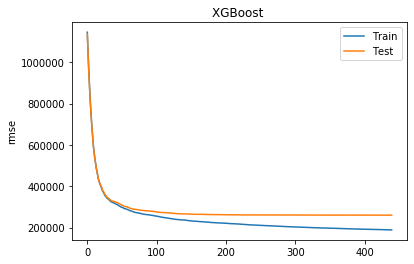

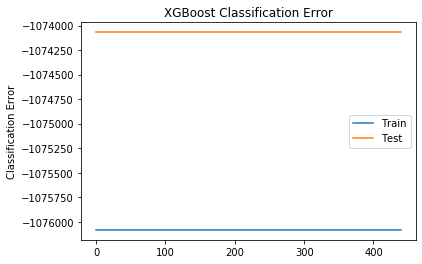

In [103]:
# make predictions for test data
from matplotlib import pyplot

results = xg_reg.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
pyplot.ylabel('rmse')
pyplot.title('XGBoost ')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()